# Thesis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from environment import GridCellWorld
from experiment import Experiment
from utils import to_tensor, eval_locomotion, eval_position
from agent import Agent
from tqdm import tqdm

In [2]:
kwargs = {
    'name': 'test',
    'batches': 5000,
    'pf_epochs': 3000,
    'scheduler_updates': 6,
    'n_modules': 10,
    'n_per_module': 100,
    'gc_scale_min': 120,
    'gc_scale_max': 400,
    'wd_l1': 1e-2,
    'wd_l2': 1e-3,
    'hidden_penalty': 0.01,
    'save_losses': True,
    'bs': 256,
    'tau': 5e-3,
    'buffer_length': 1000,
    'actor_hidden': 256,
    'critic_hidden': 512,
    'lr_a': 3e-4,
    'wd_a': 0,
    'lr_c': 5e-4,
    'wd_c': 1e-5,
    'grad_norm': 1e-1,
    'heterogeneous': True,
    'batches_env2': None,
    'exploration_std': (0, -2, 5000),
    'reinforcement': True,
    'max_episode_len': 30
}

name = kwargs.pop('name')
batches = kwargs.pop('batches')
pf_epochs = kwargs.pop('pf_epochs')
scheduler_updates = kwargs.pop('scheduler_updates')
kwargs.pop('batches_env2')

data_path = os.path.join('data', name)

In [3]:
exp = Experiment(name, **kwargs)
exp.compile_grid_cells(1)

In [4]:
exp.run_experiment(batches)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [34:49<00:00,  2.39it/s]


In [5]:
print("Agent reward - %.03f\nlengths - %.03f" % eval_locomotion(exp.agent, GridCellWorld(exp.grid_cells, exp.coords)))
print(f"Position loss - {eval_position(exp.agent, exp.coords, exp.grid_cells):.03f}")

Starting evaluation
Agent reward - -57.574
lengths - 44.020


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x1000 and 1002x256)

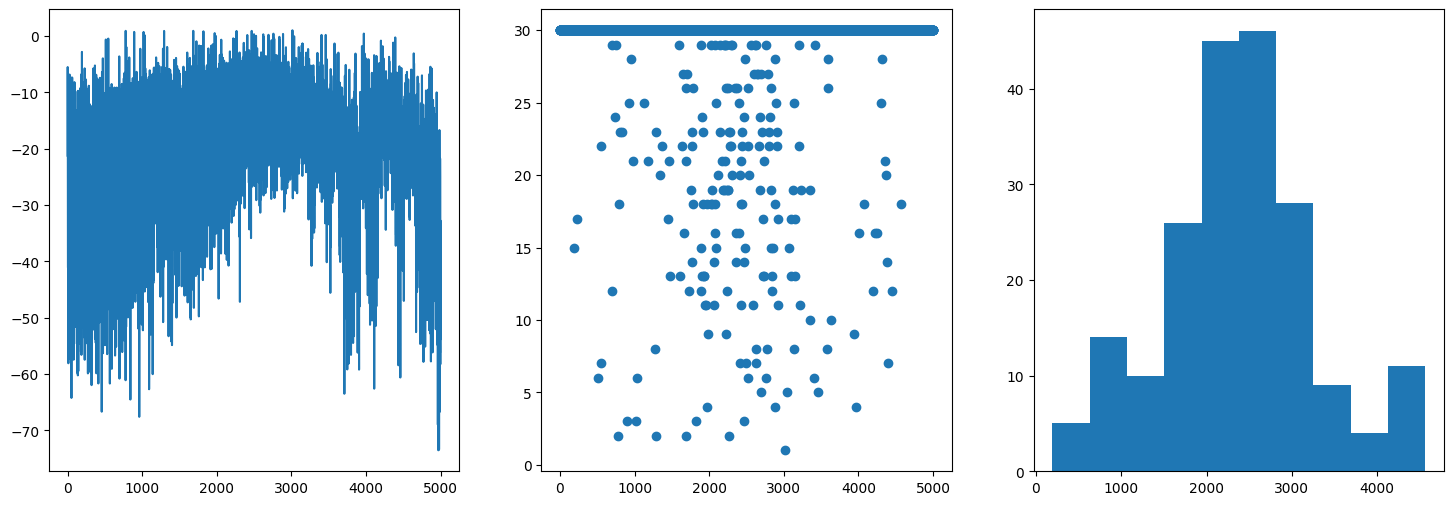

In [6]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

lengths = exp.rl_results['lengths']
ax1.plot(exp.rl_results['rewards'])
ax2.scatter(np.arange(len(lengths)), lengths)
ax3.hist(np.arange(len(lengths))[np.asarray(lengths) < exp.max_episode_len])
plt.show()

In [7]:
exp.agent.actor.lin2.weight.abs().mean()

tensor(0.0844, device='cuda:0', grad_fn=<MeanBackward0>)

In [13]:
import torch

In [15]:
hidden = exp.agent.actor.lin1(torch.concat([exp.grid_cells, torch.zeros(400, 400, 2).cuda()], dim=-1)).detach().permute(-1, 0, 1).cpu()

In [16]:
hidden.numpy().max((1, 2)).mean()

0.0037175317

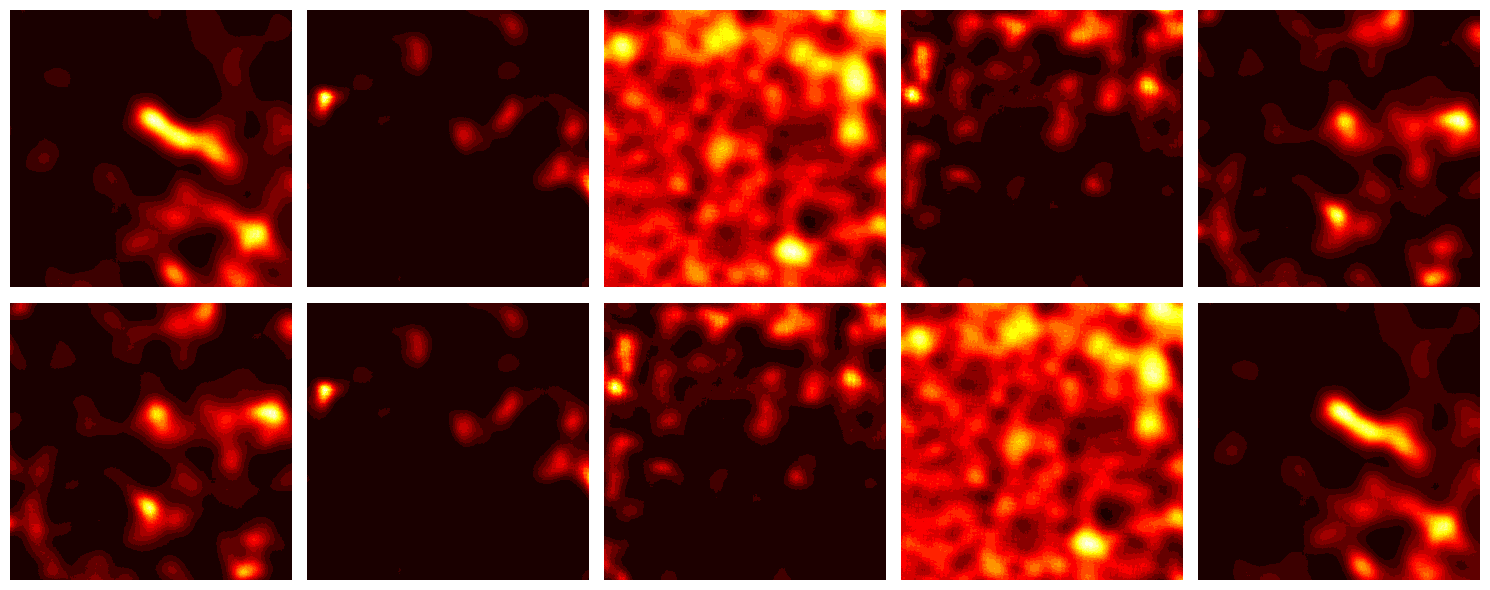

In [17]:
_, axs = plt.subplots(2, 5, figsize=(15, 6))

idx = exp.agent.actor.lin2.weight[:2].detach().cpu().abs().argsort(dim=-1)[:,-5:]
for img, ax in zip(hidden[idx.flatten()], axs.flatten()):
    ax.contourf(img, levels=20, cmap='hot')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [18]:
hidden[:,0,0] = hidden.max(1).values.max(1).values.mean()
hidden[:,0,1] = hidden.min()

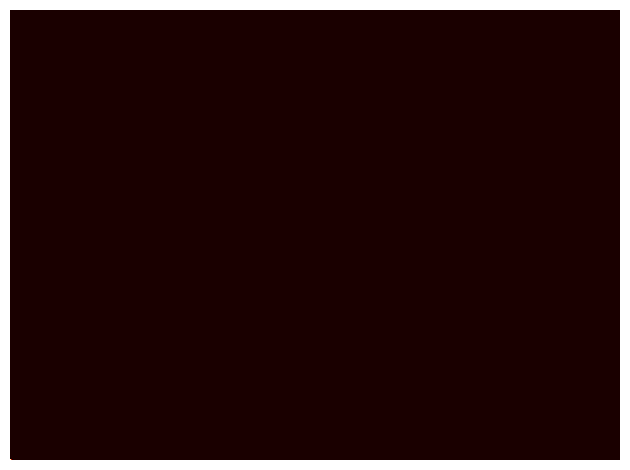

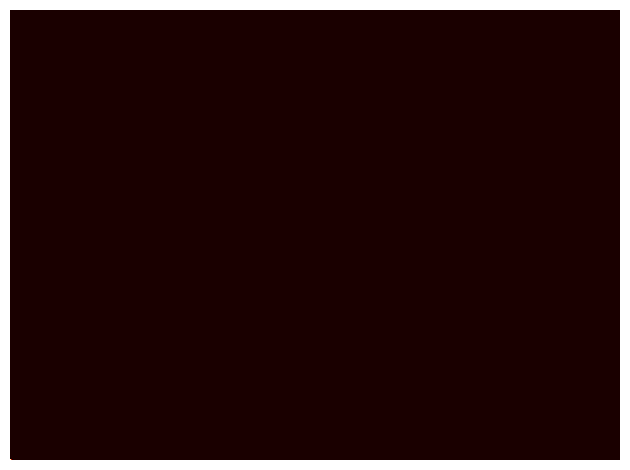

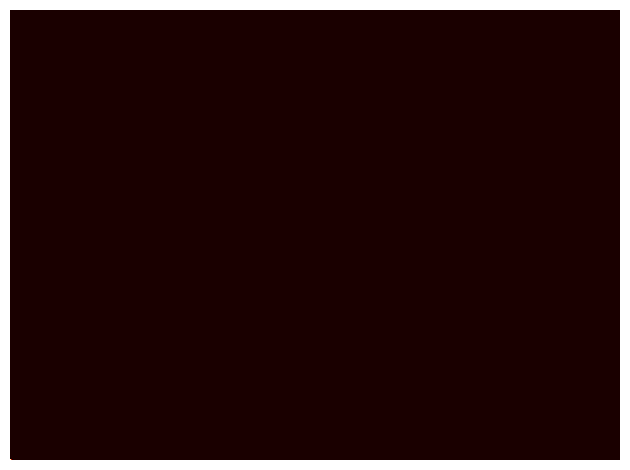

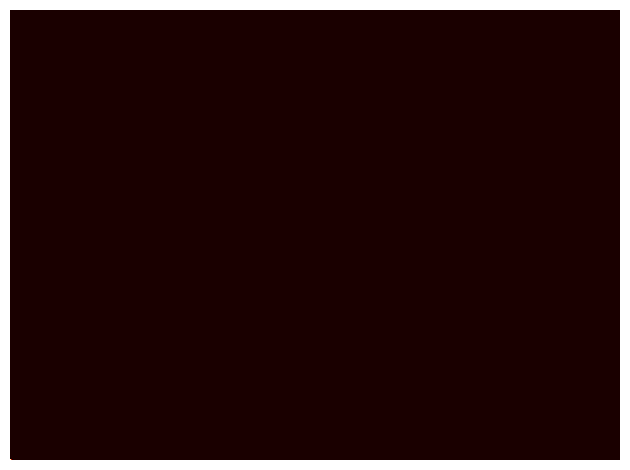

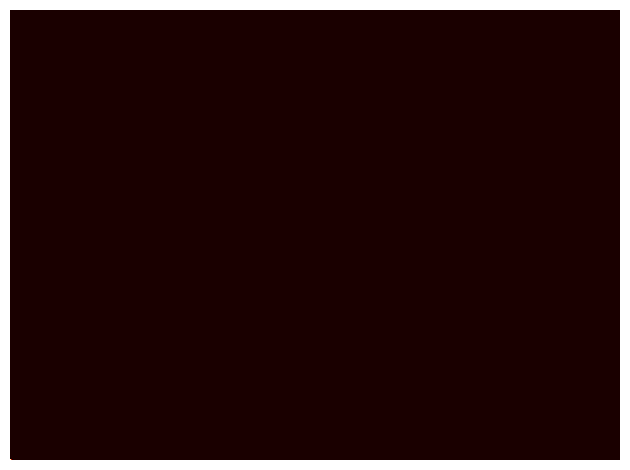

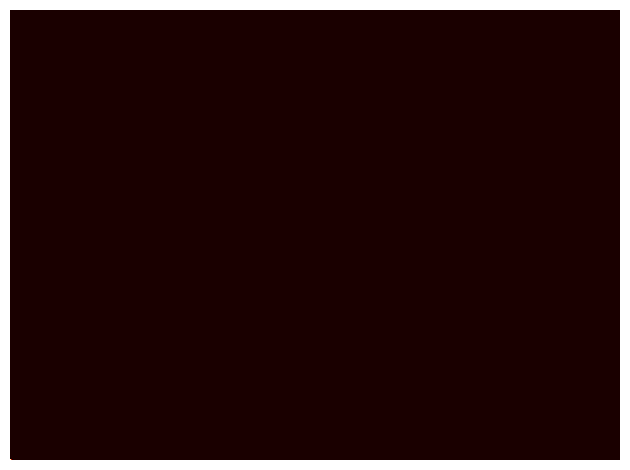

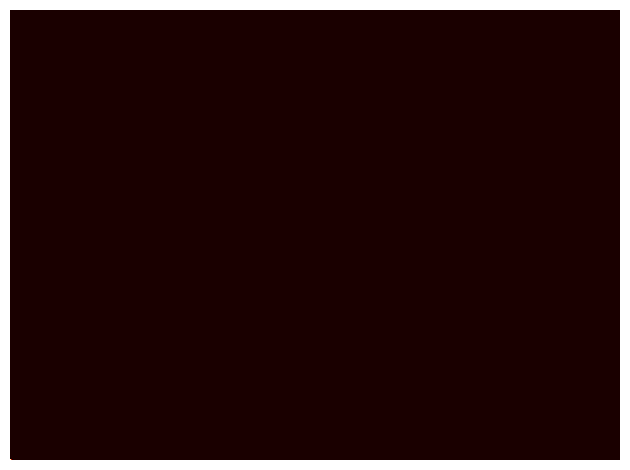

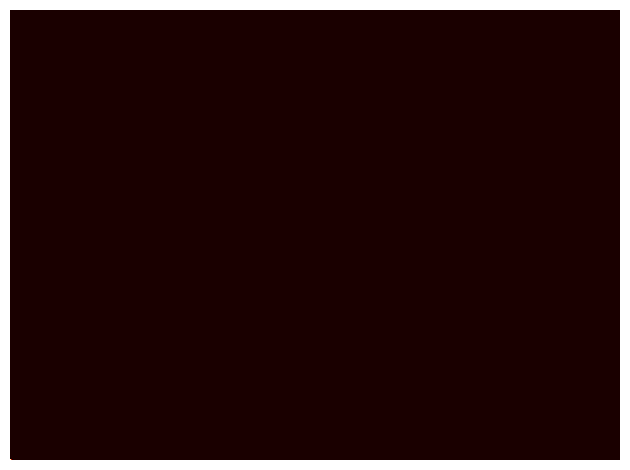

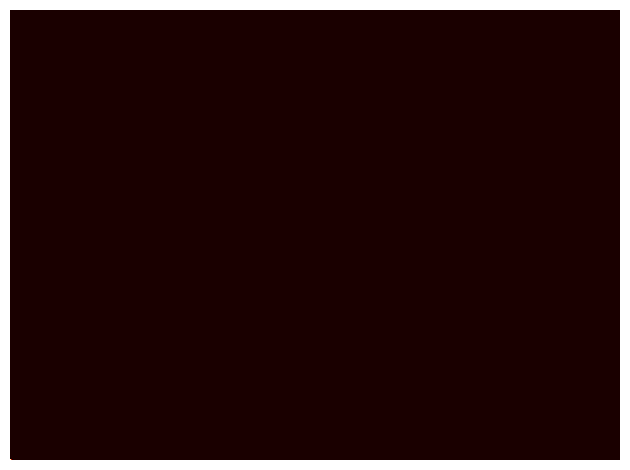

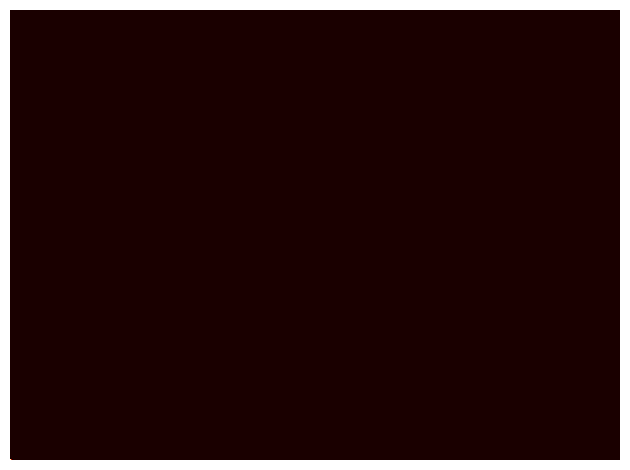

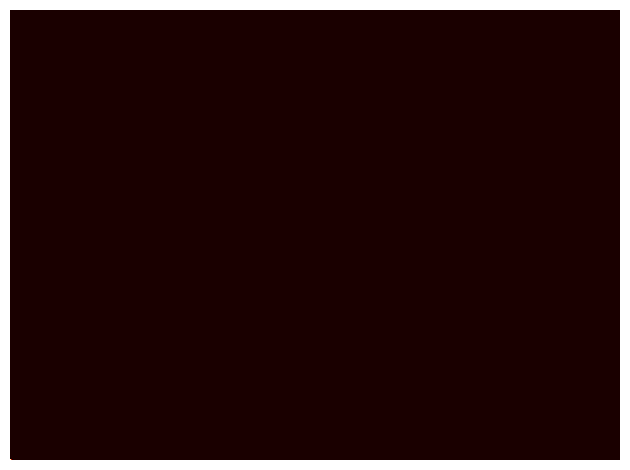

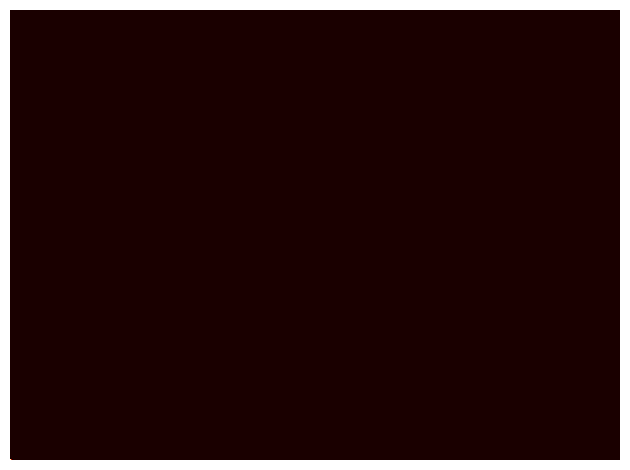

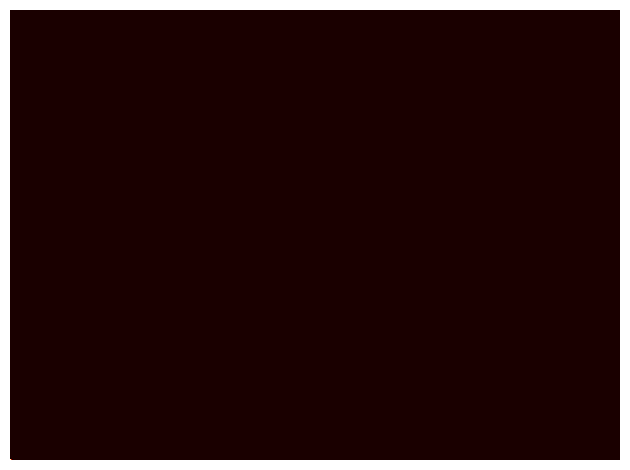

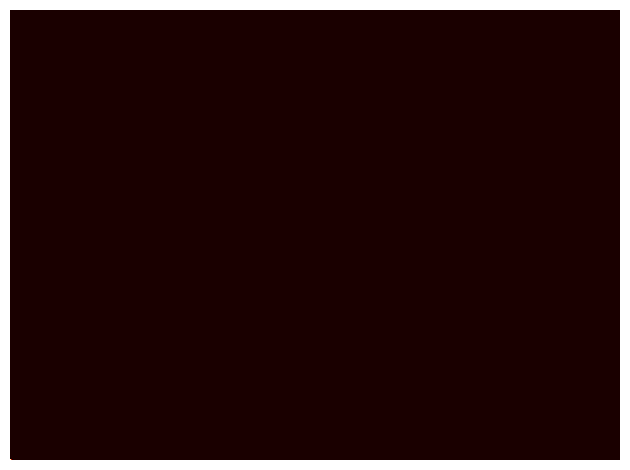

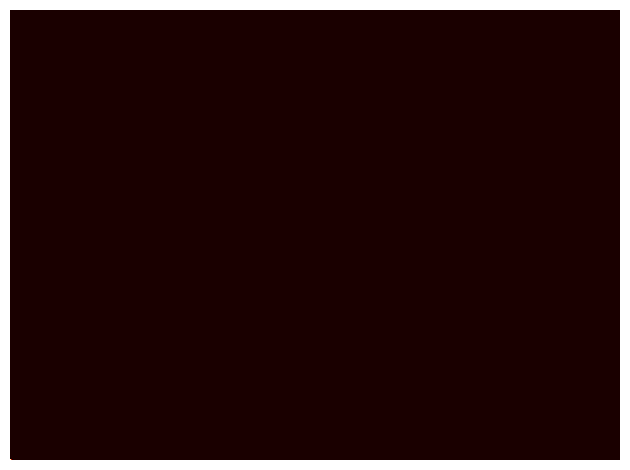

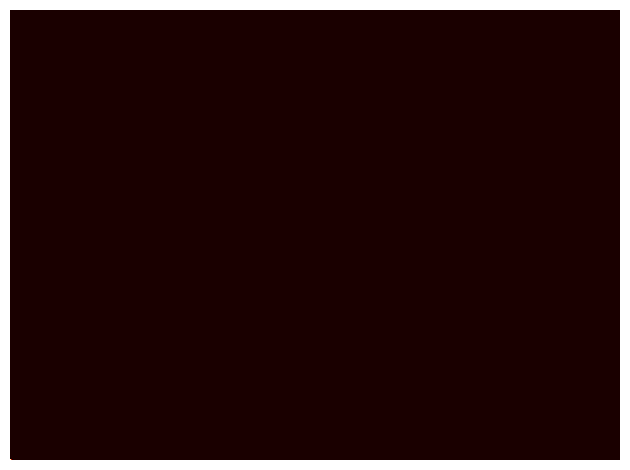

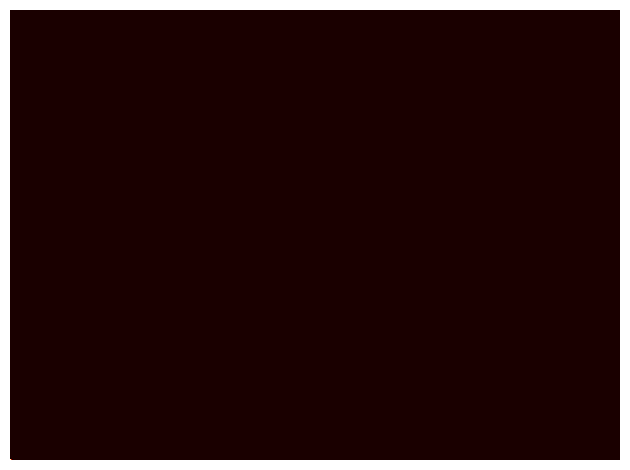

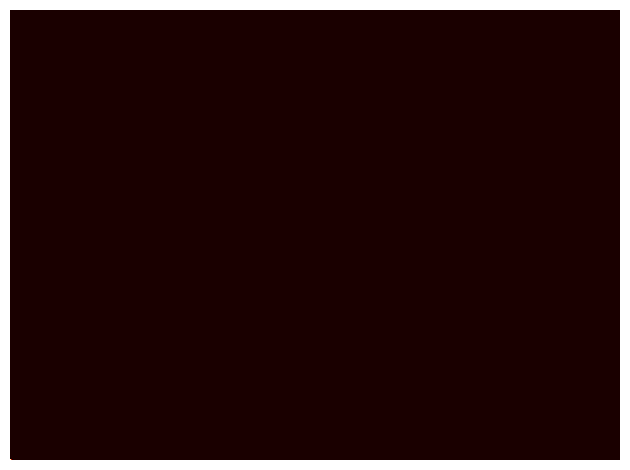

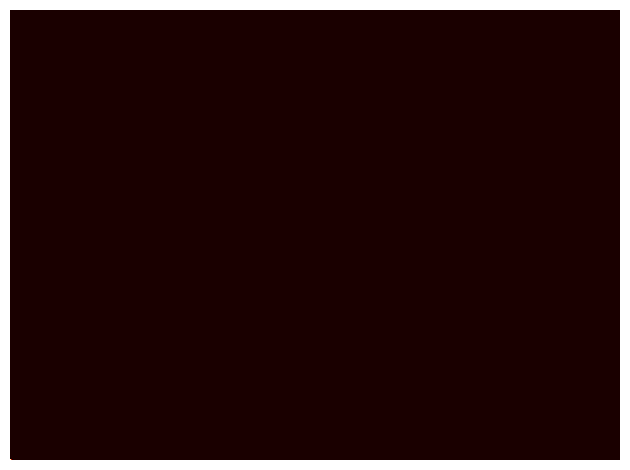

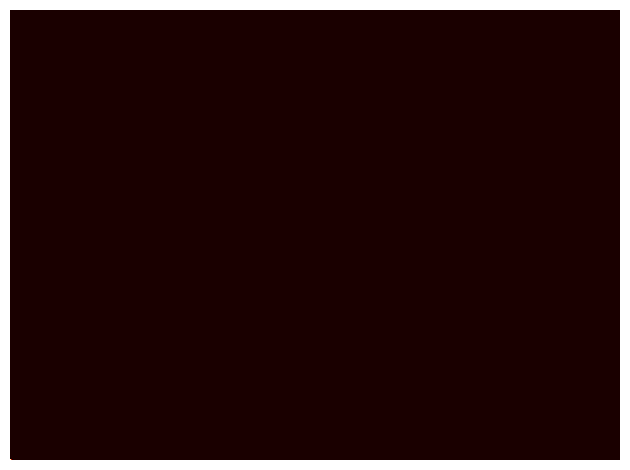

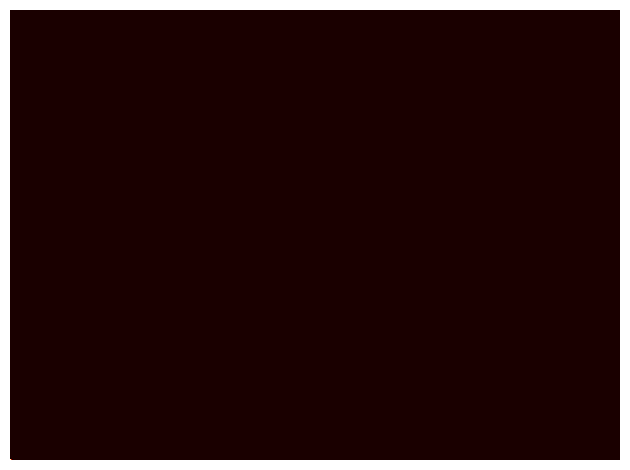

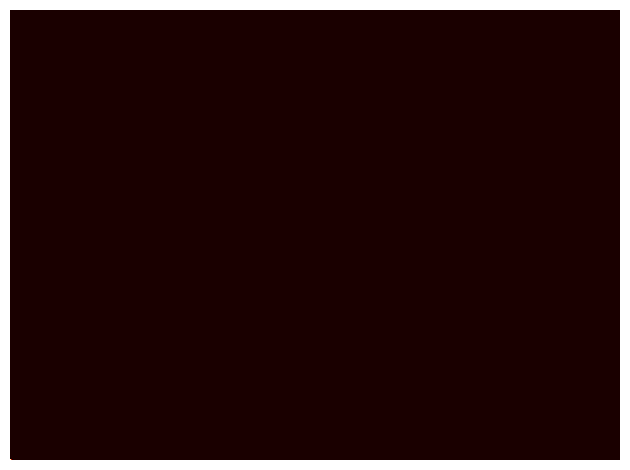

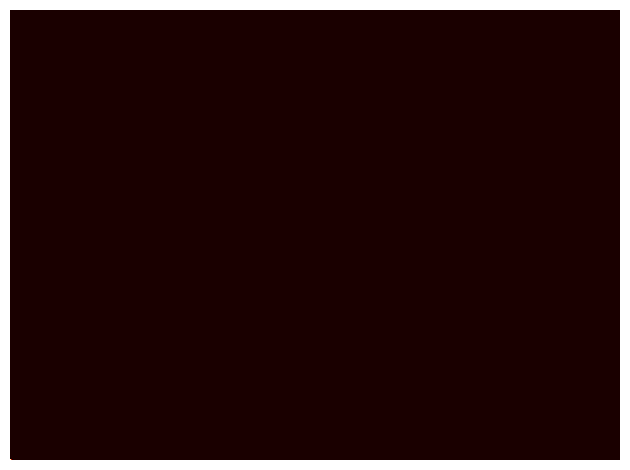

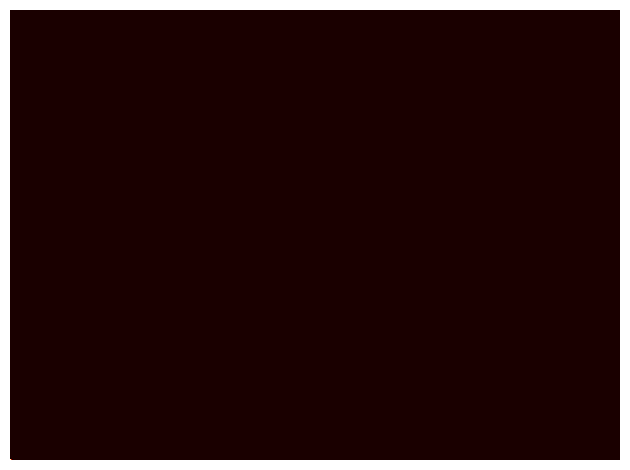

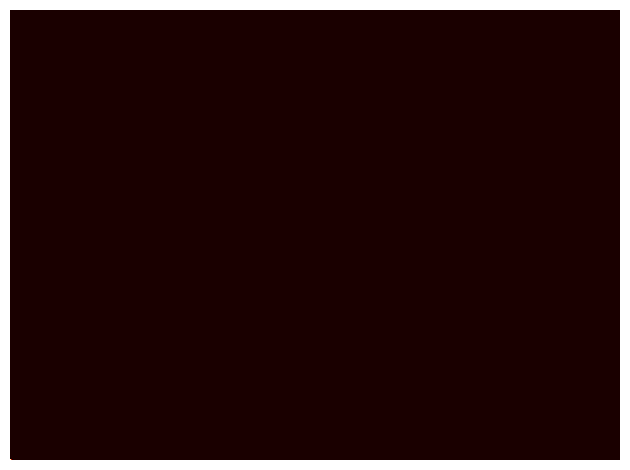

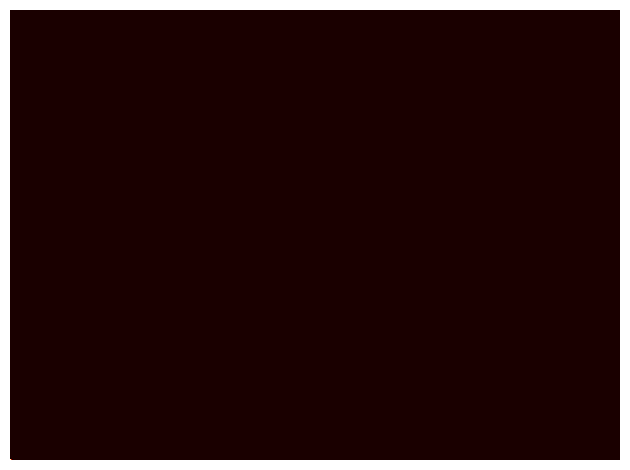

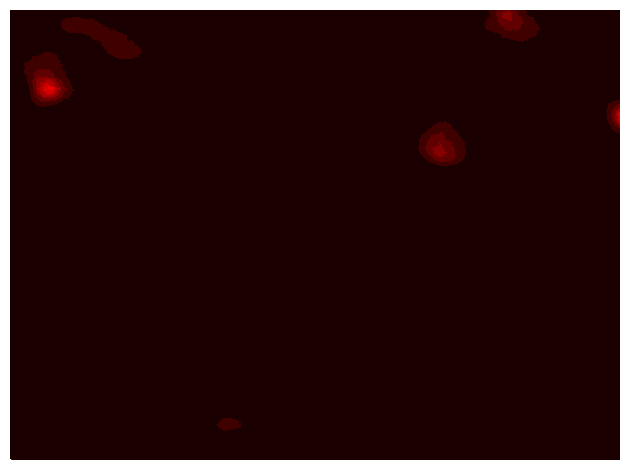

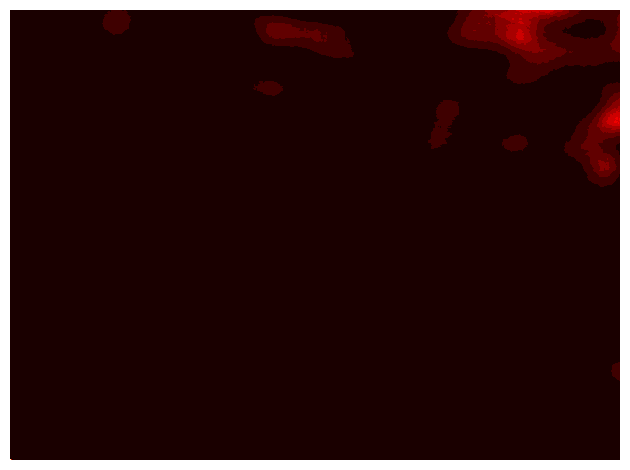

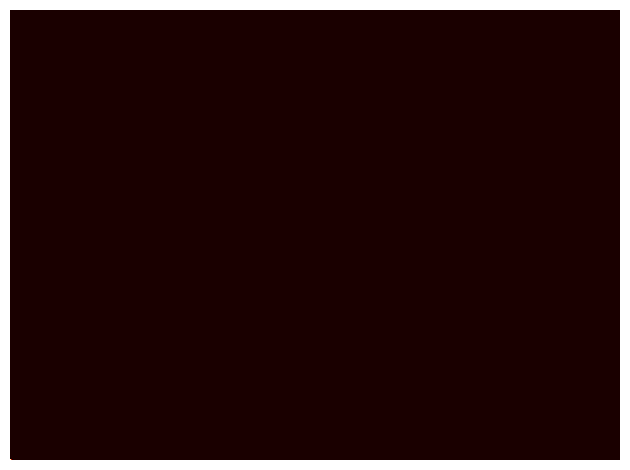

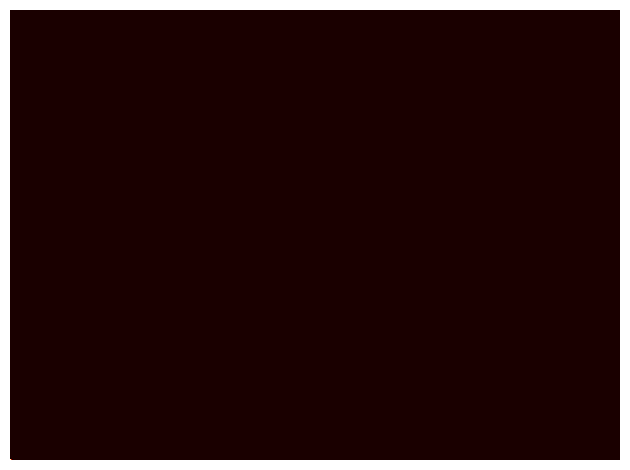

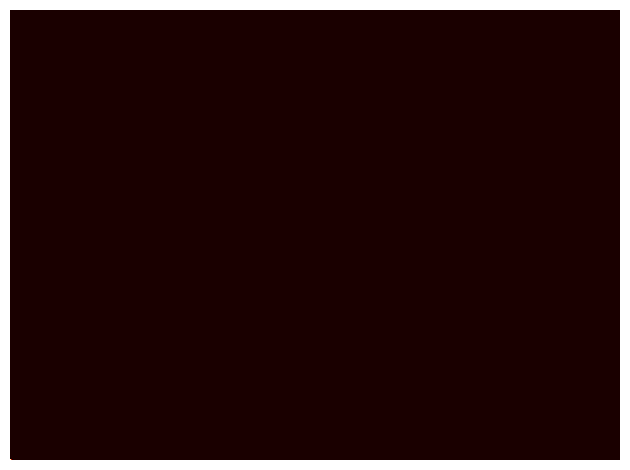

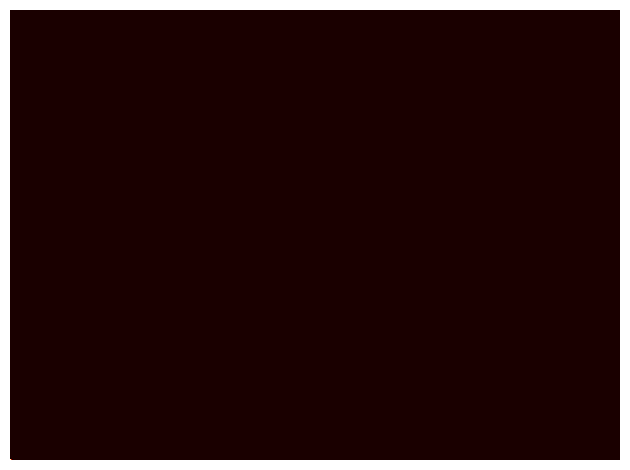

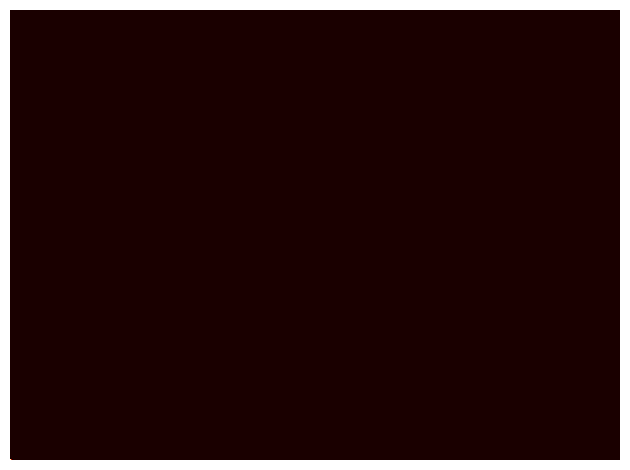

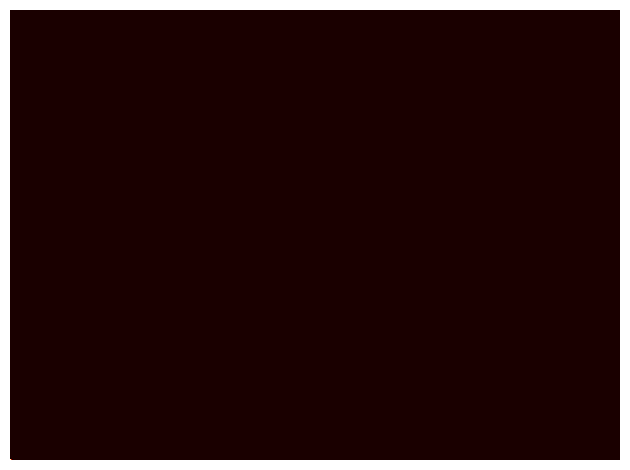

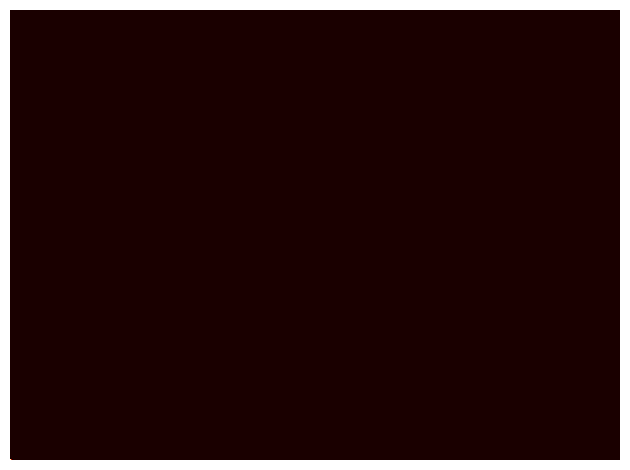

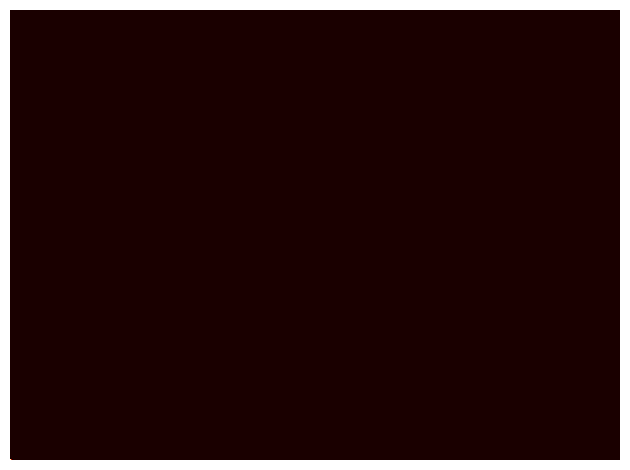

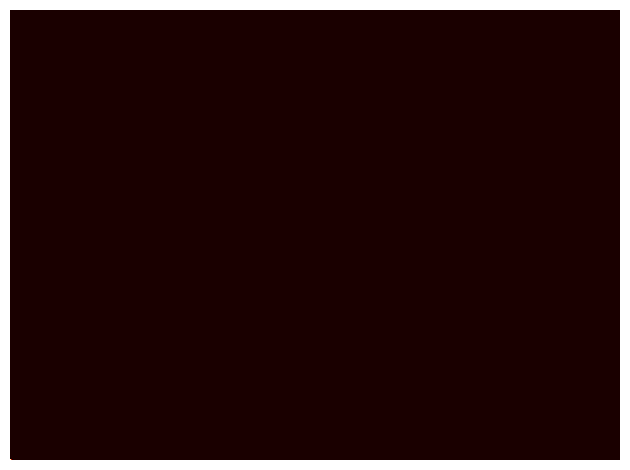

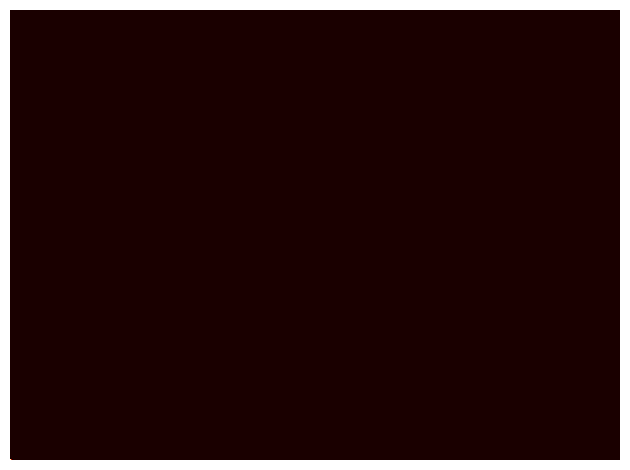

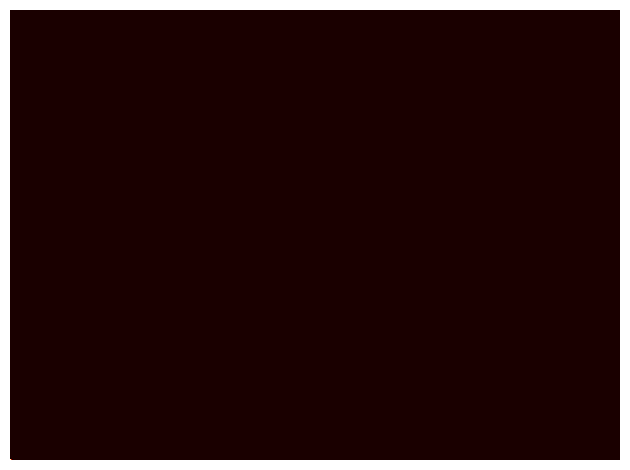

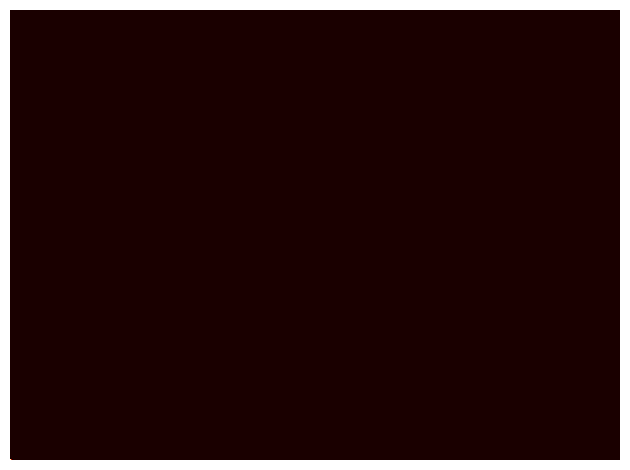

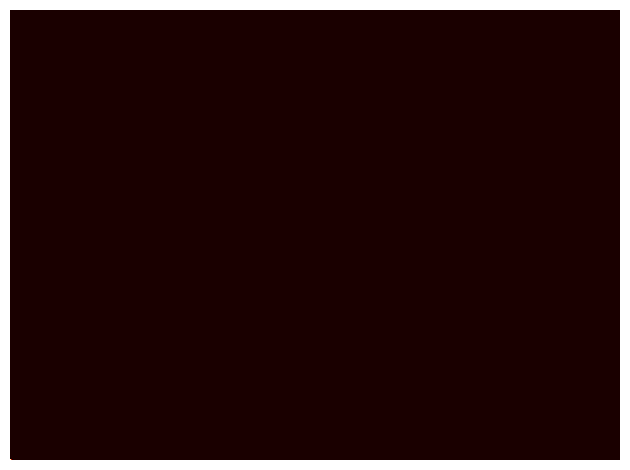

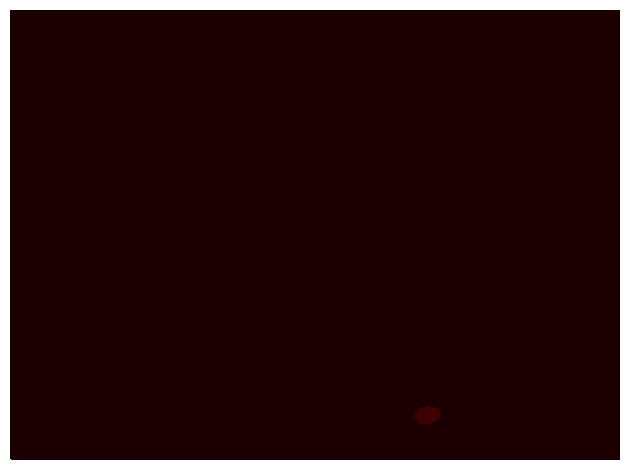

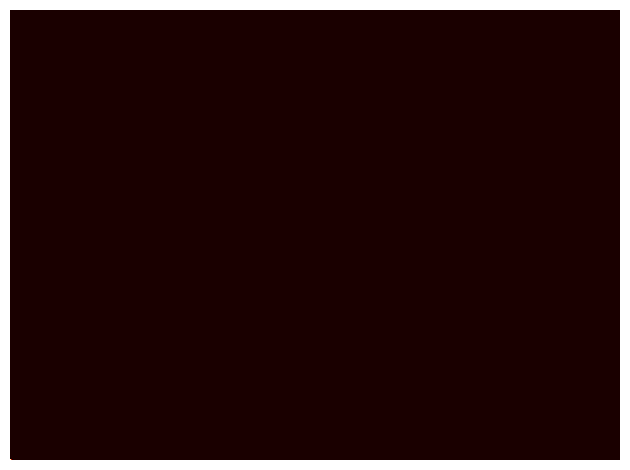

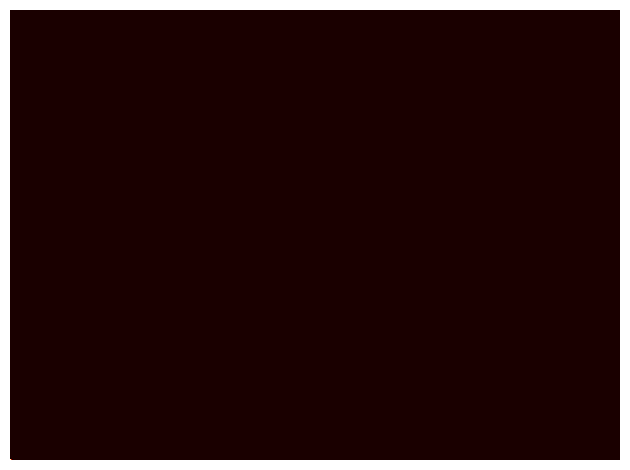

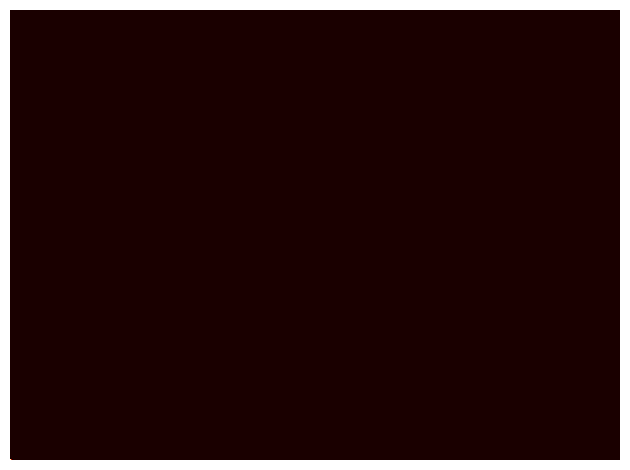

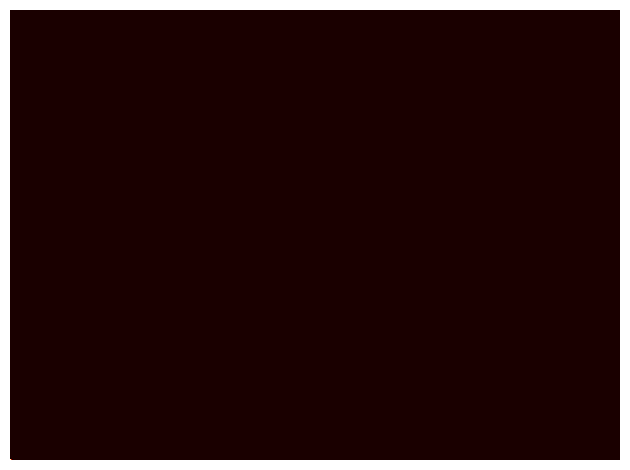

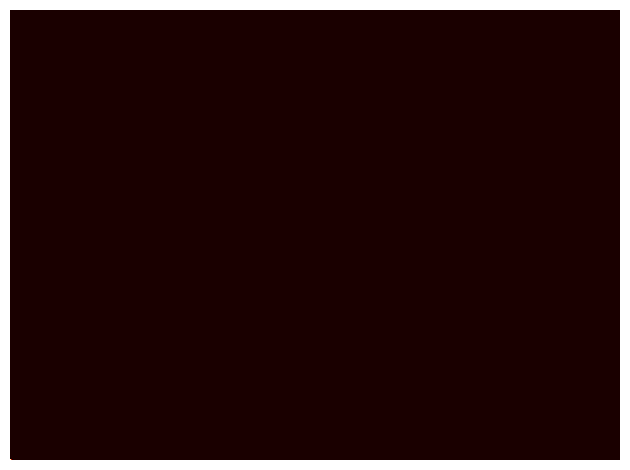

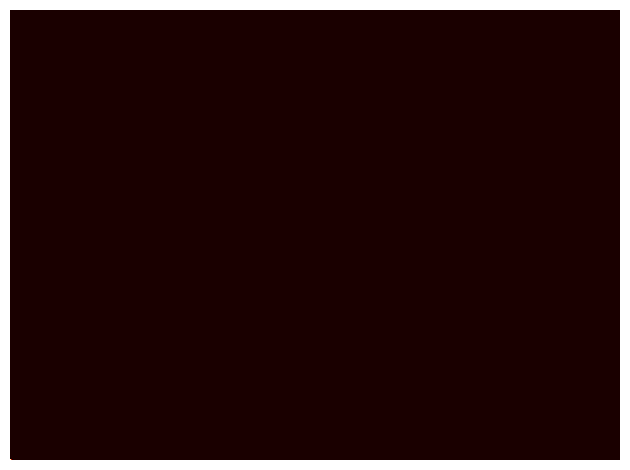

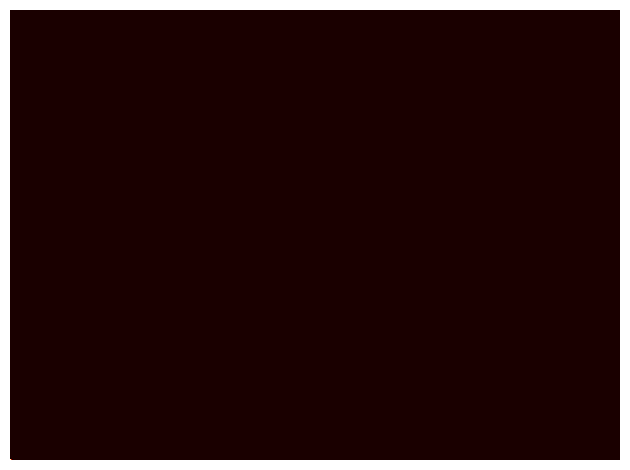

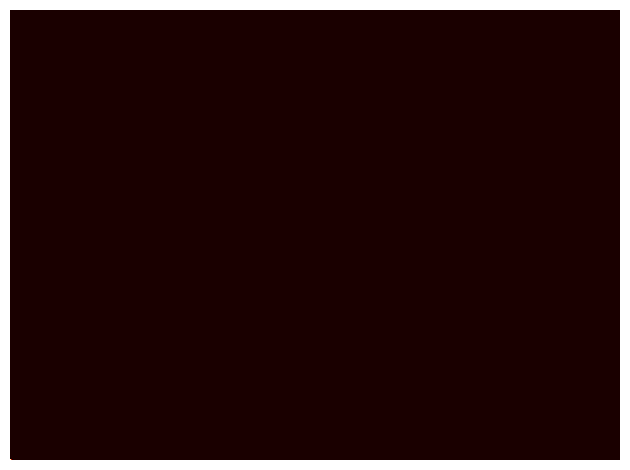

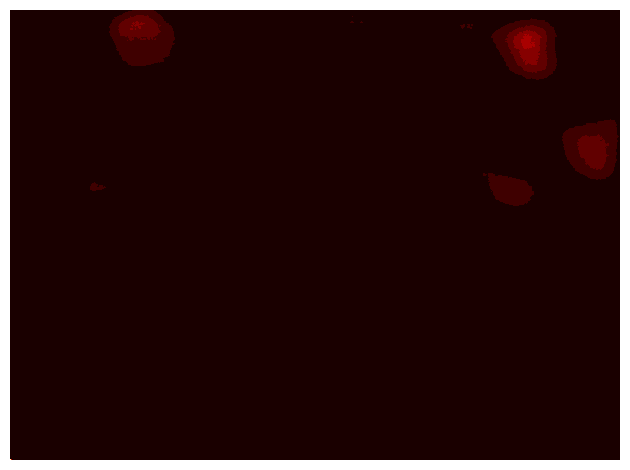

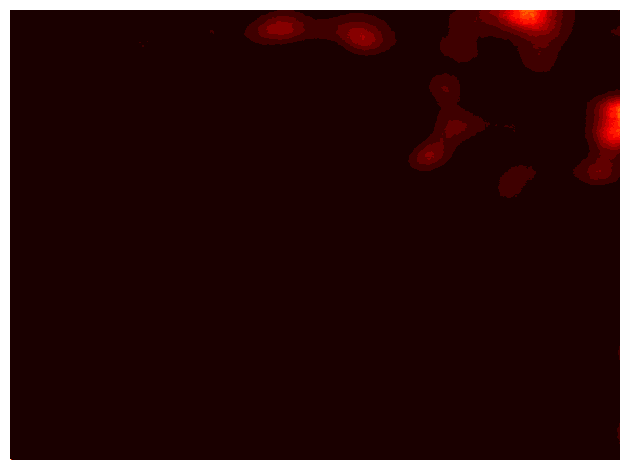

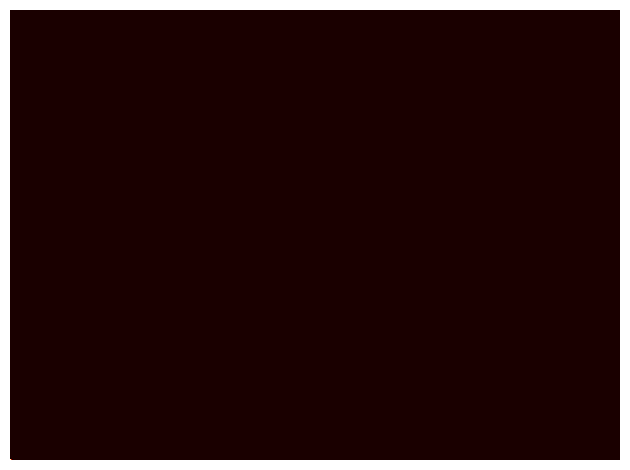

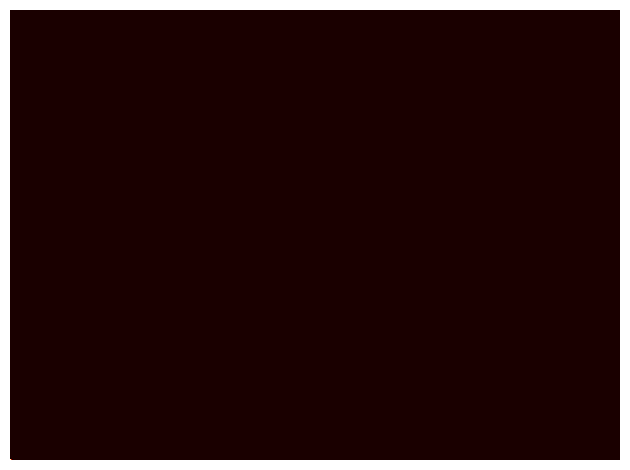

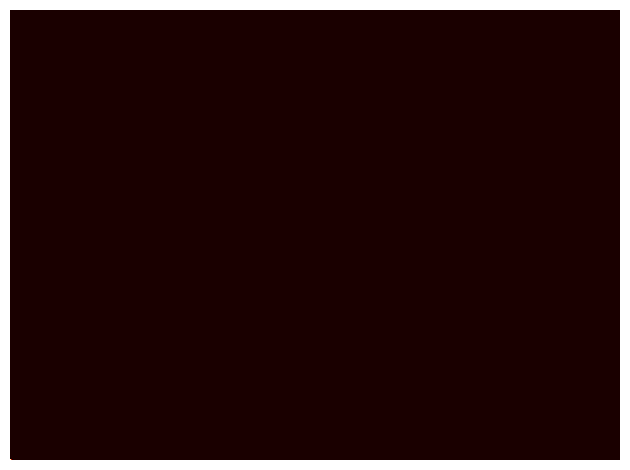

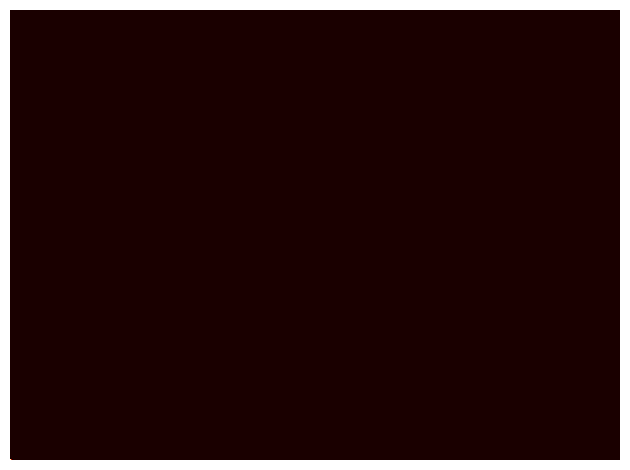

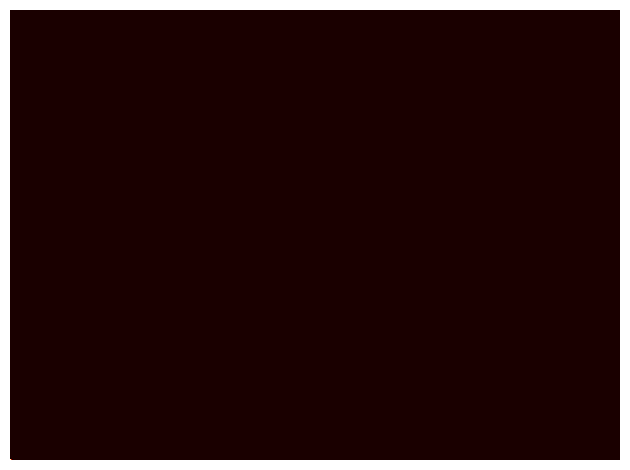

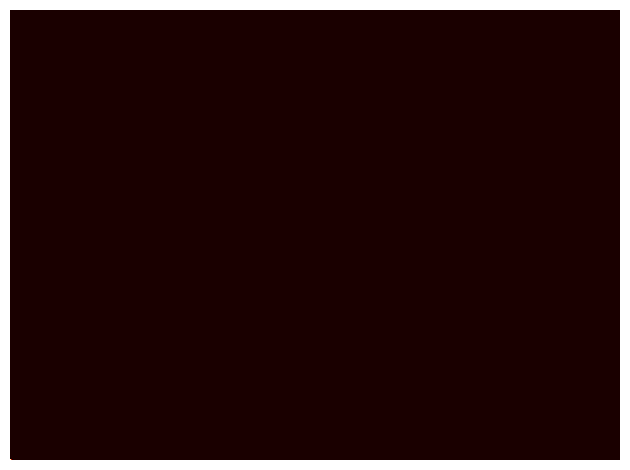

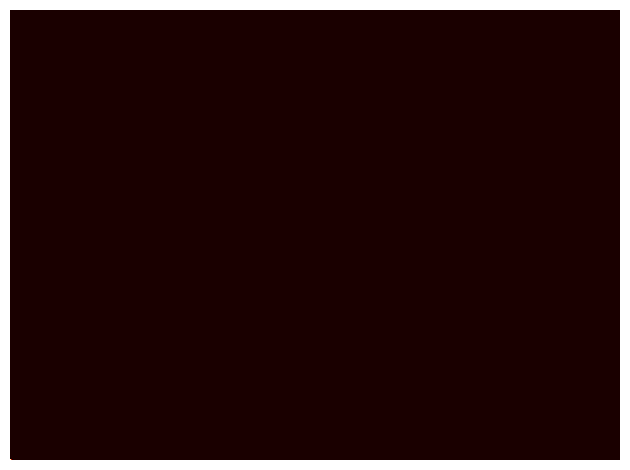

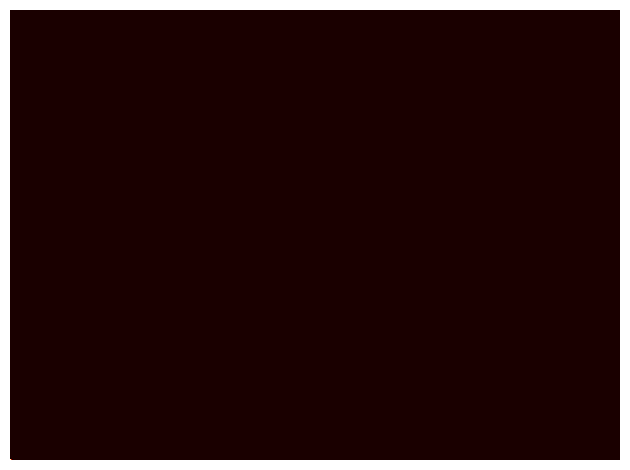

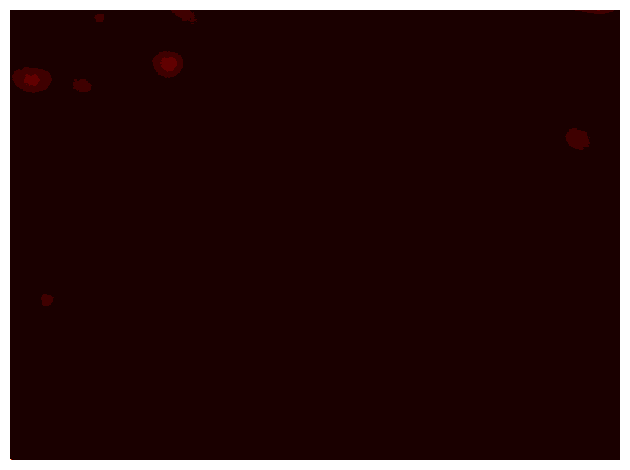

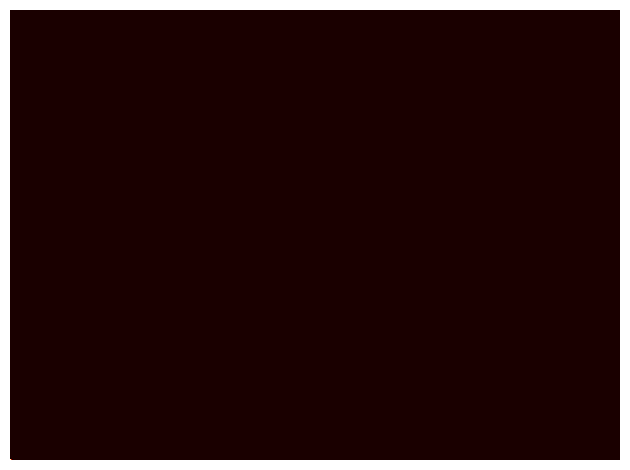

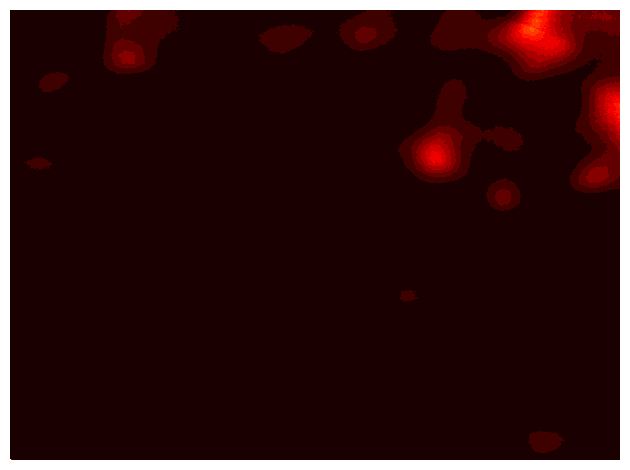

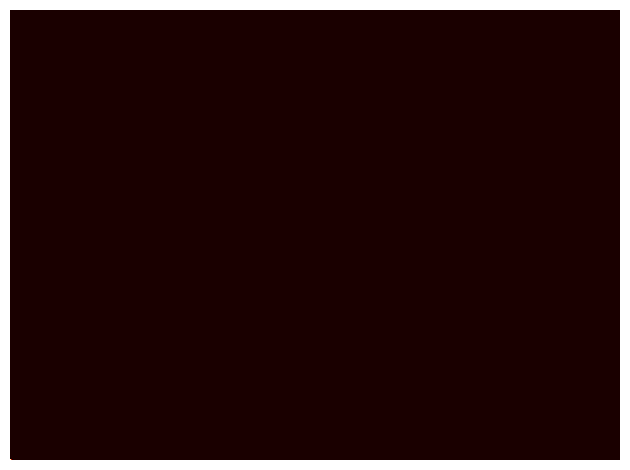

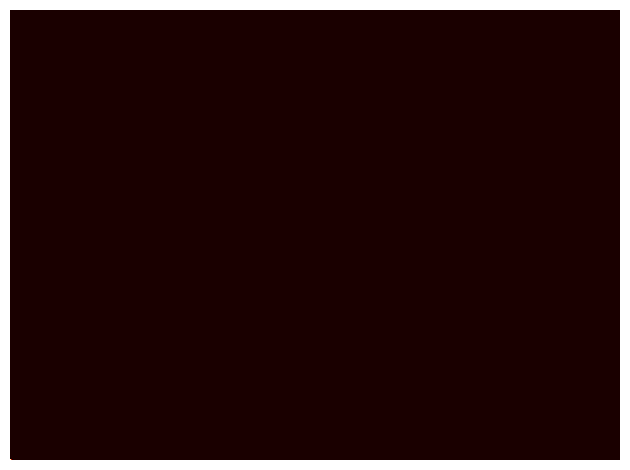

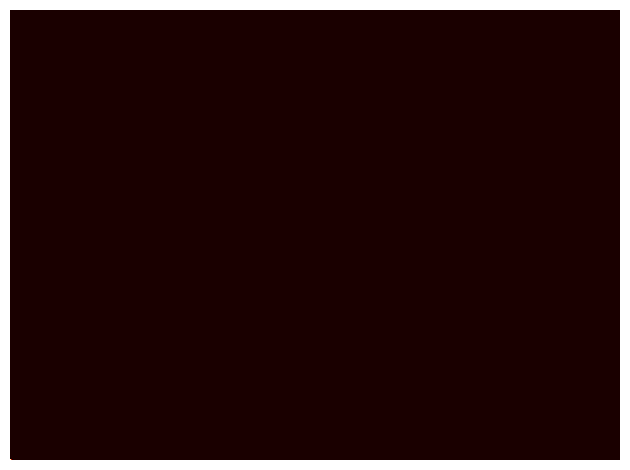

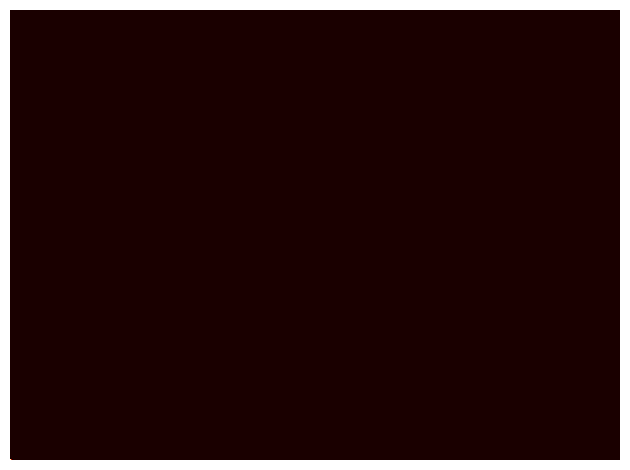

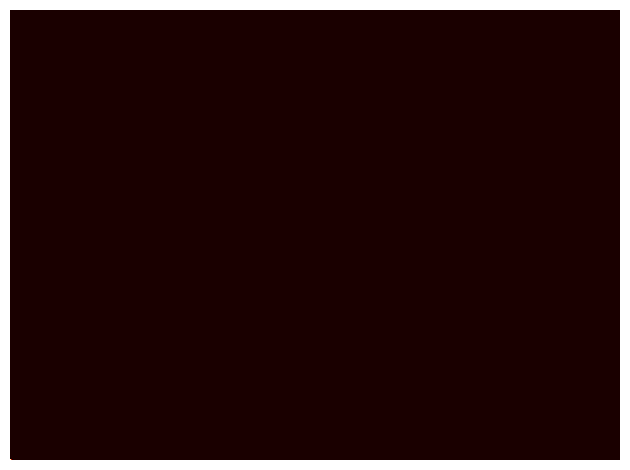

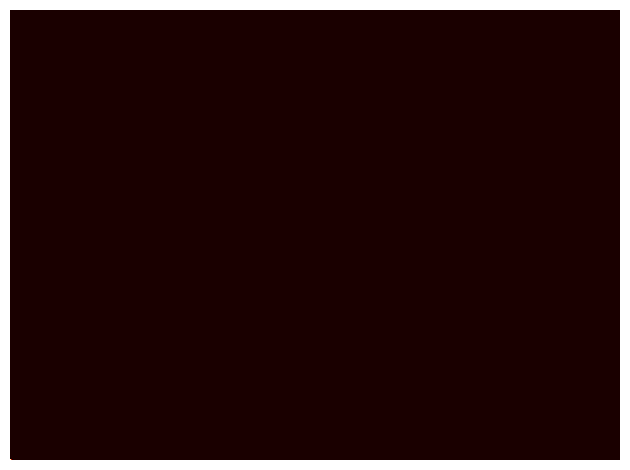

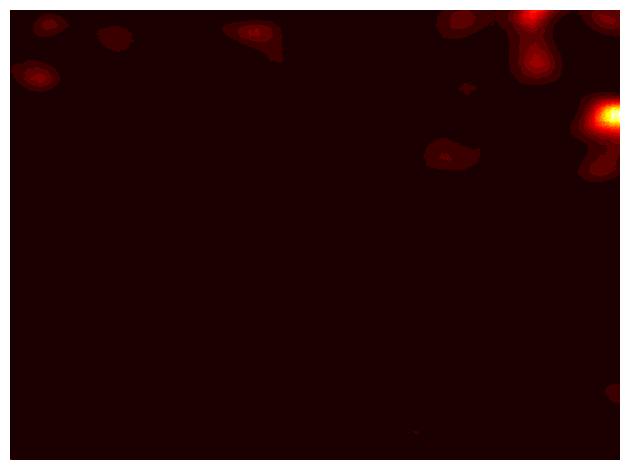

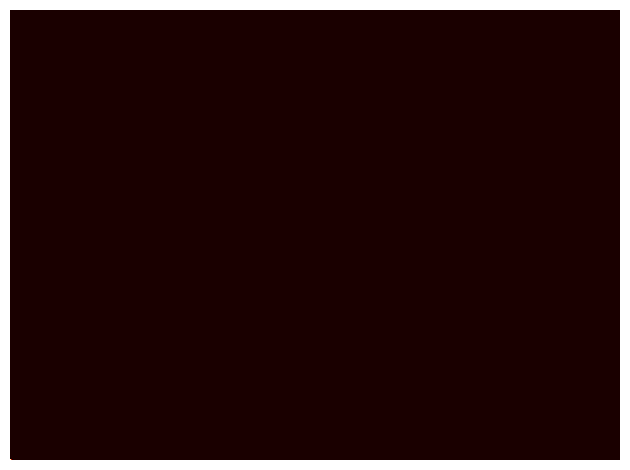

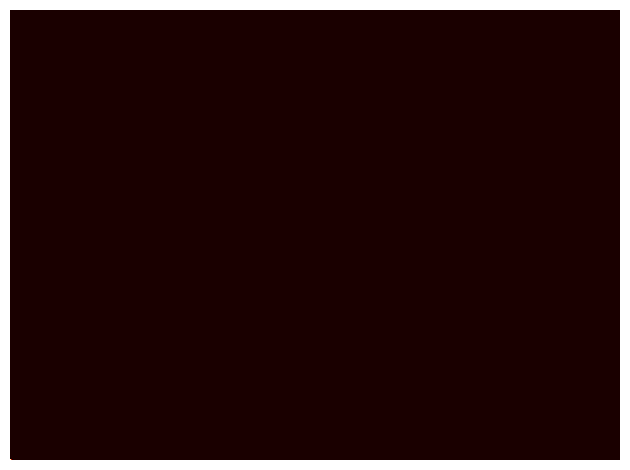

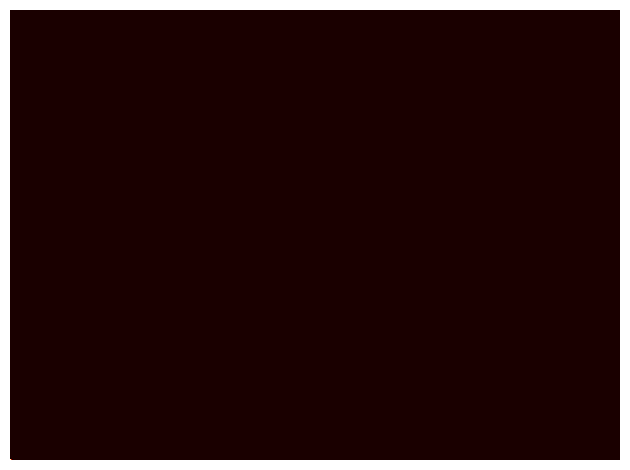

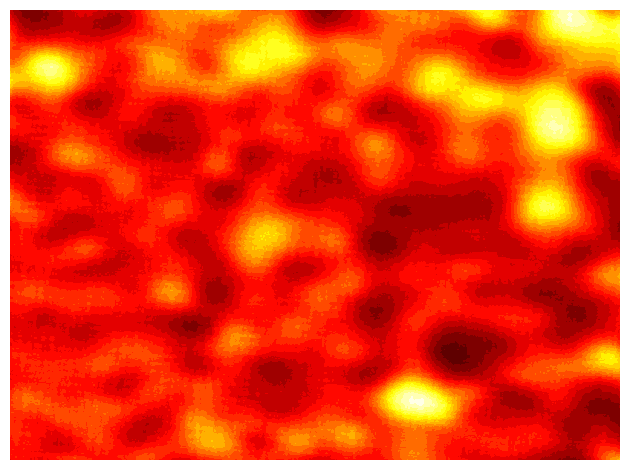

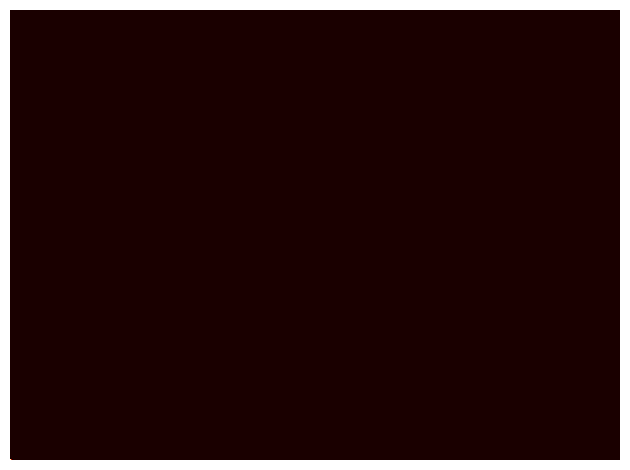

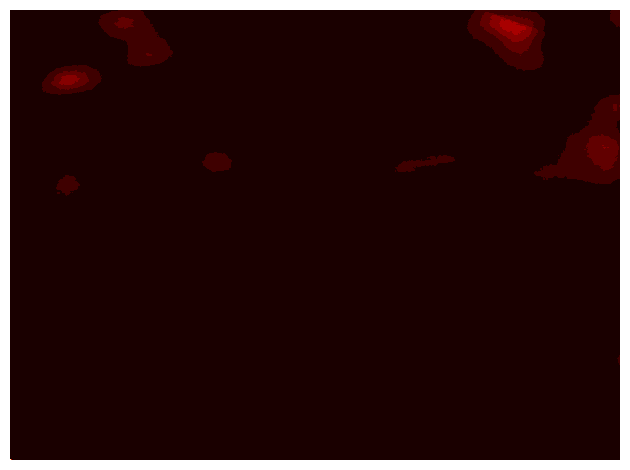

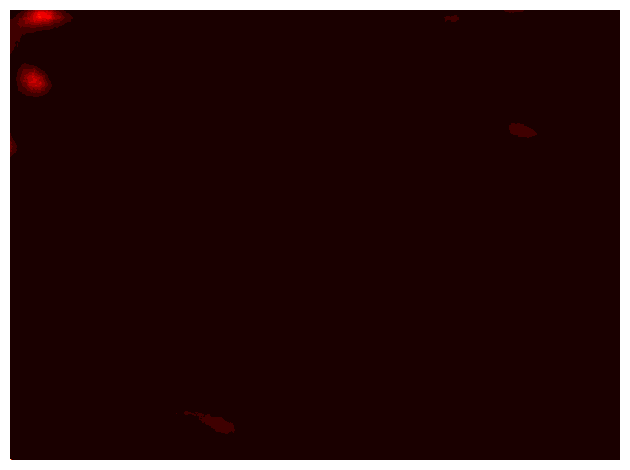

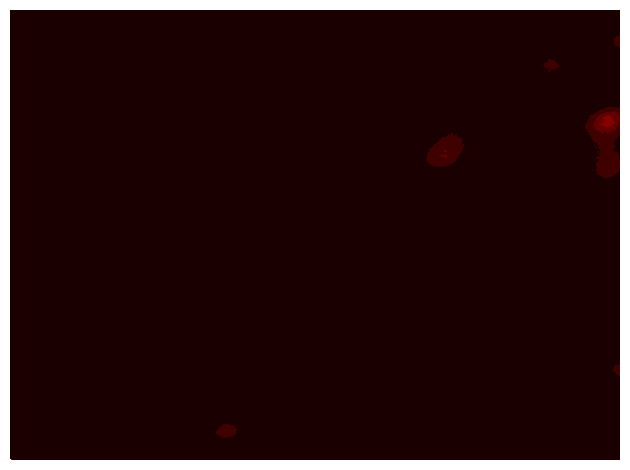

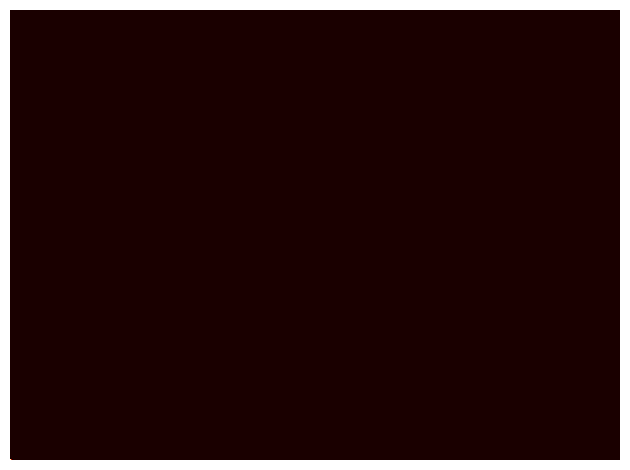

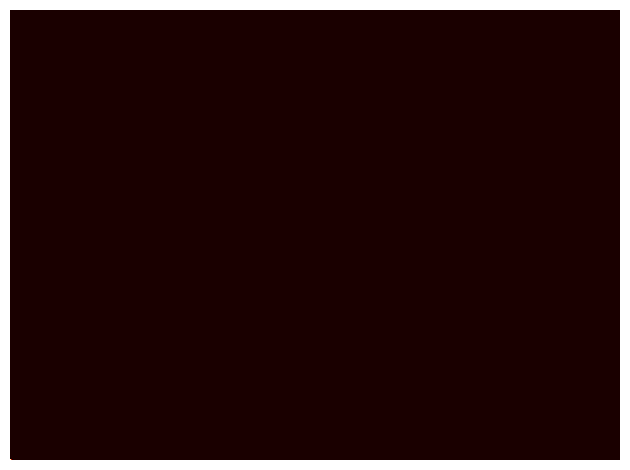

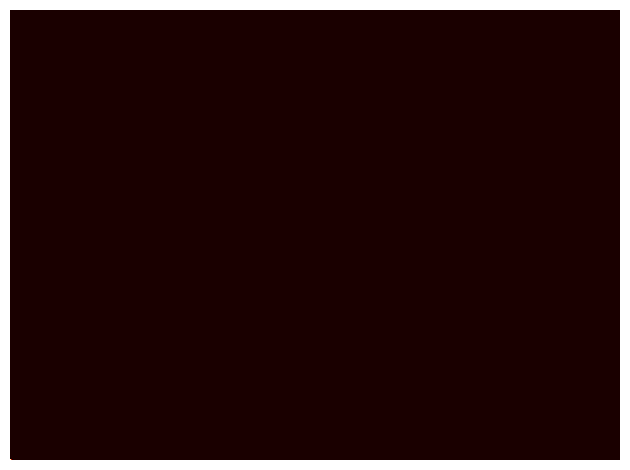

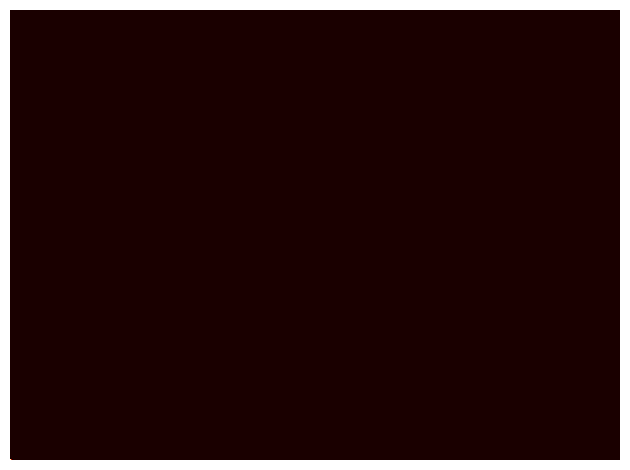

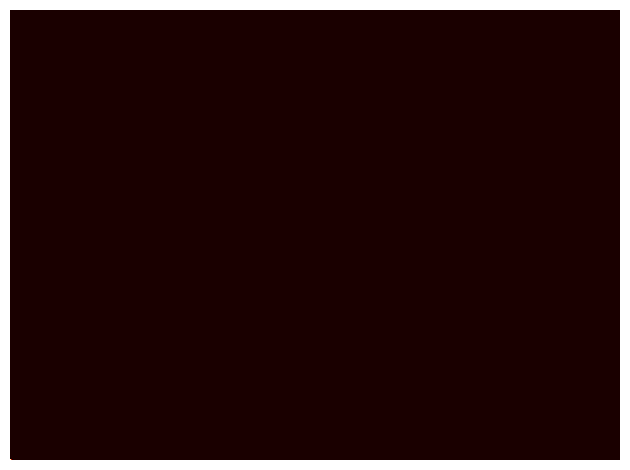

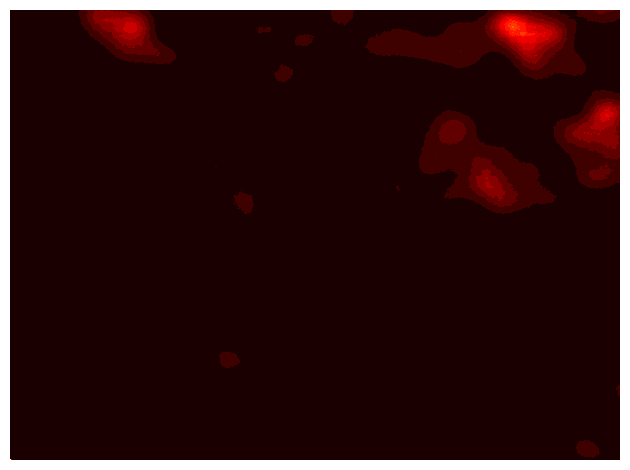

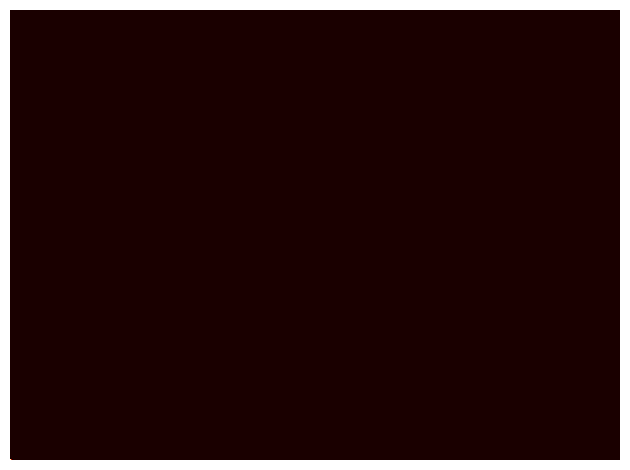

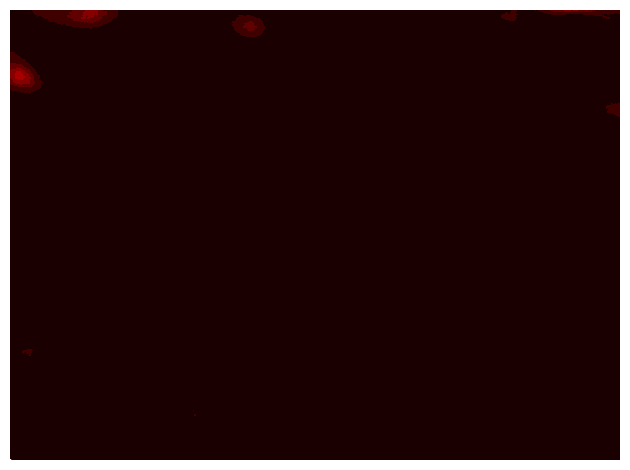

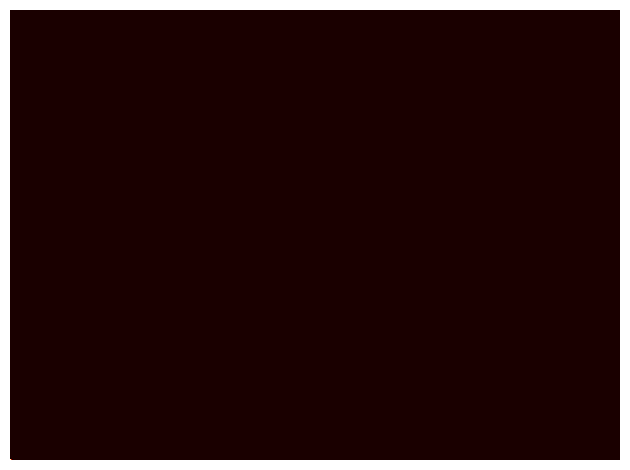

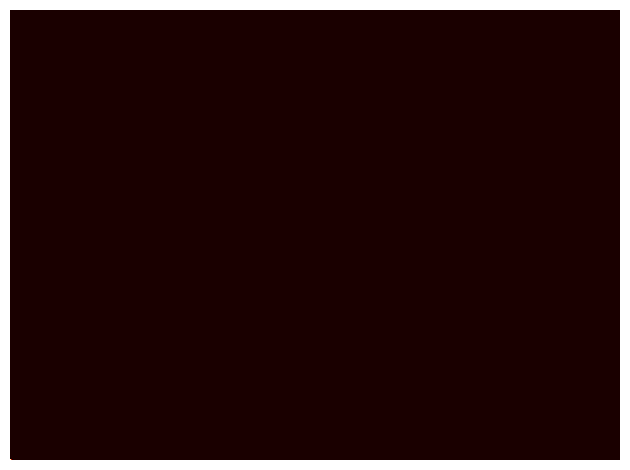

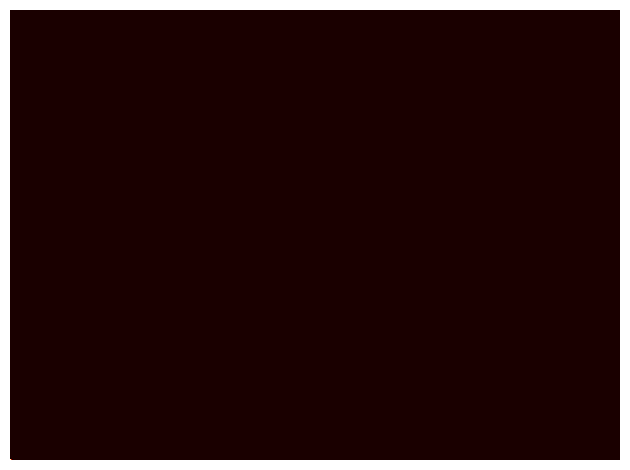

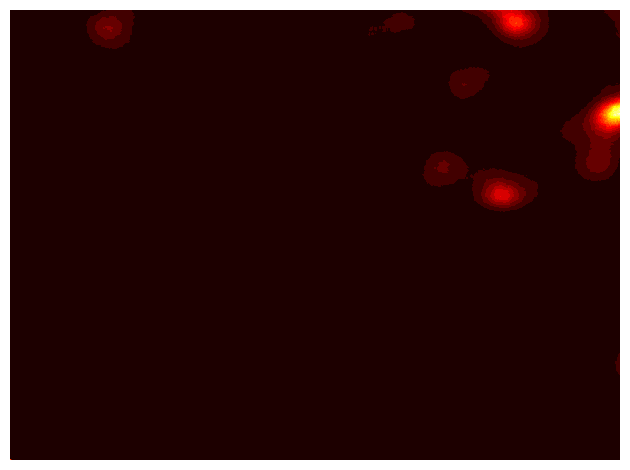

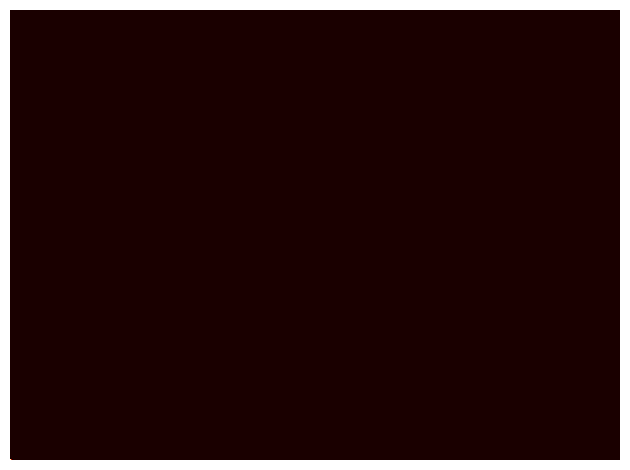

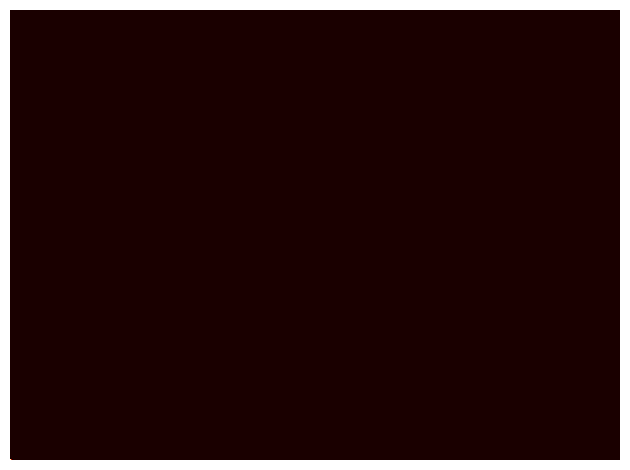

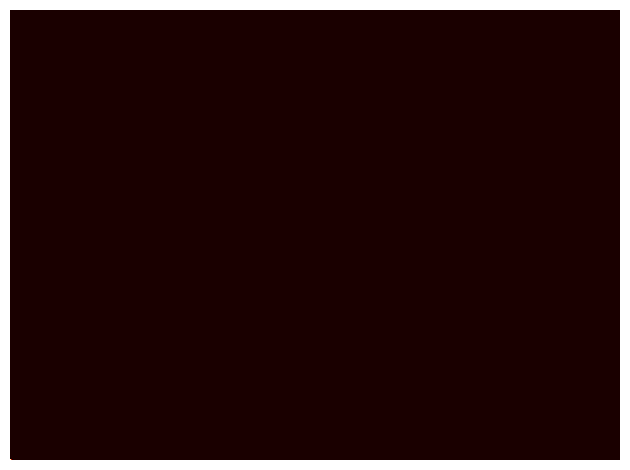

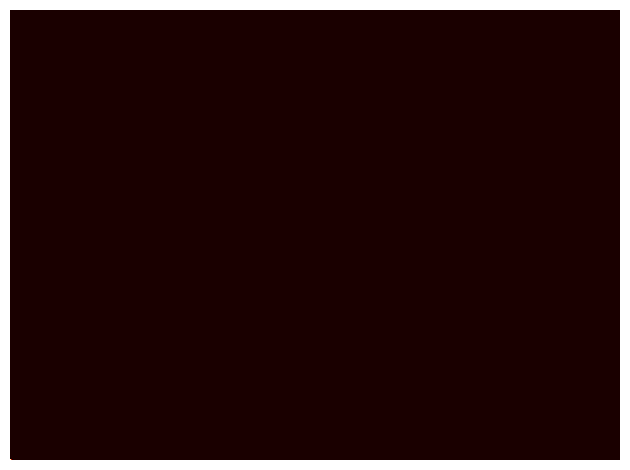

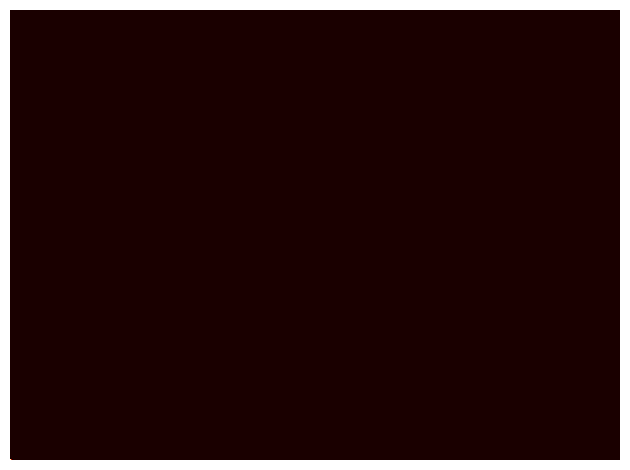

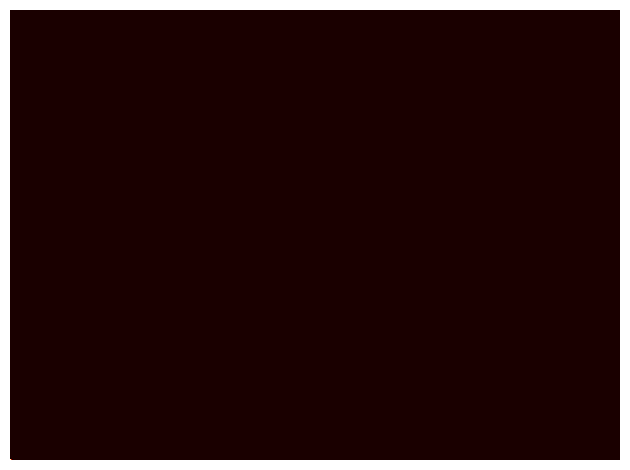

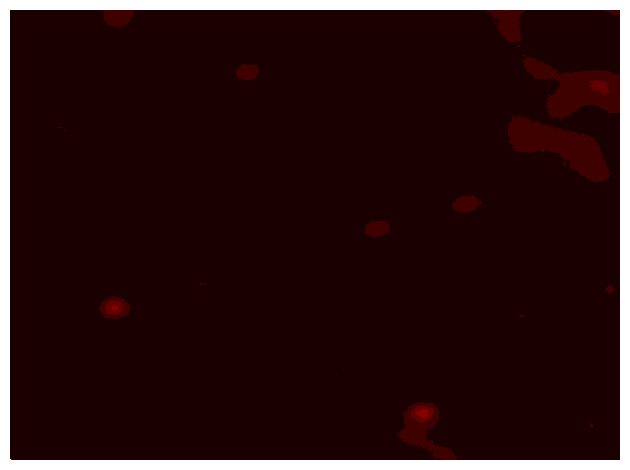

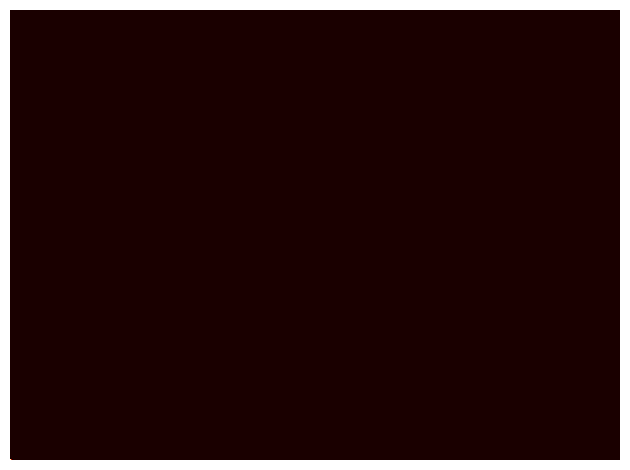

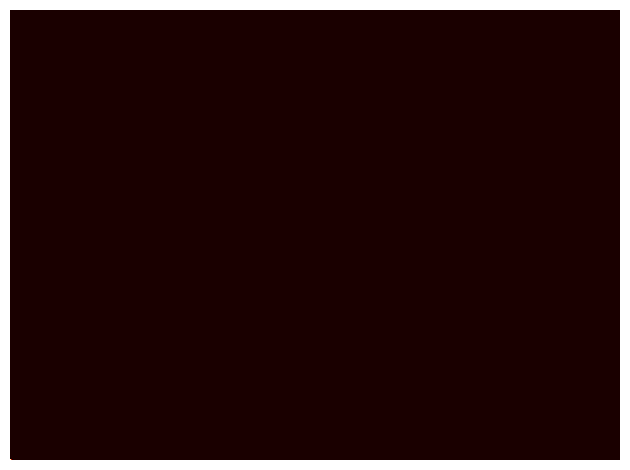

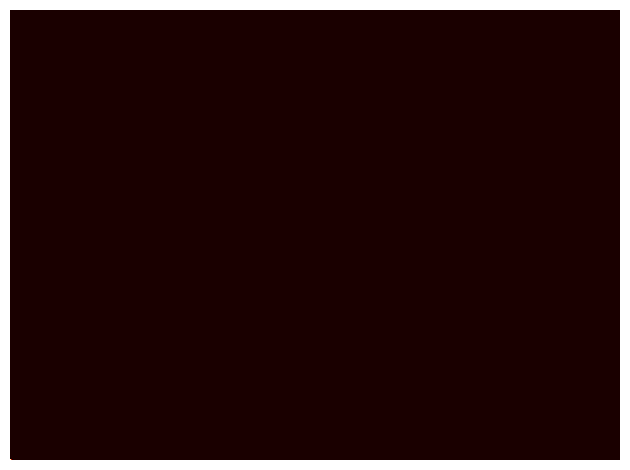

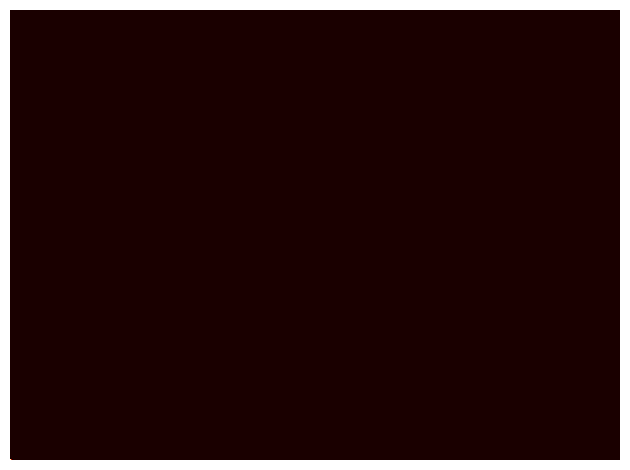

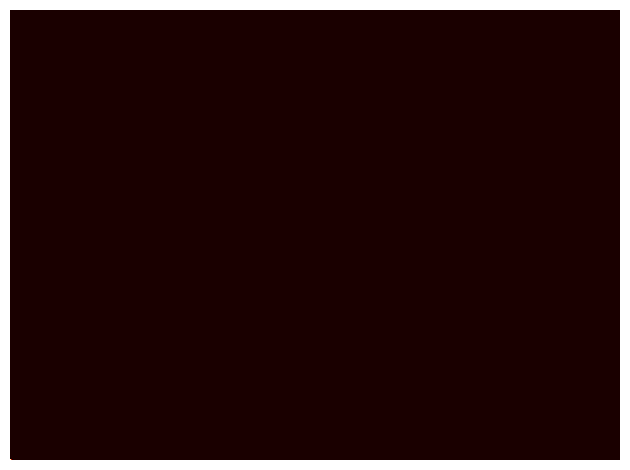

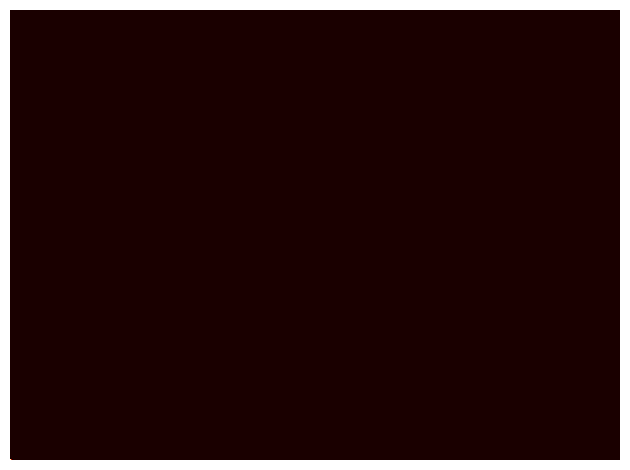

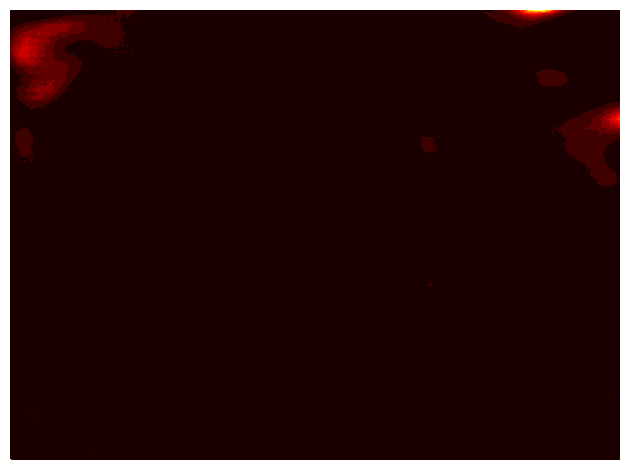

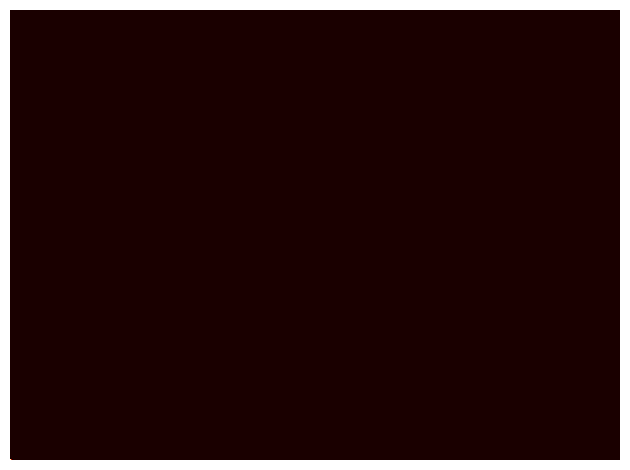

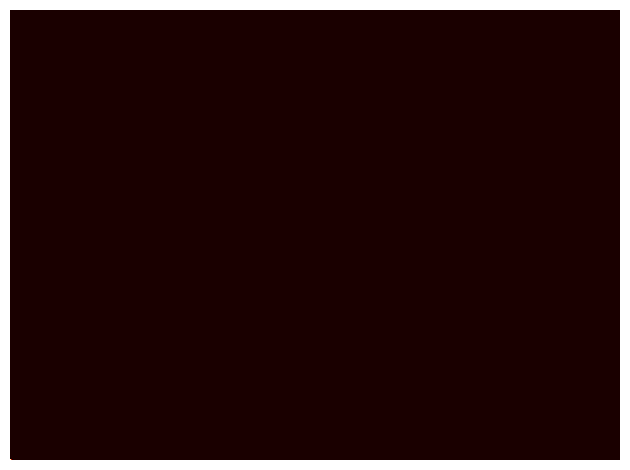

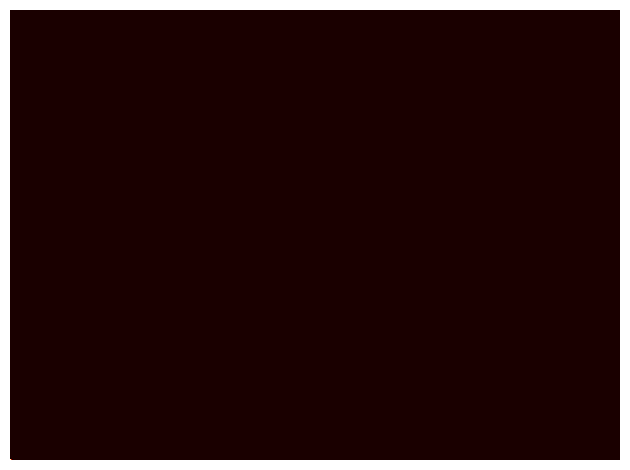

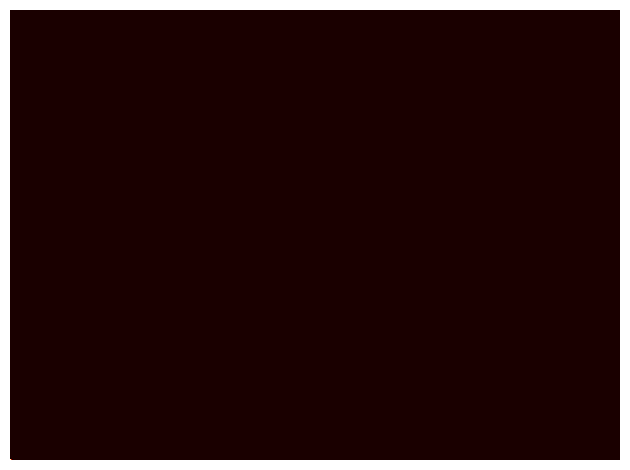

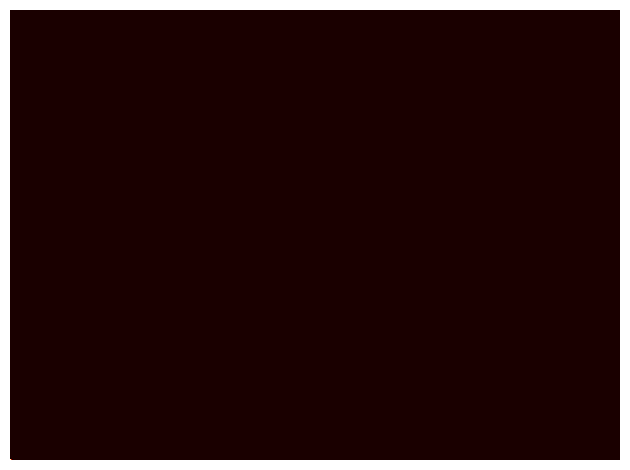

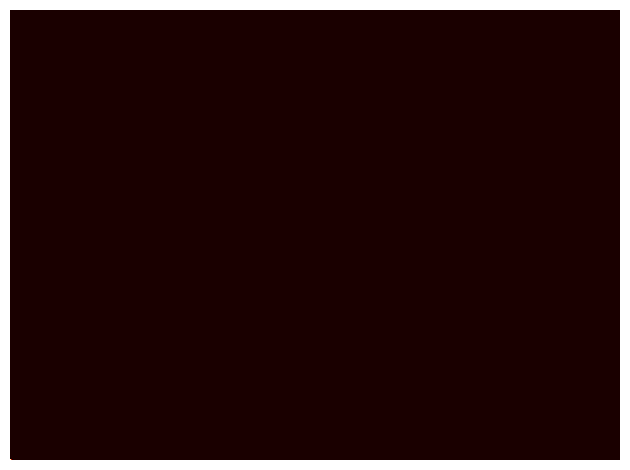

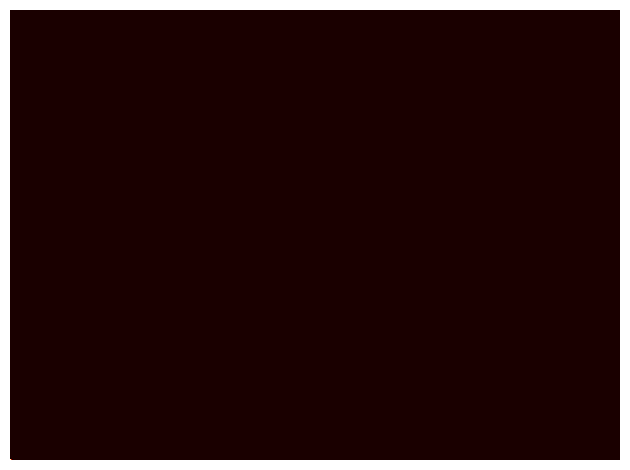

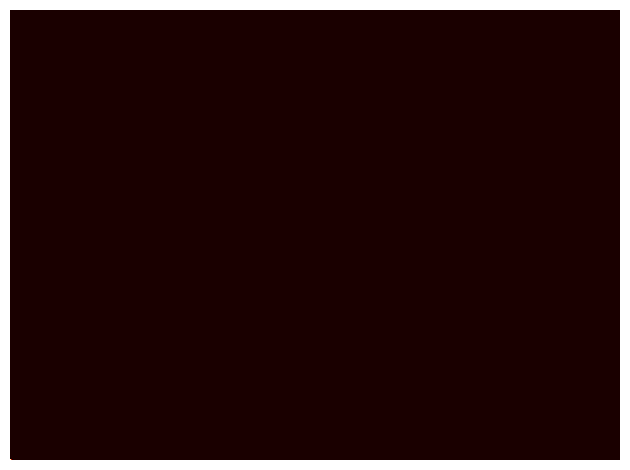

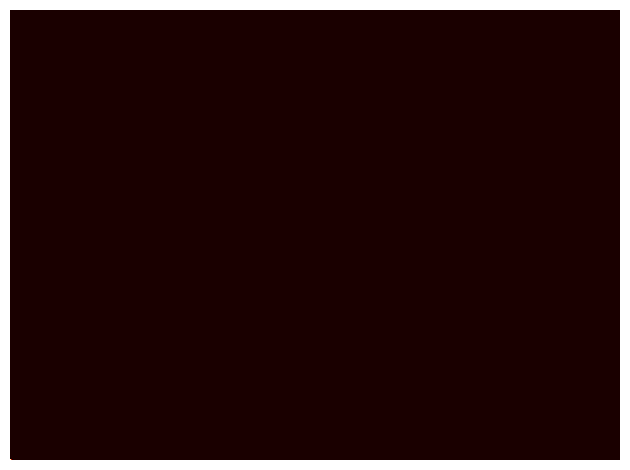

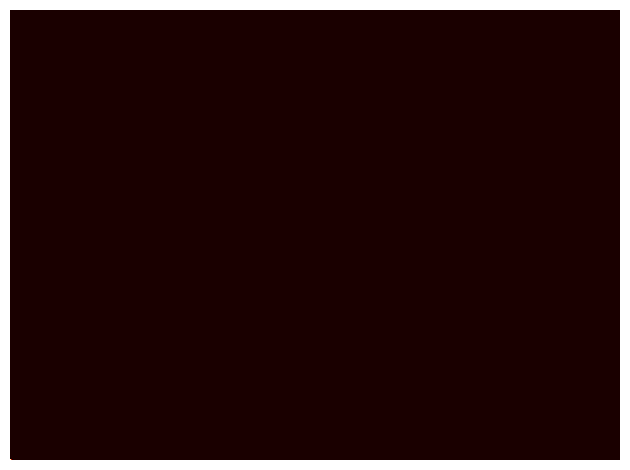

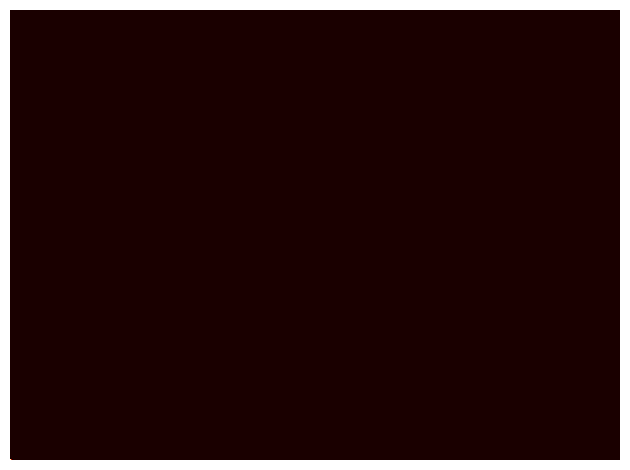

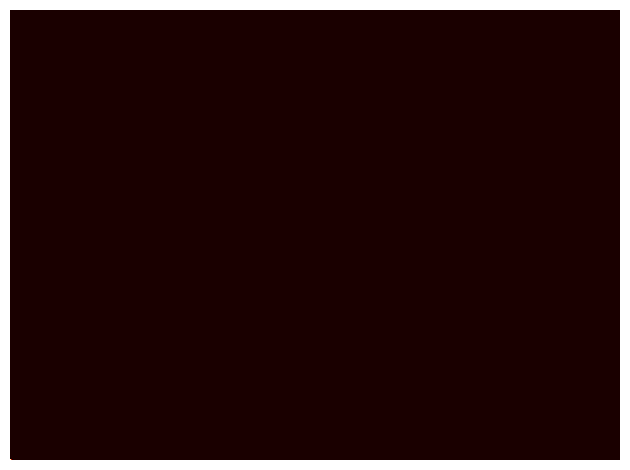

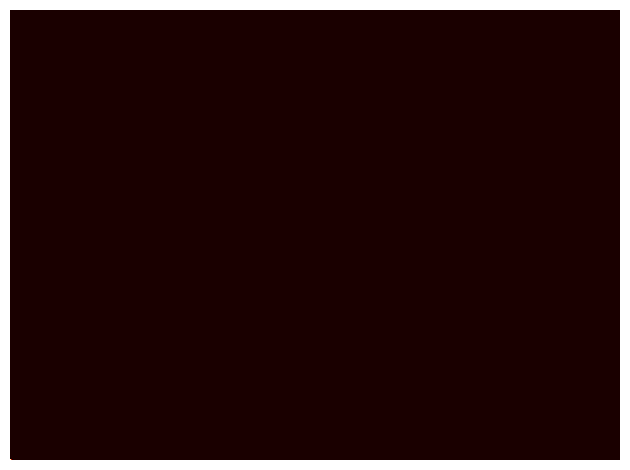

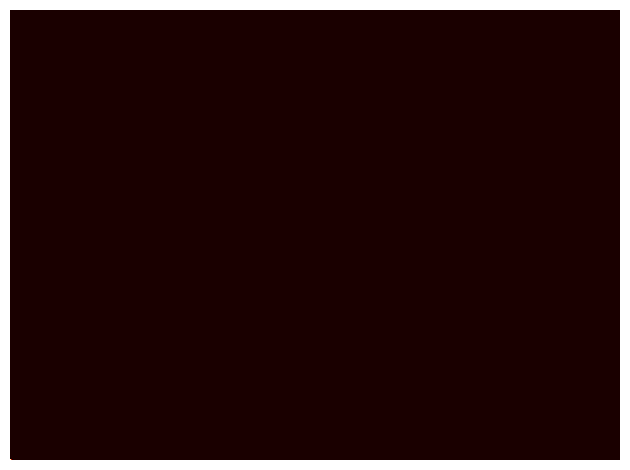

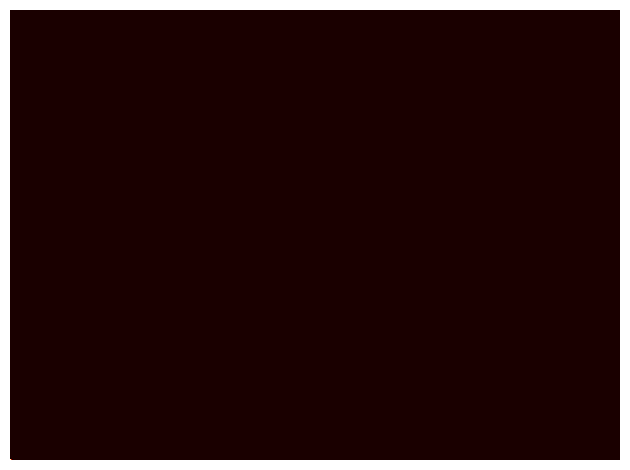

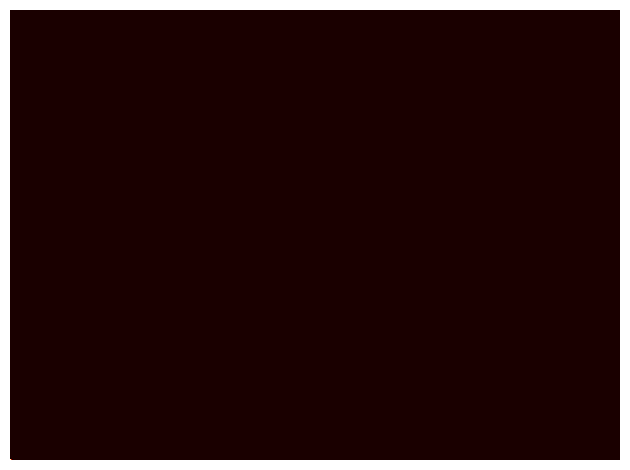

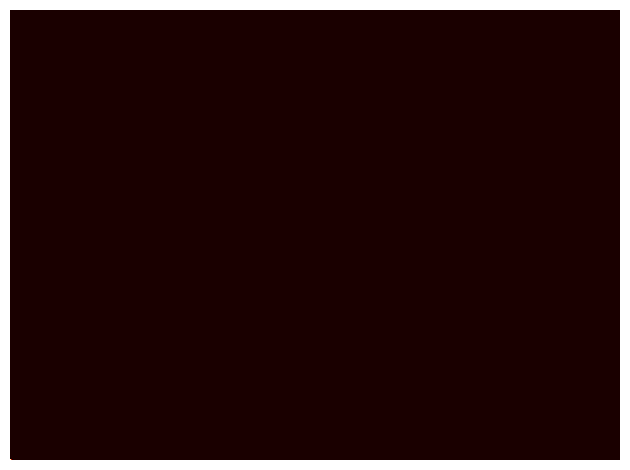

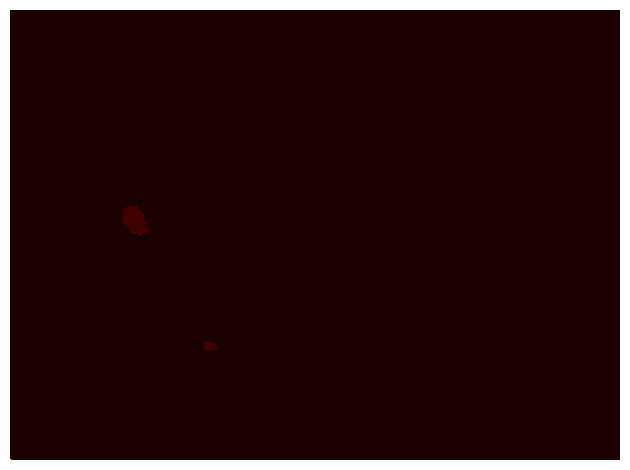

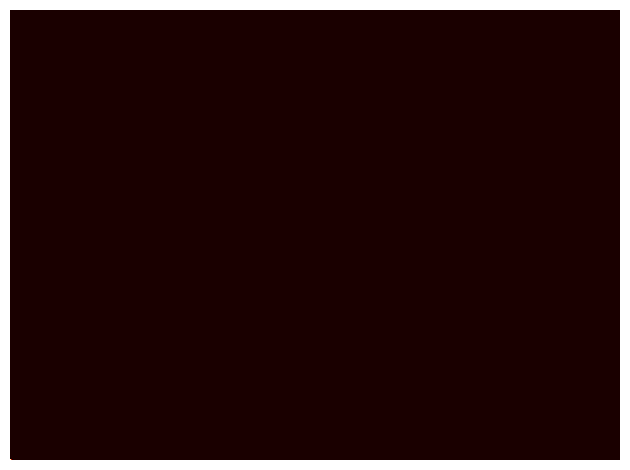

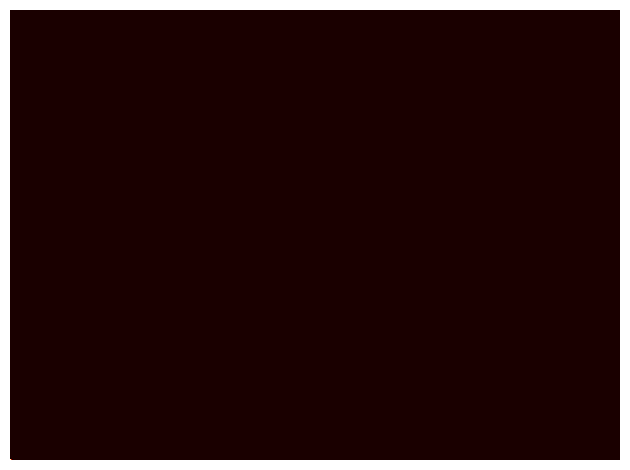

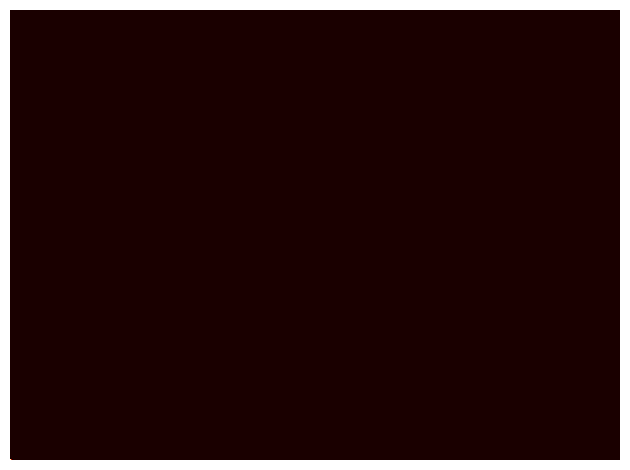

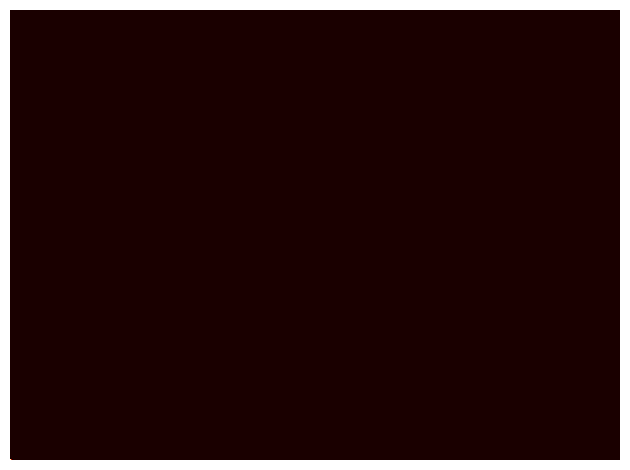

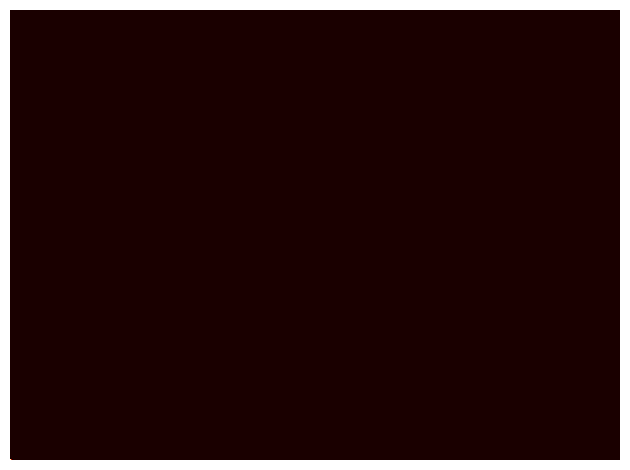

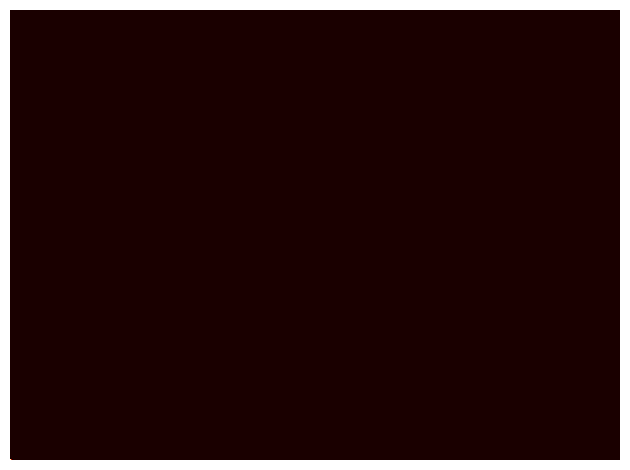

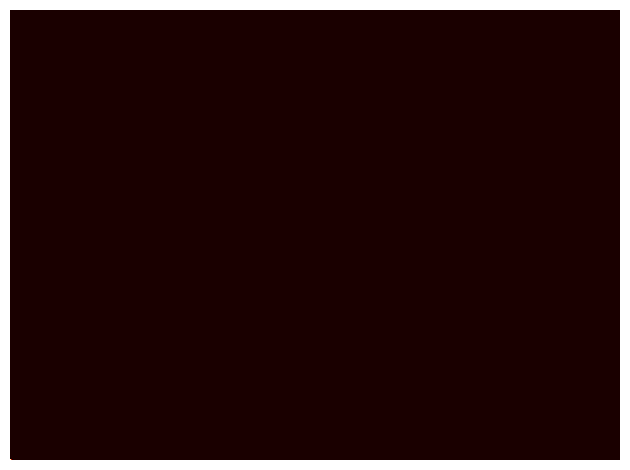

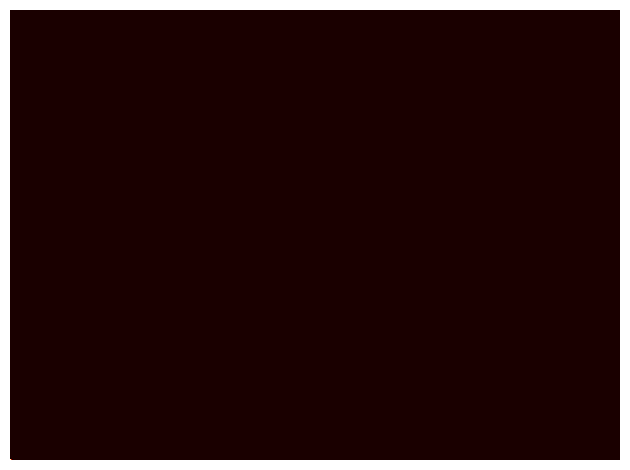

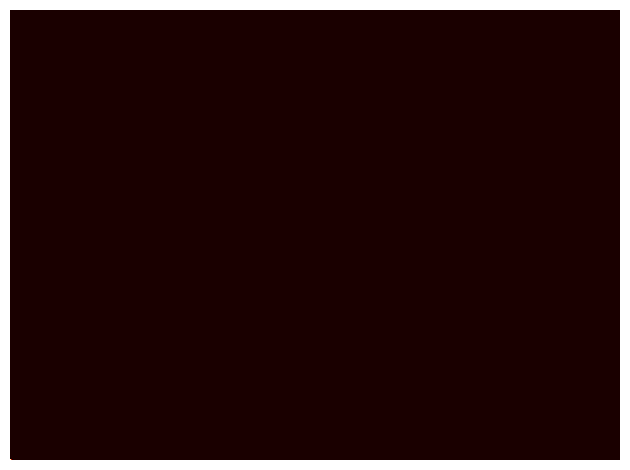

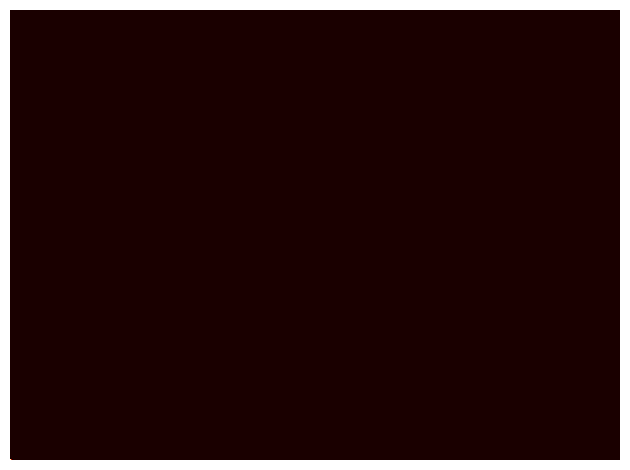

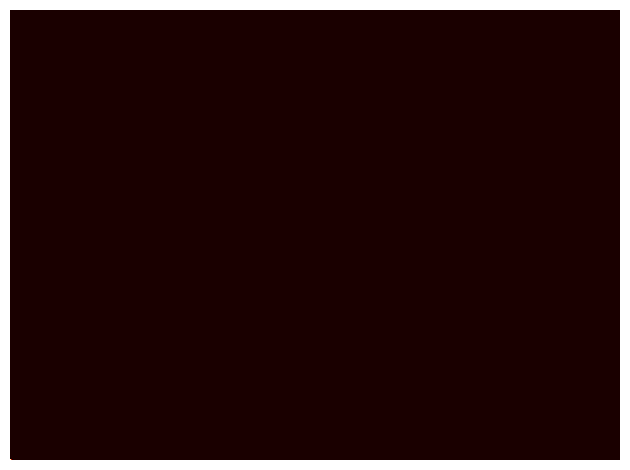

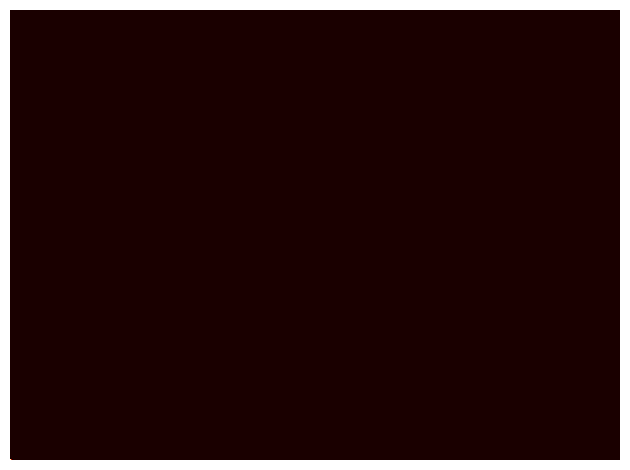

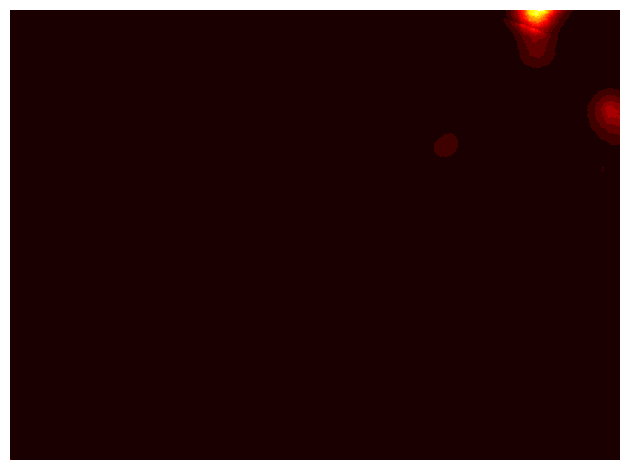

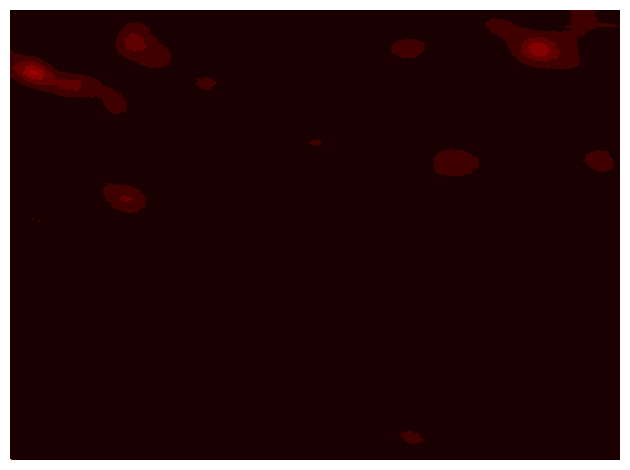

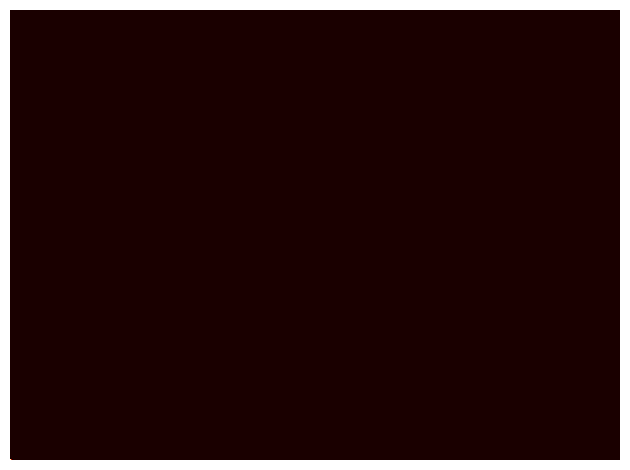

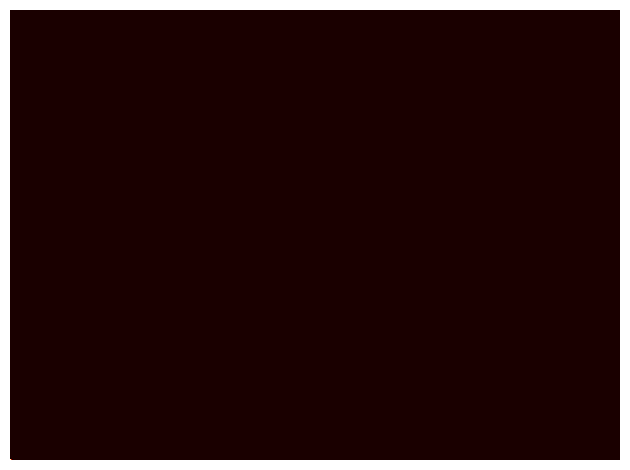

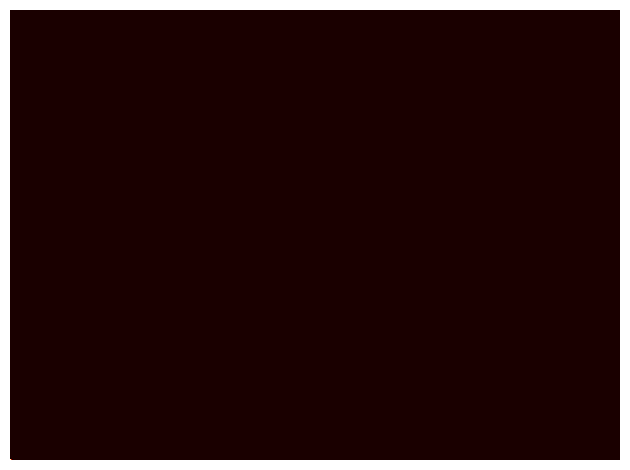

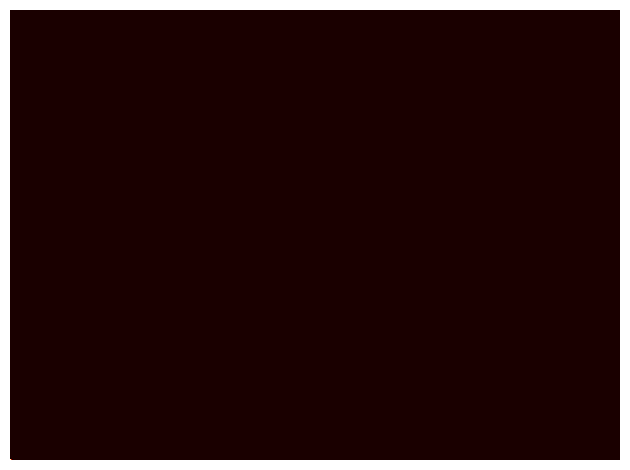

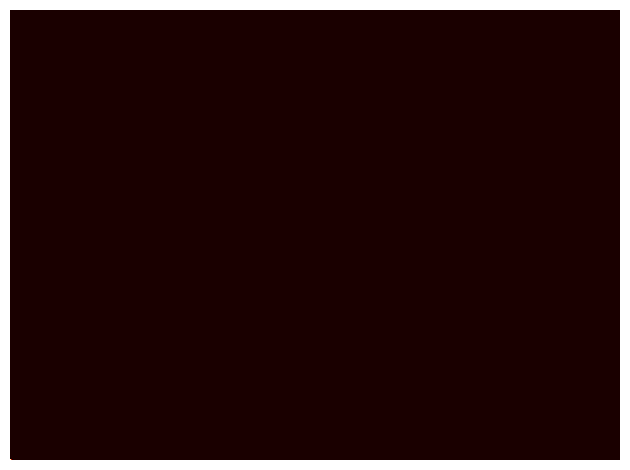

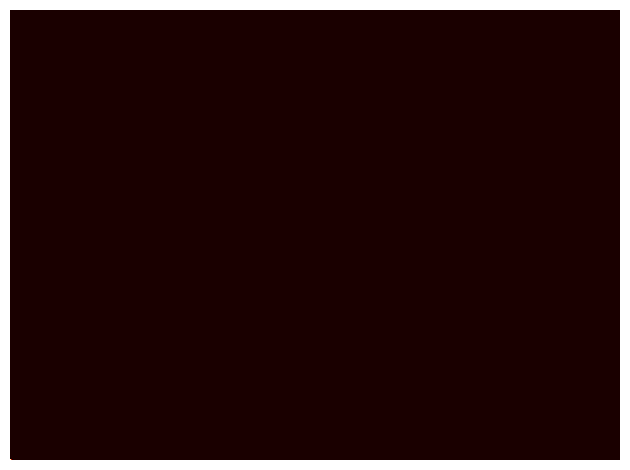

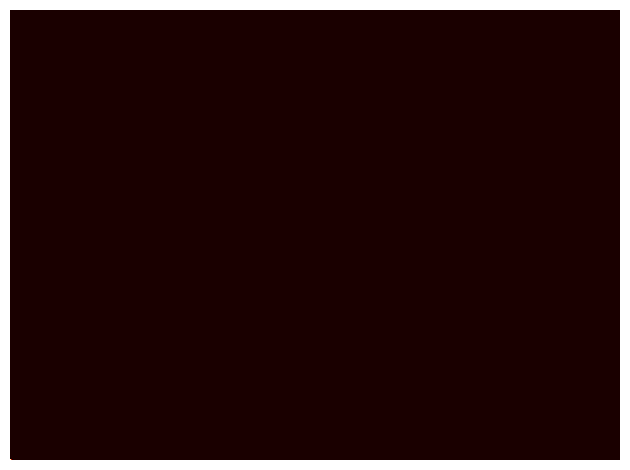

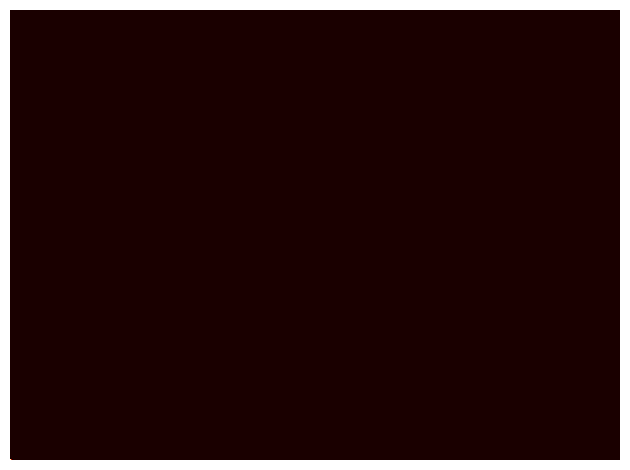

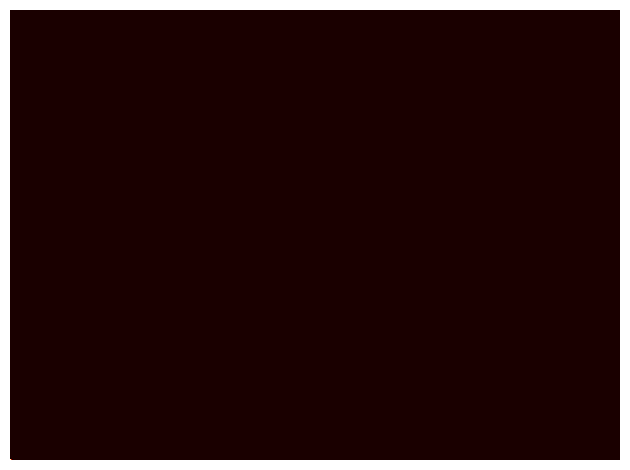

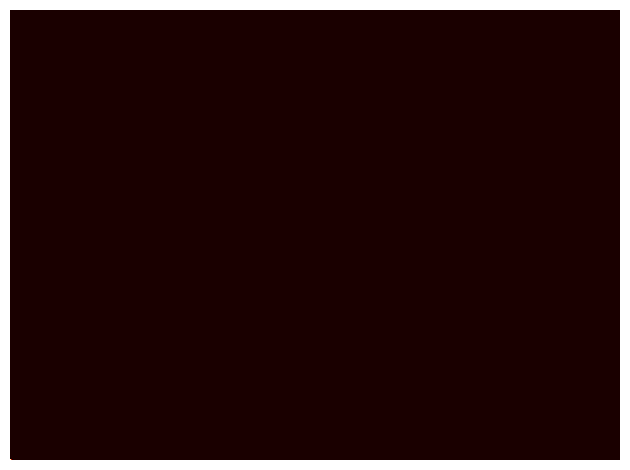

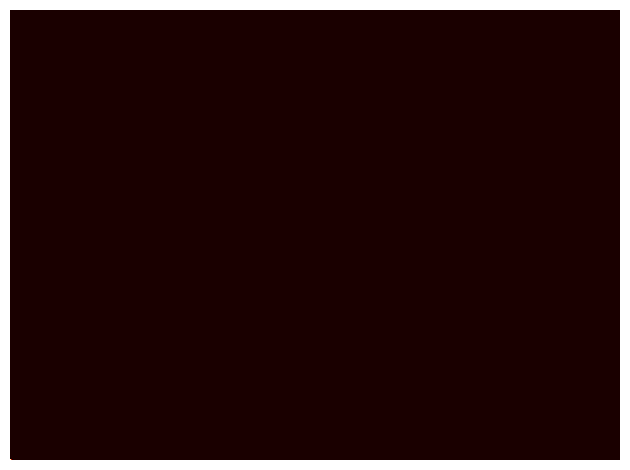

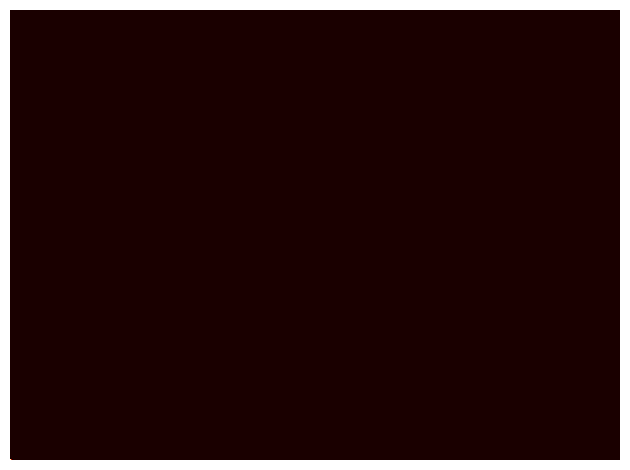

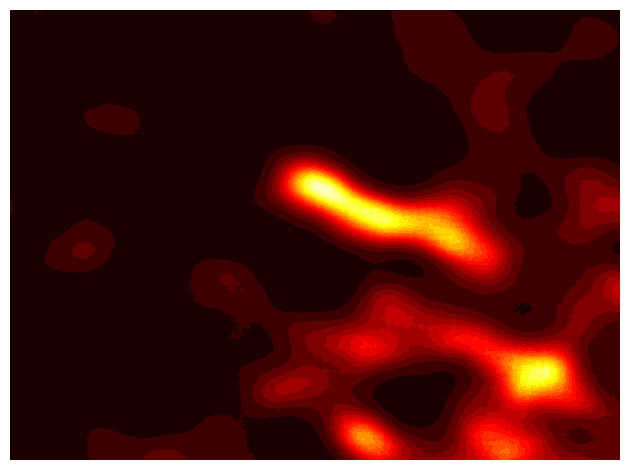

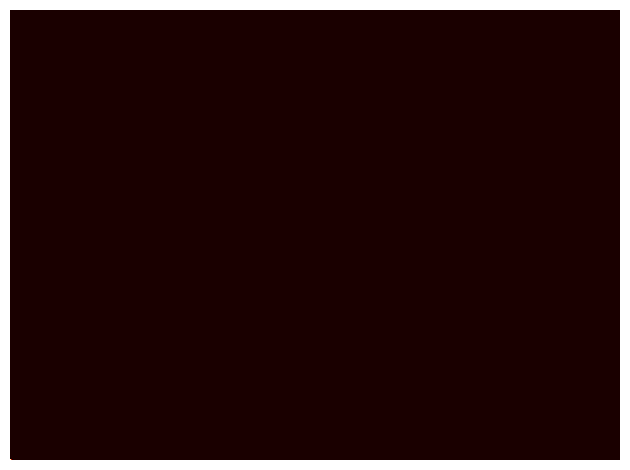

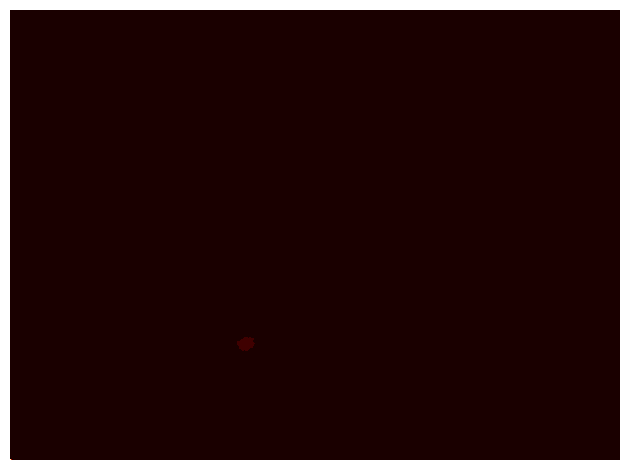

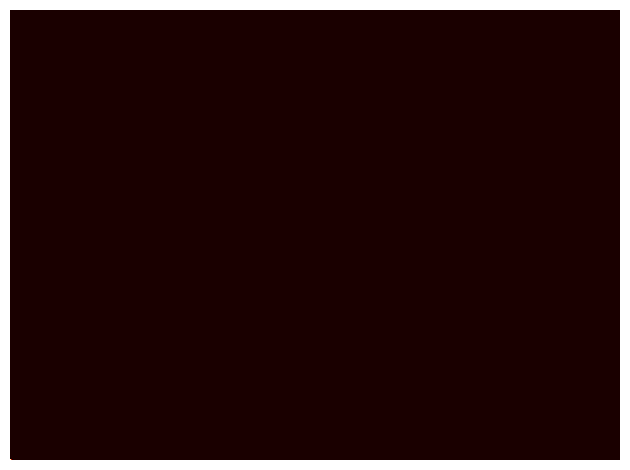

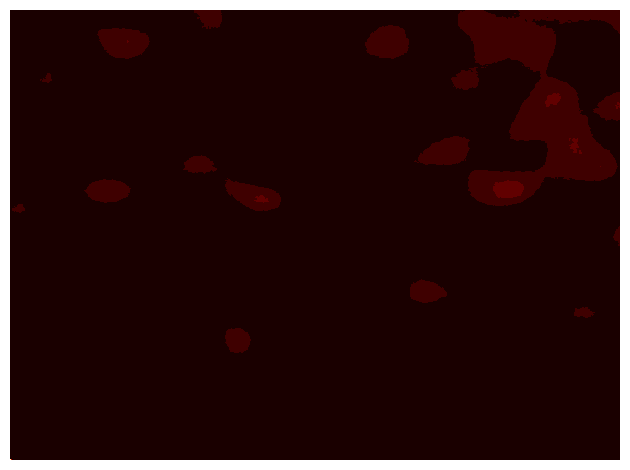

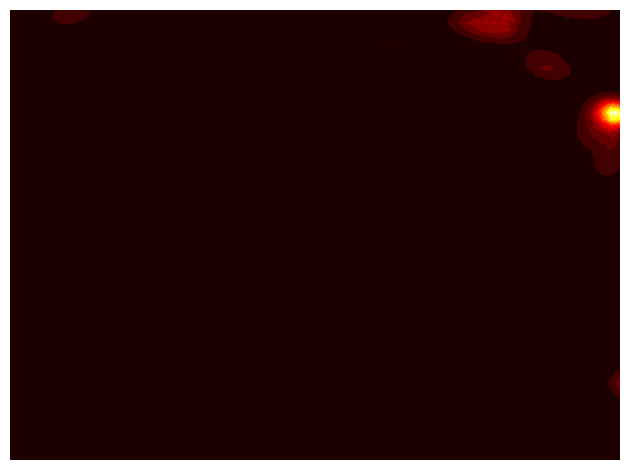

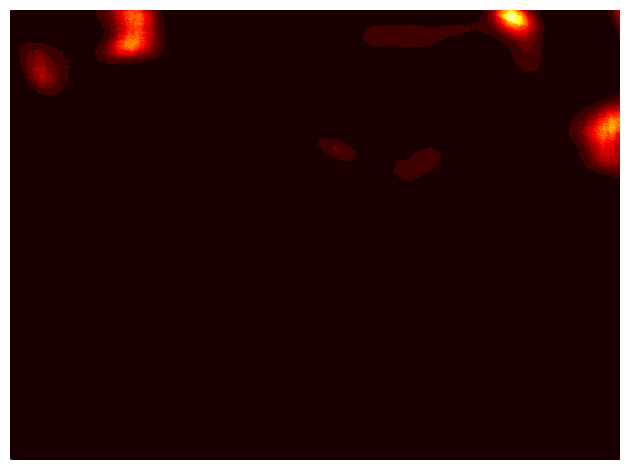

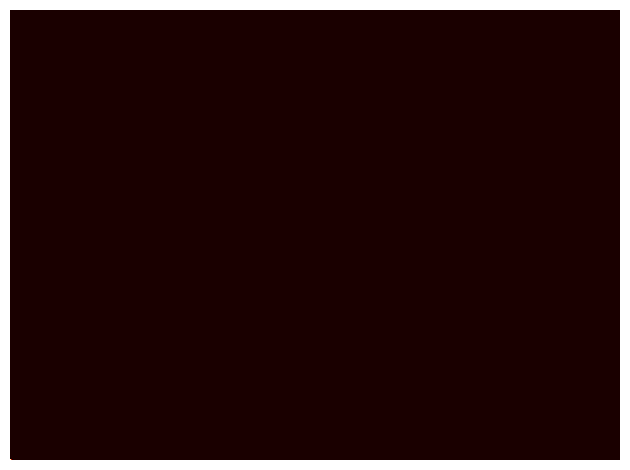

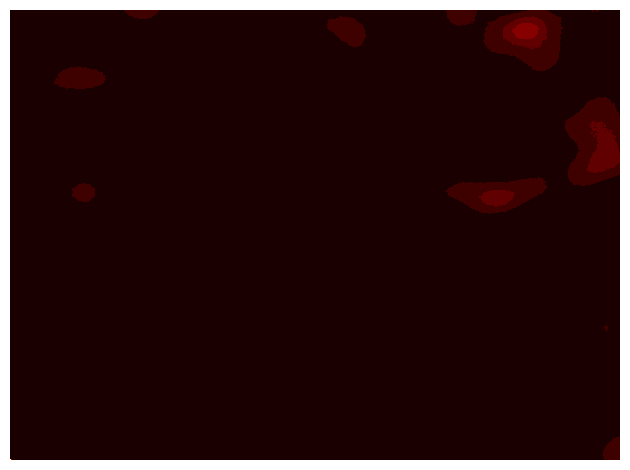

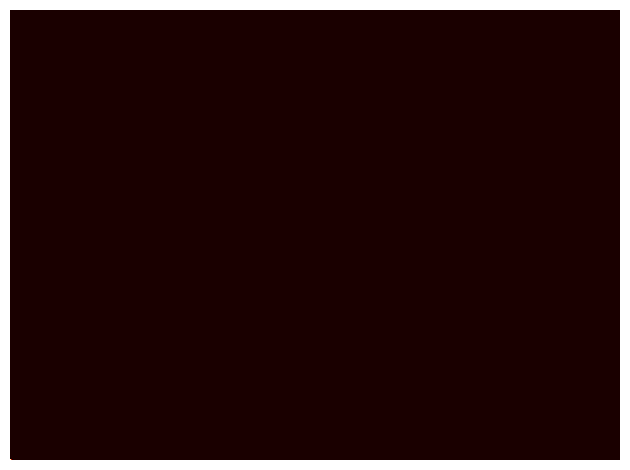

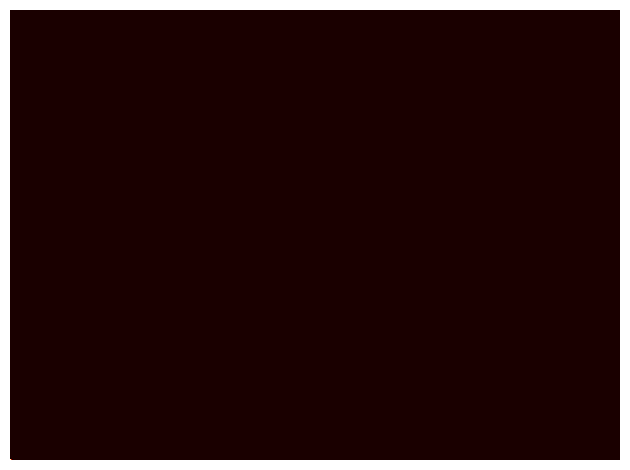

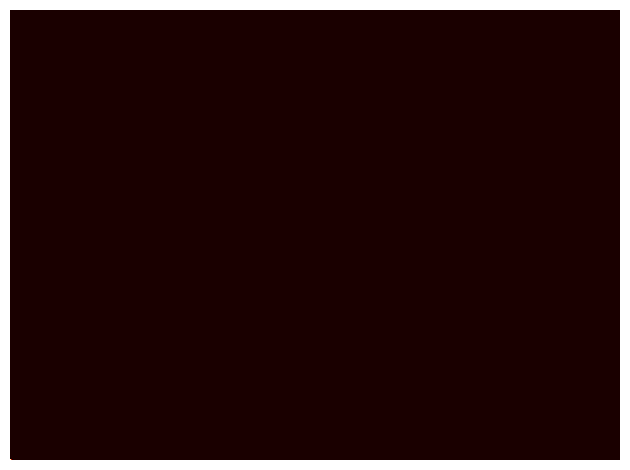

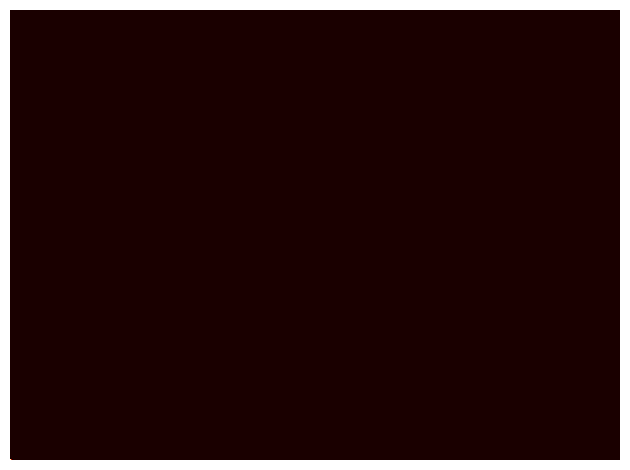

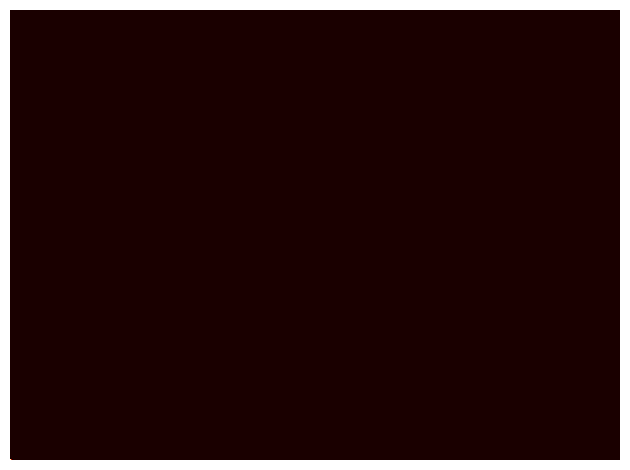

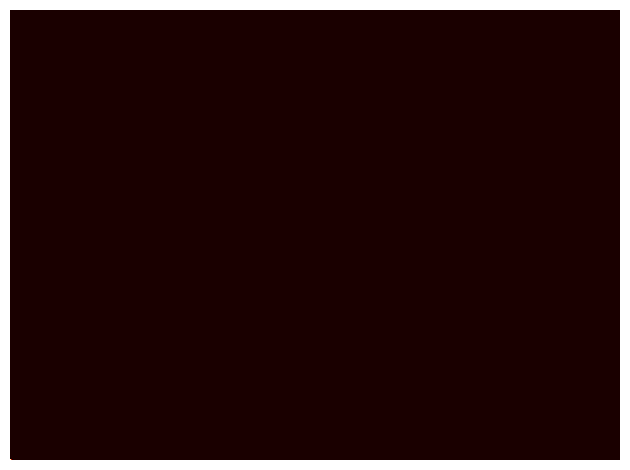

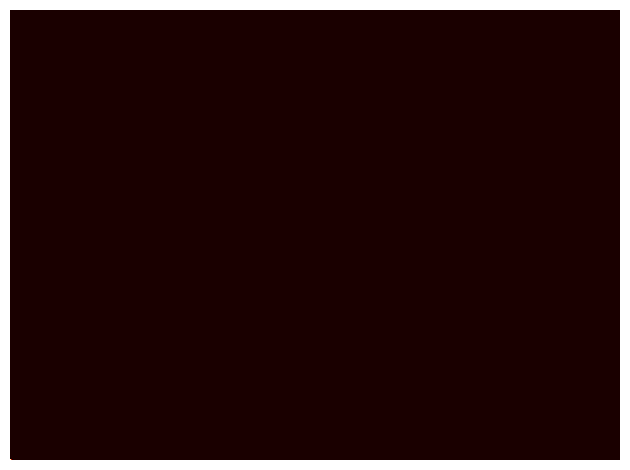

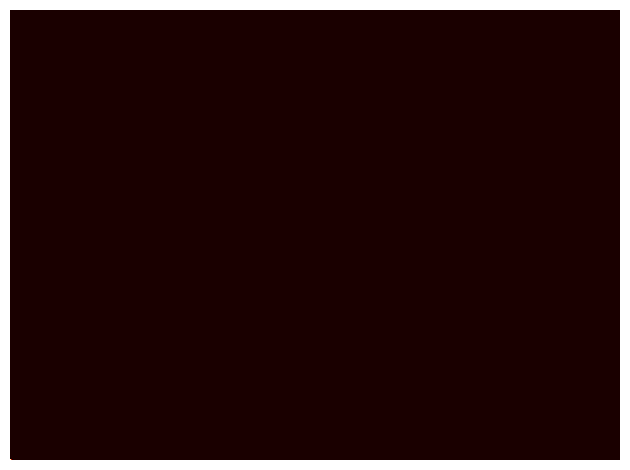

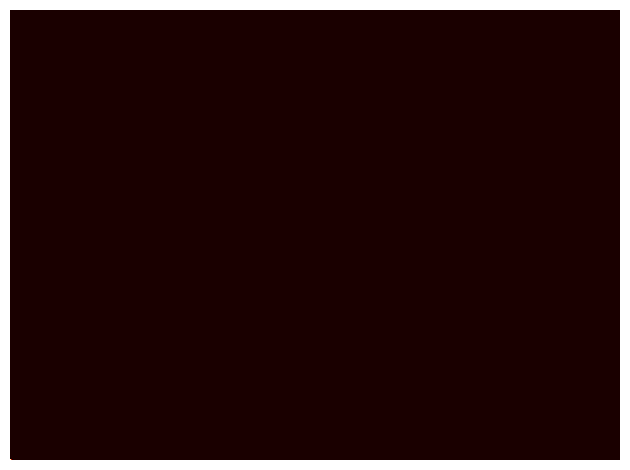

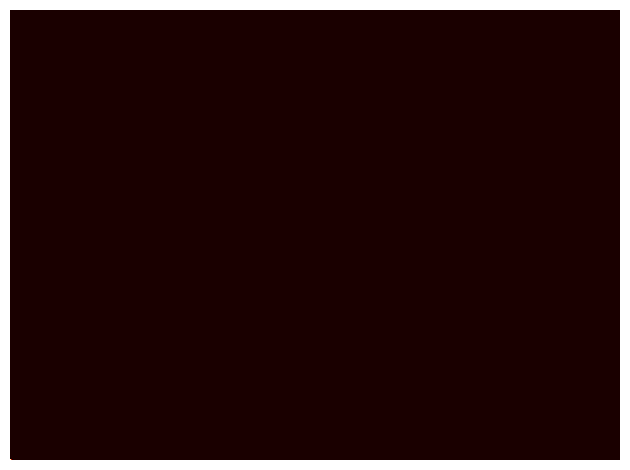

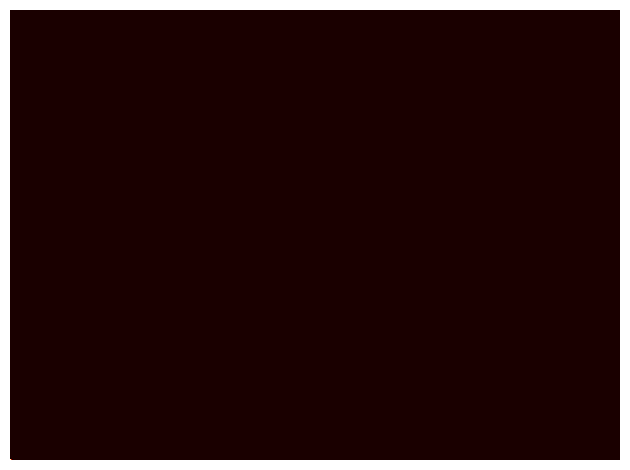

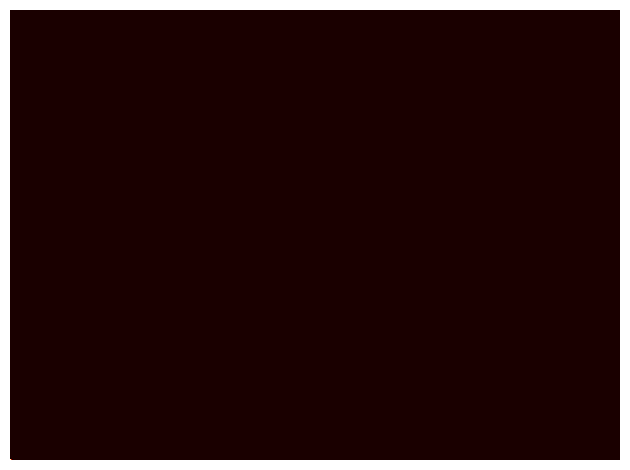

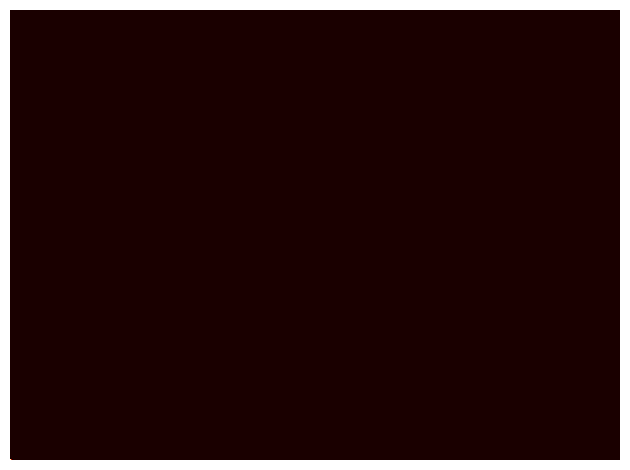

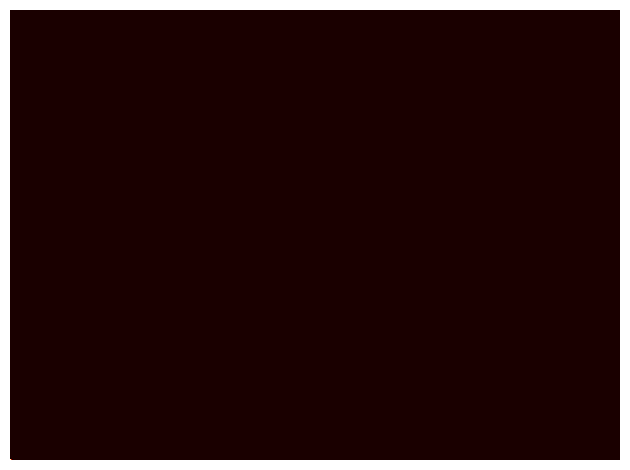

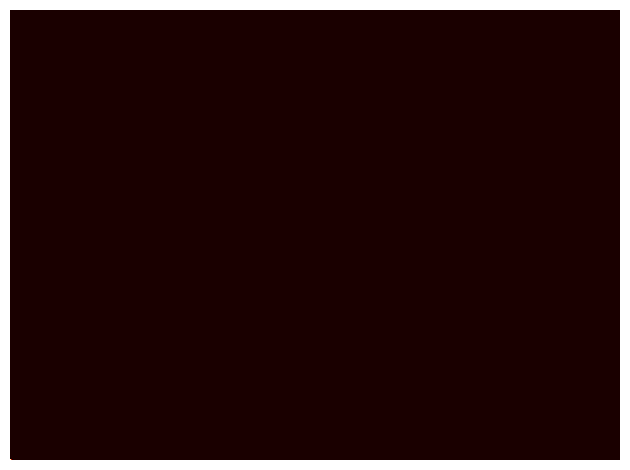

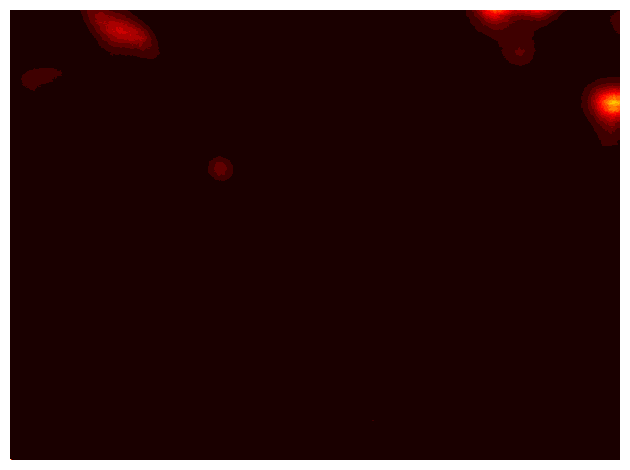

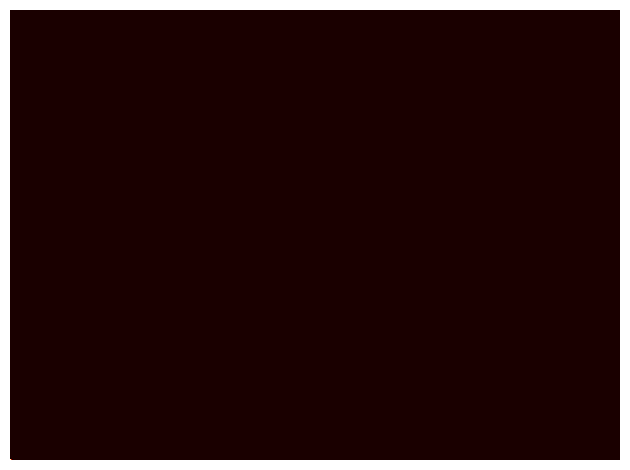

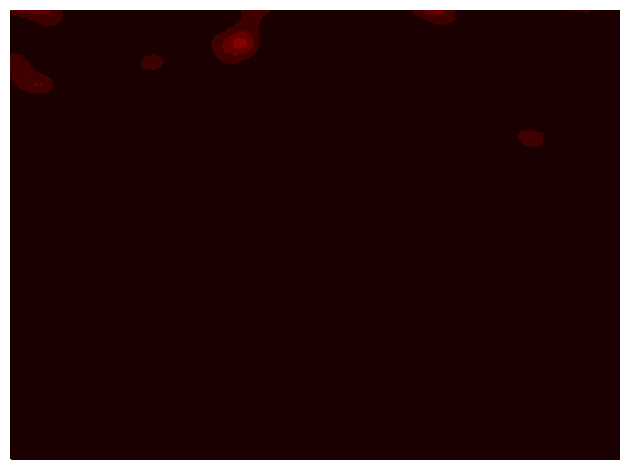

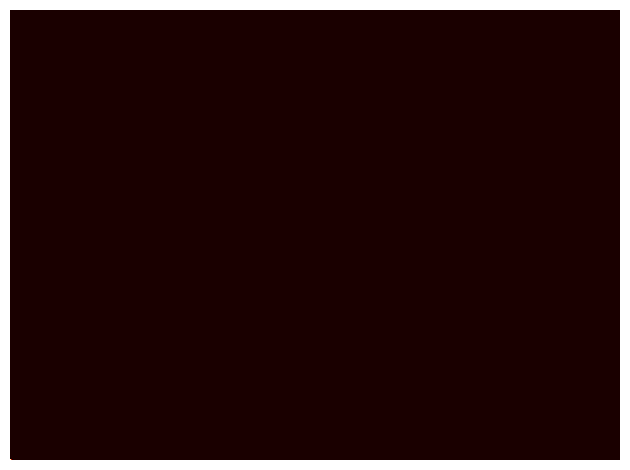

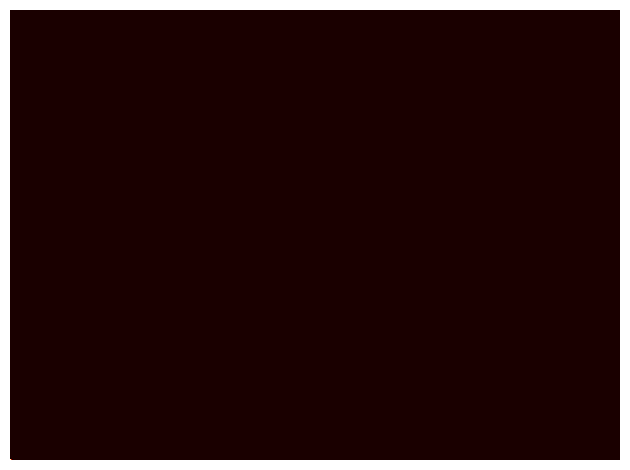

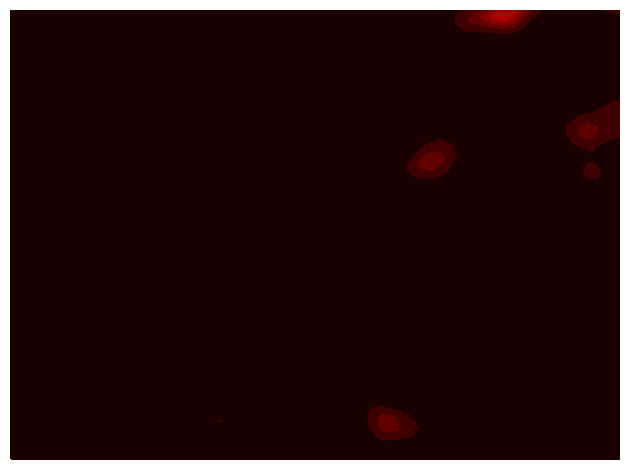

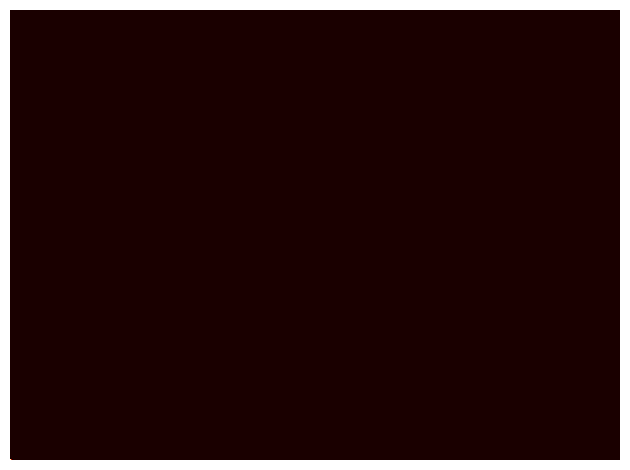

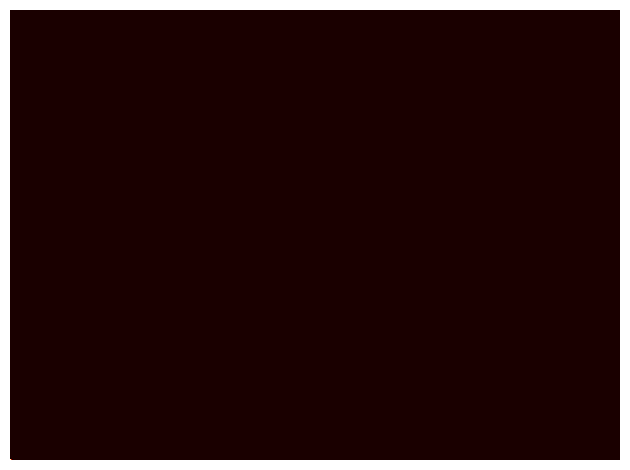

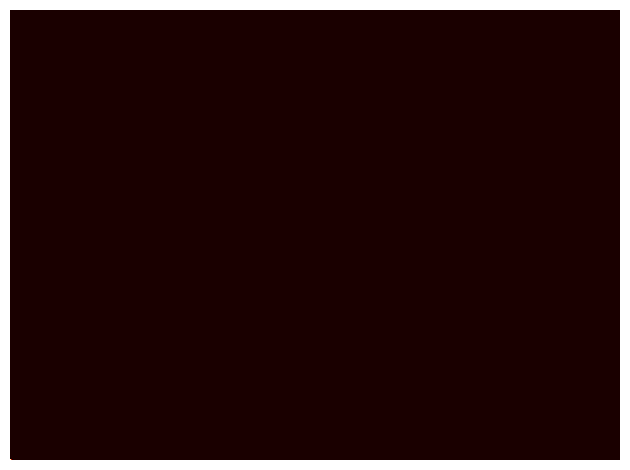

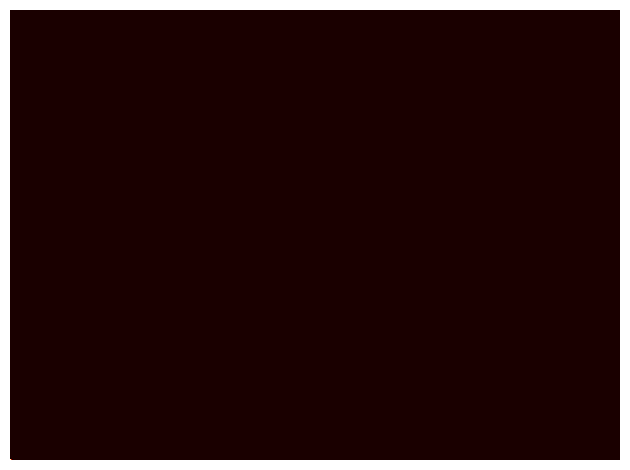

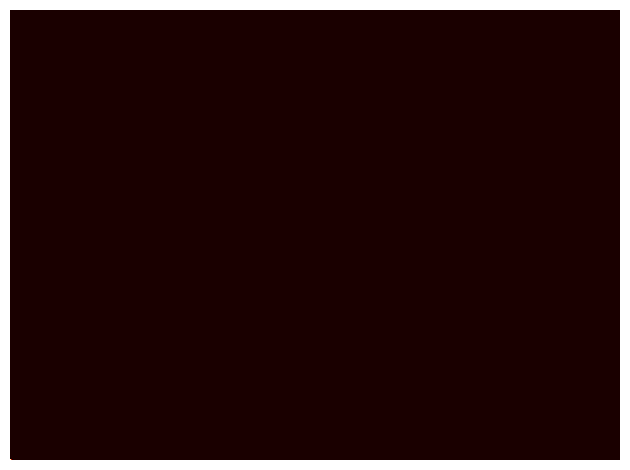

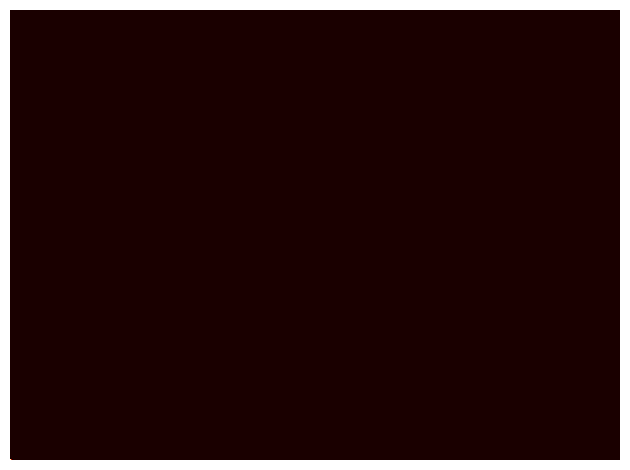

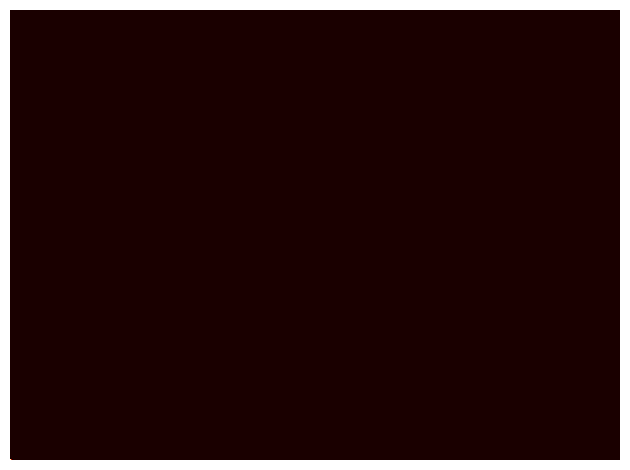

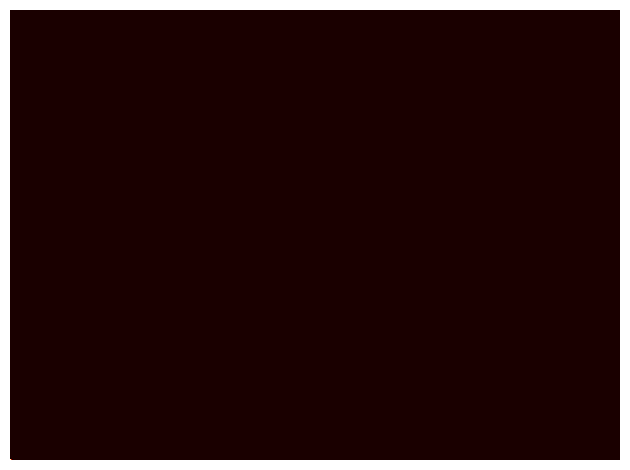

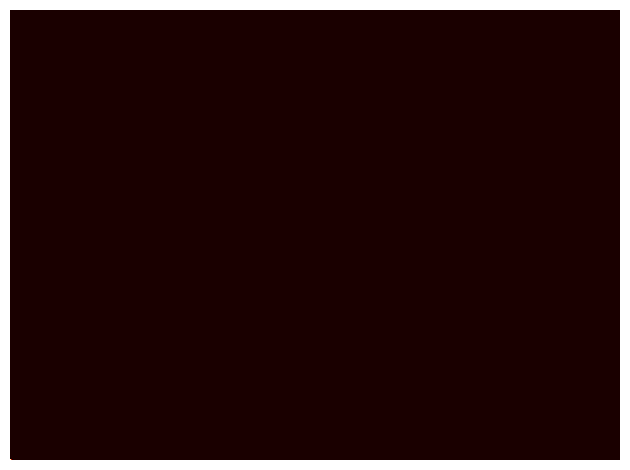

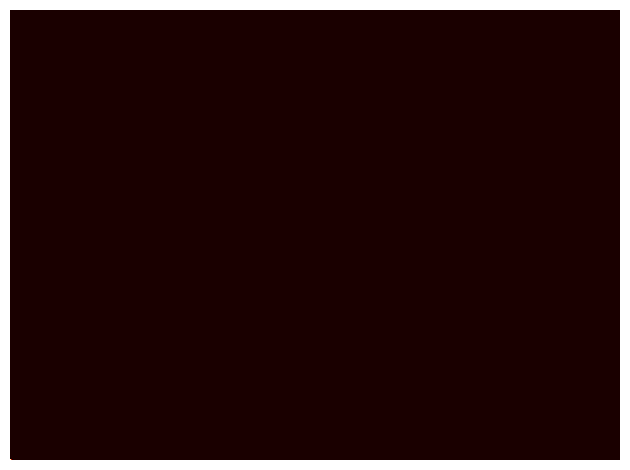

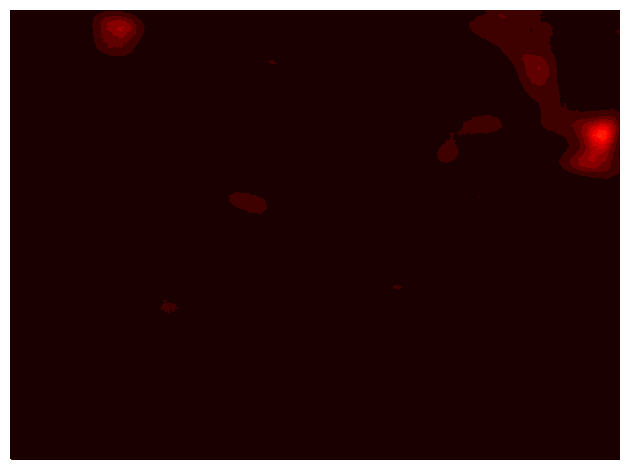

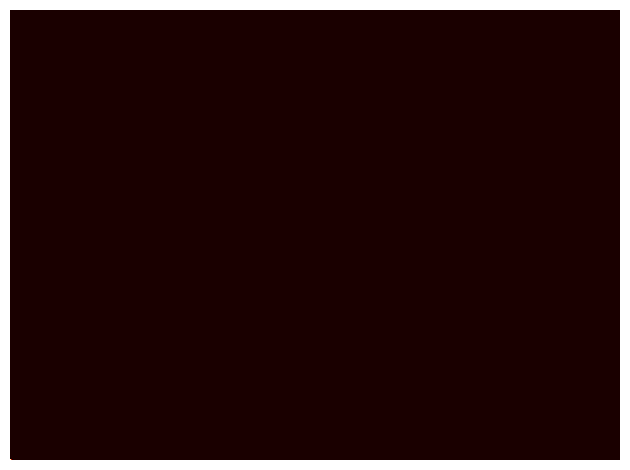

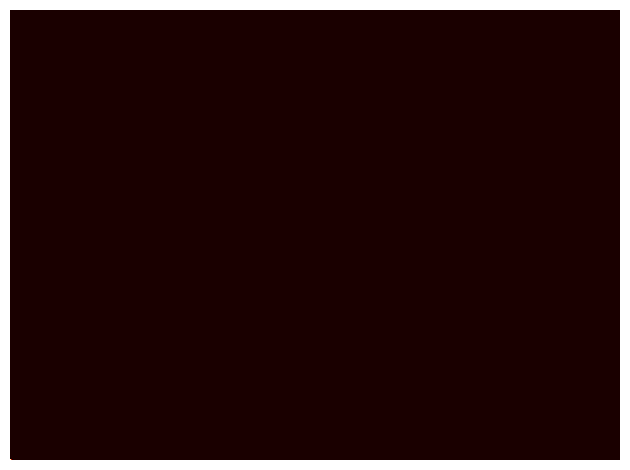

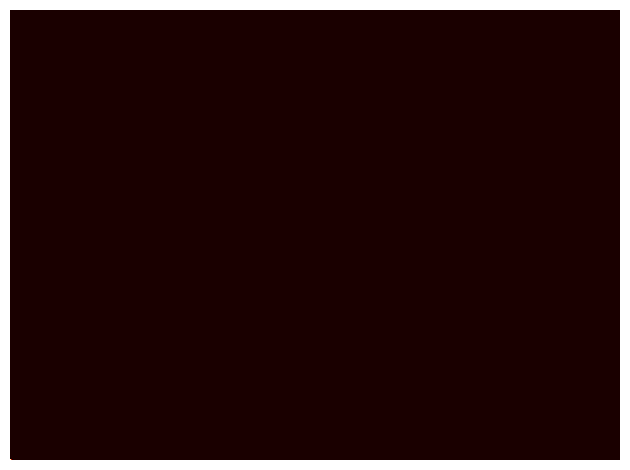

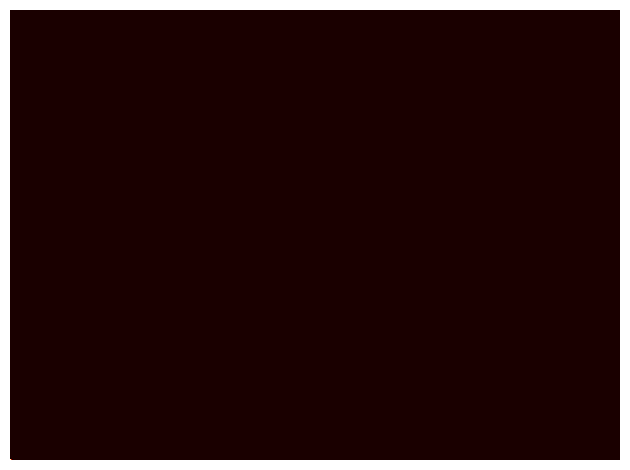

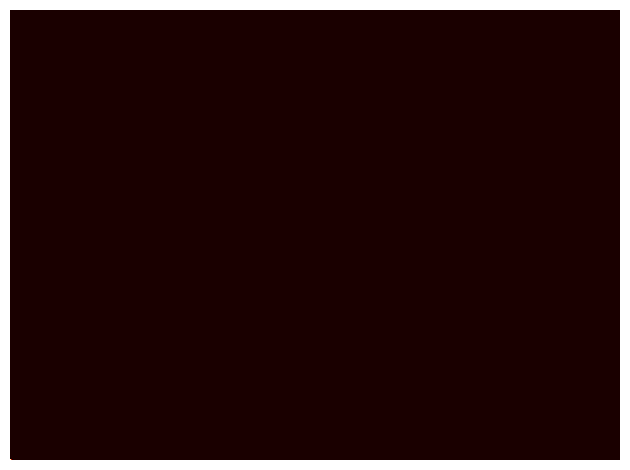

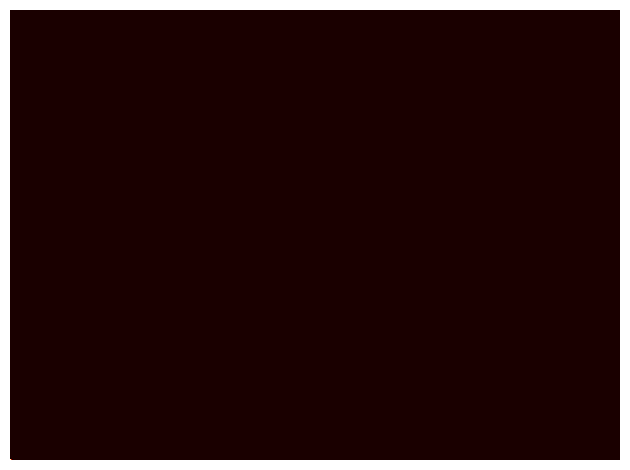

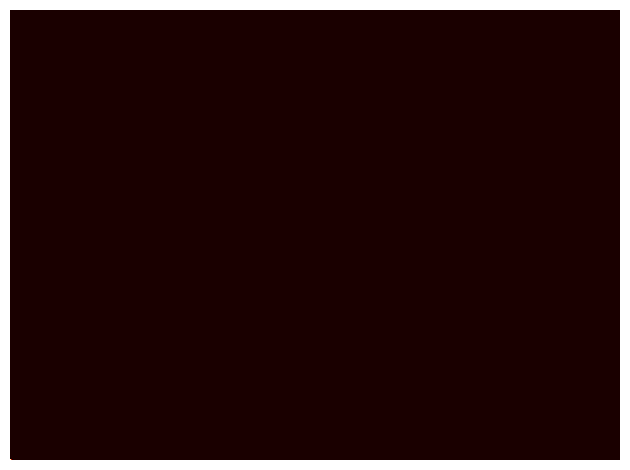

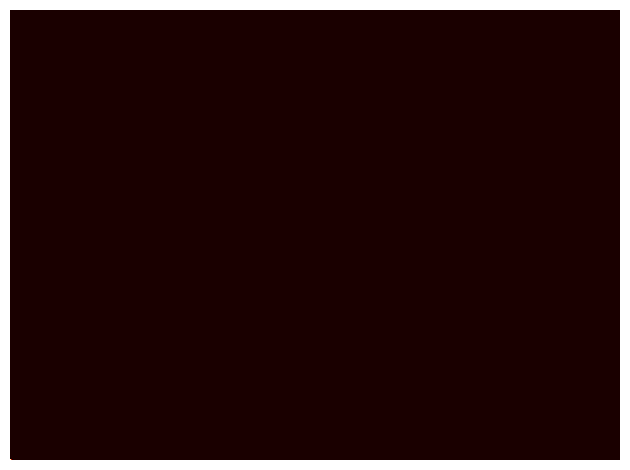

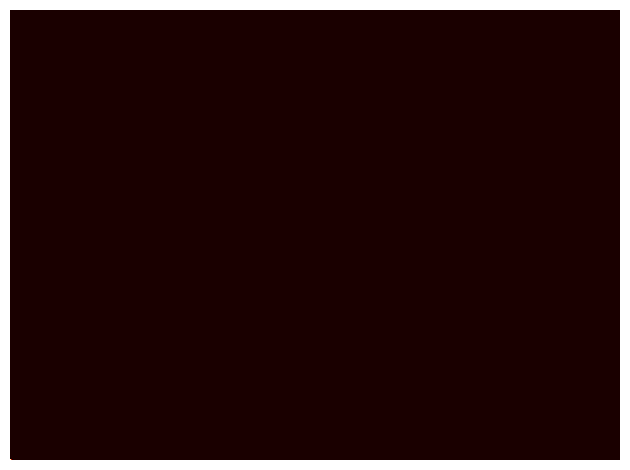

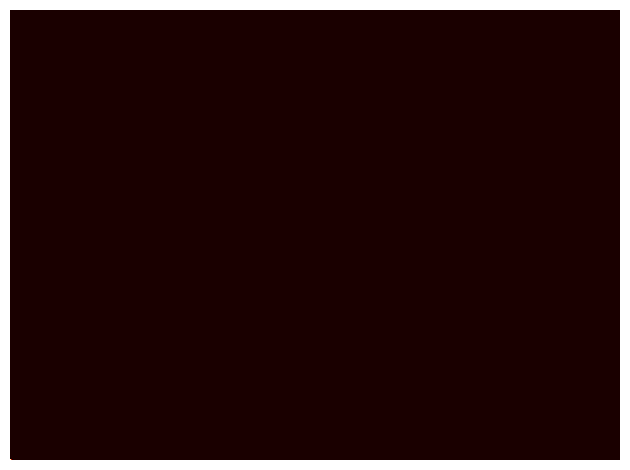

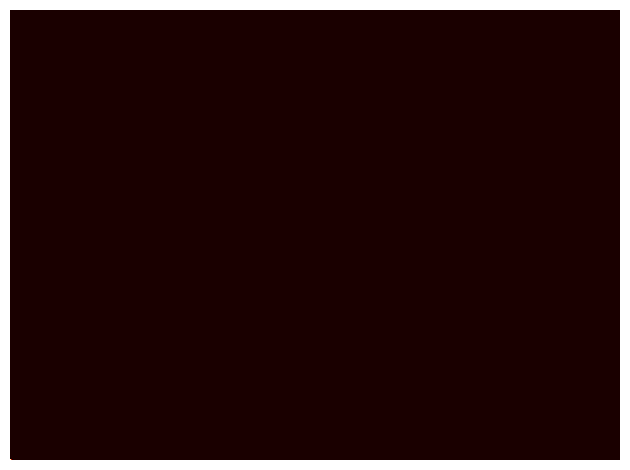

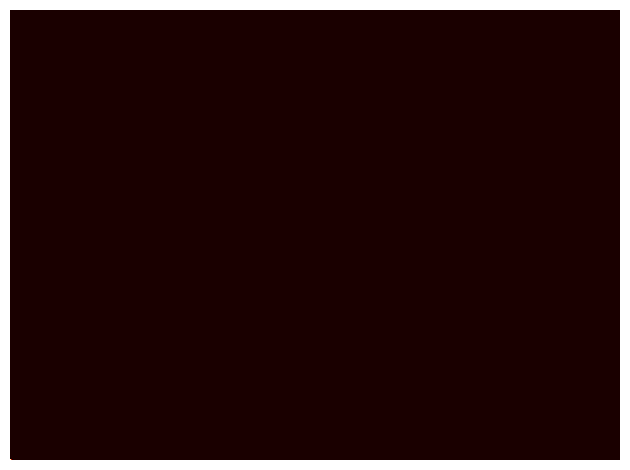

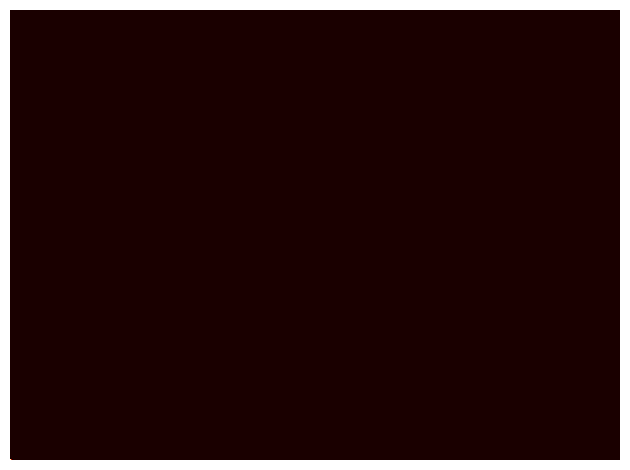

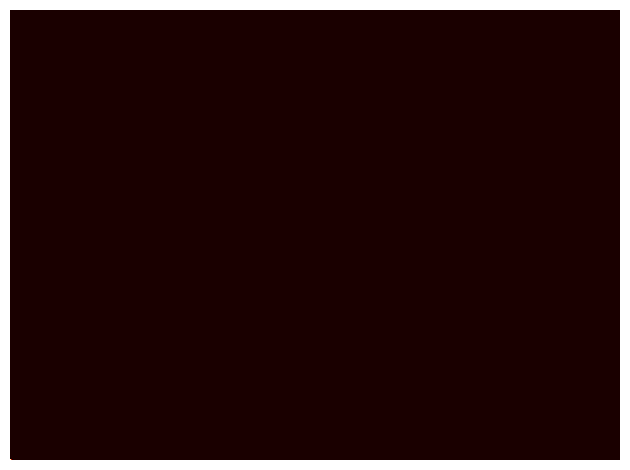

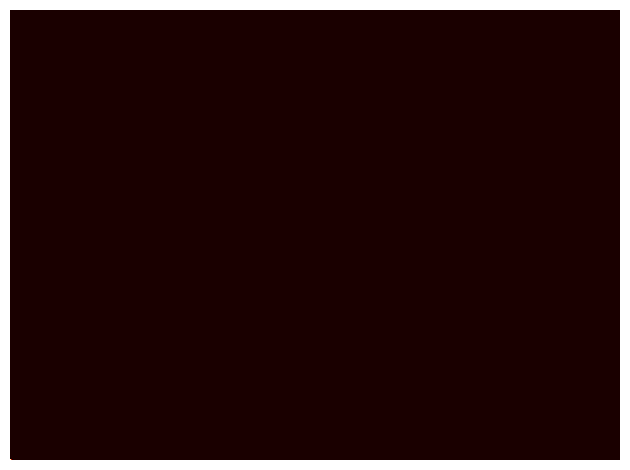

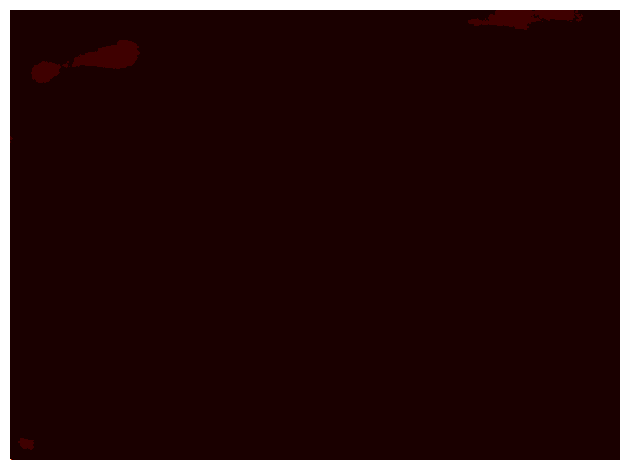

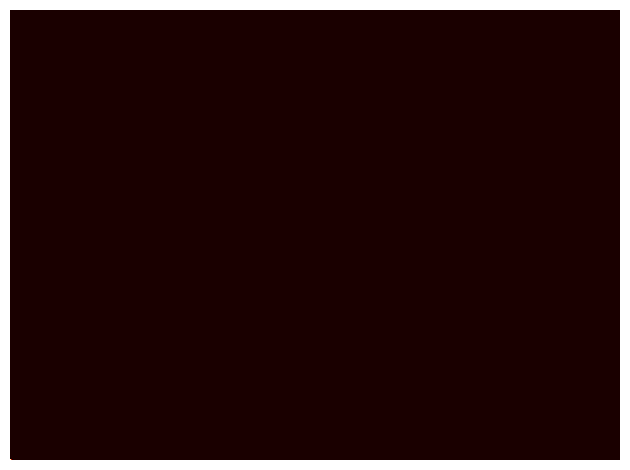

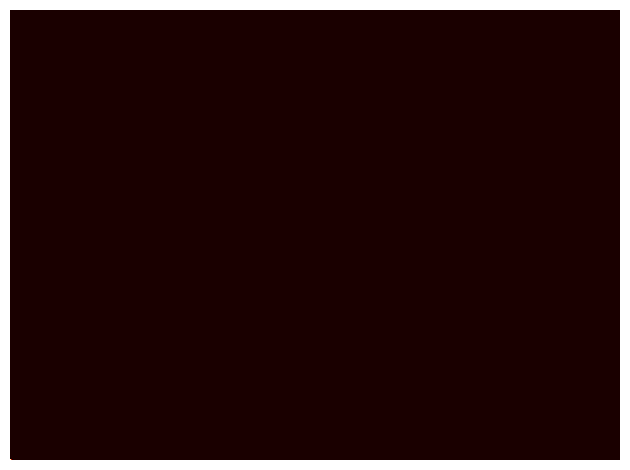

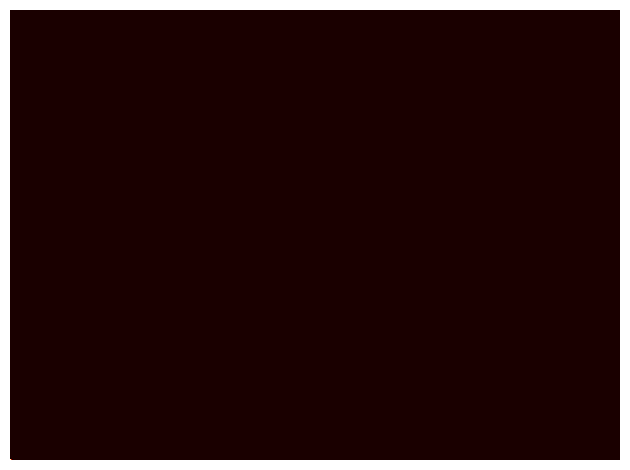

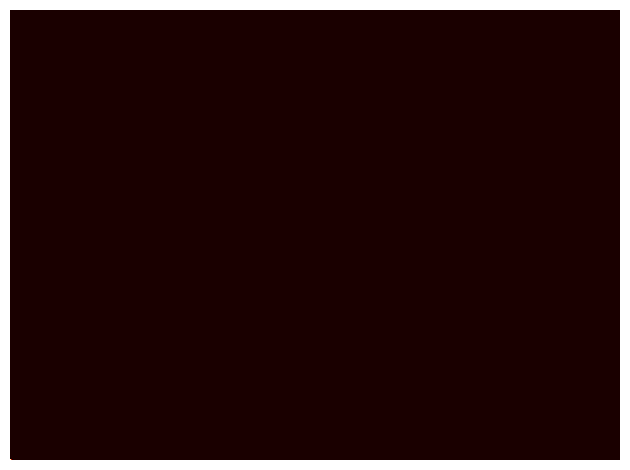

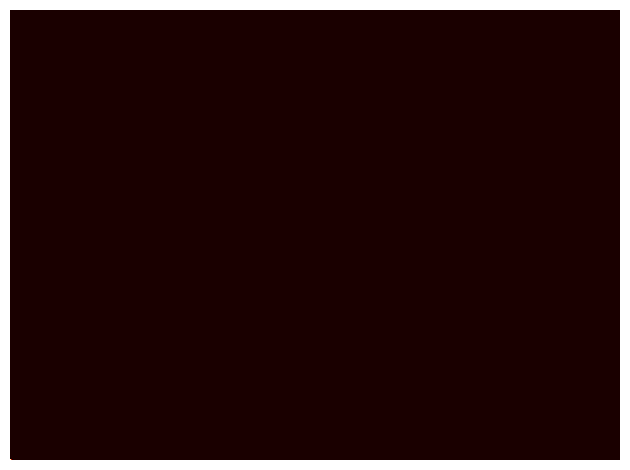

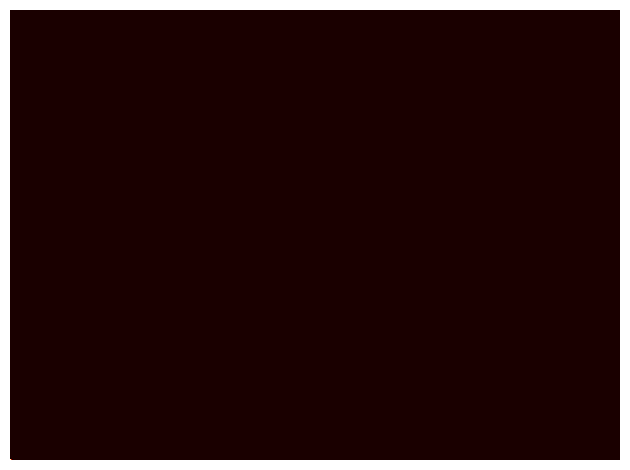

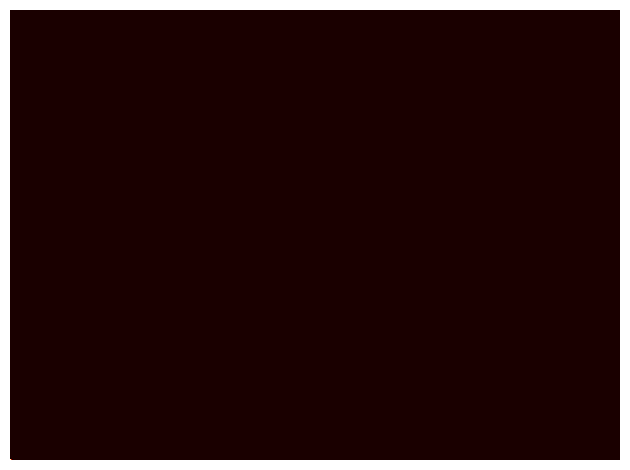

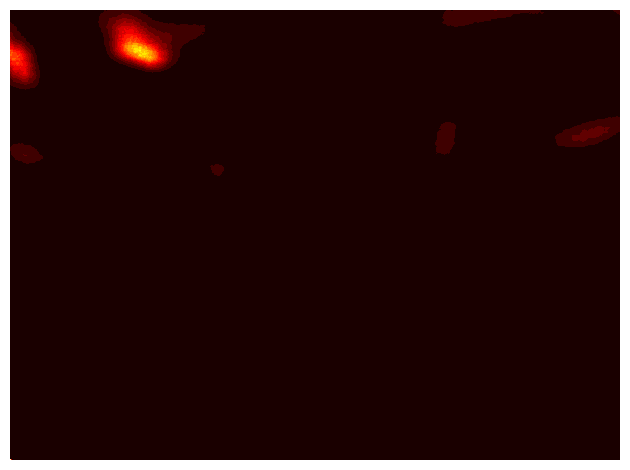

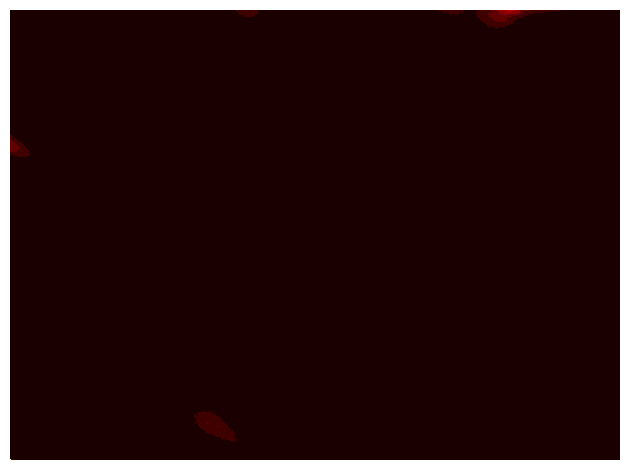

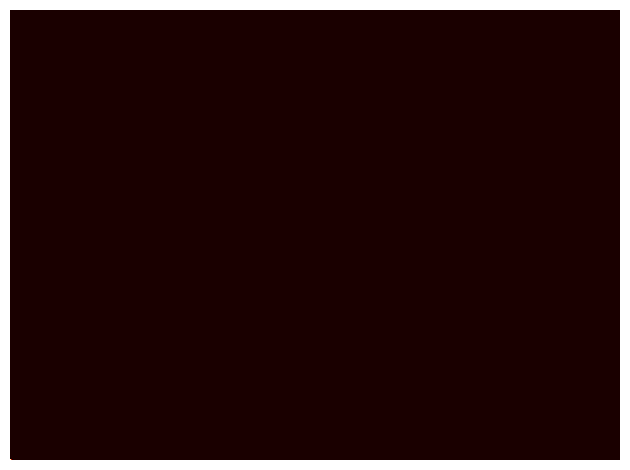

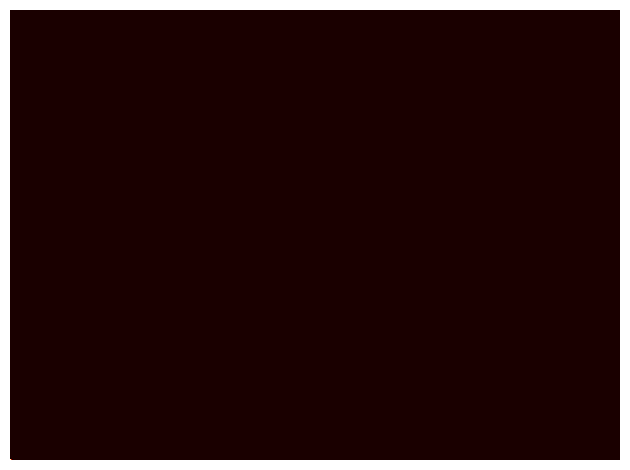

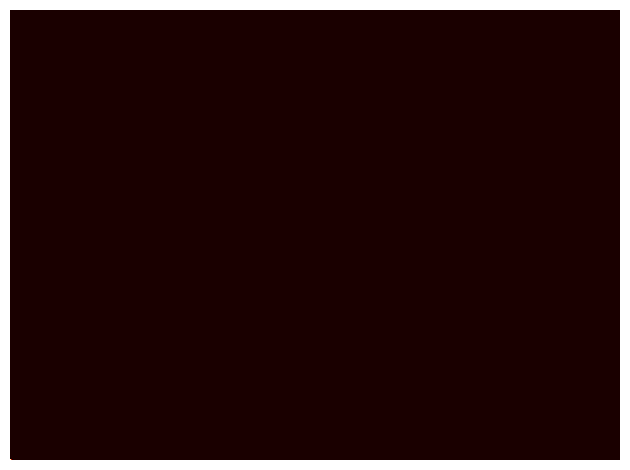

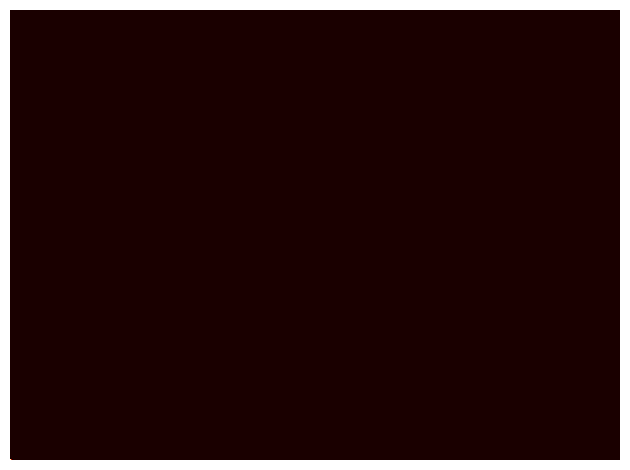

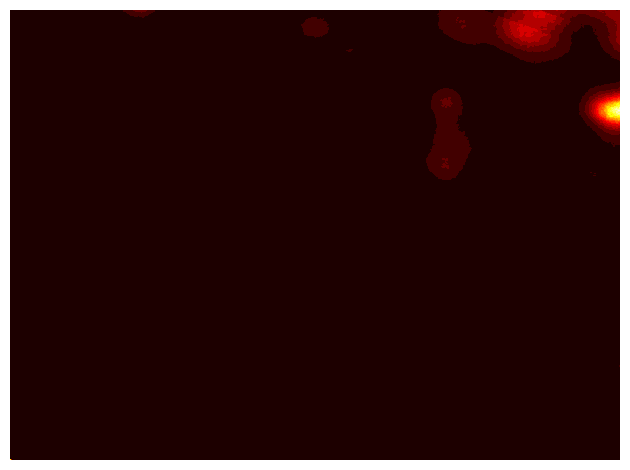

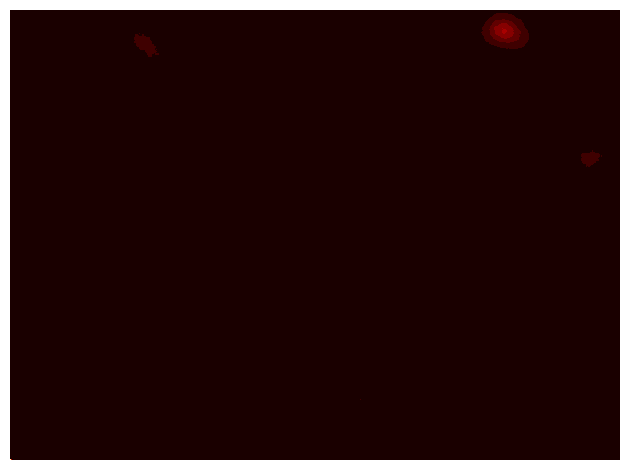

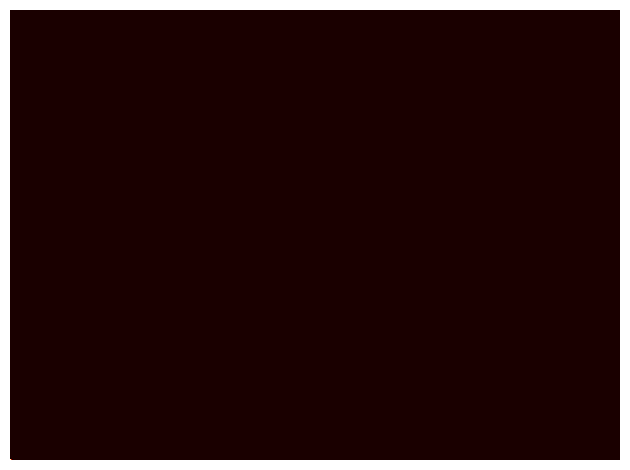

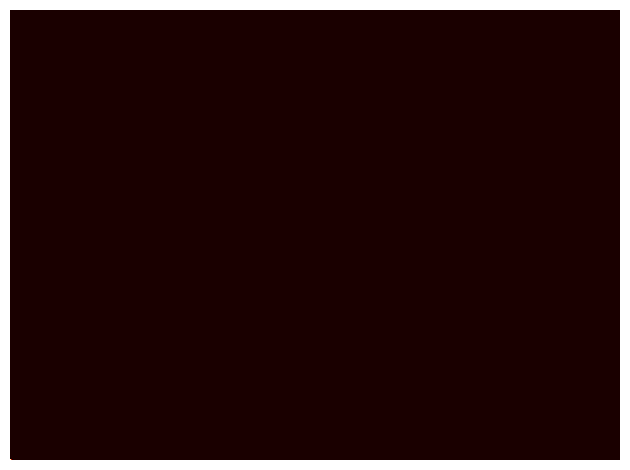

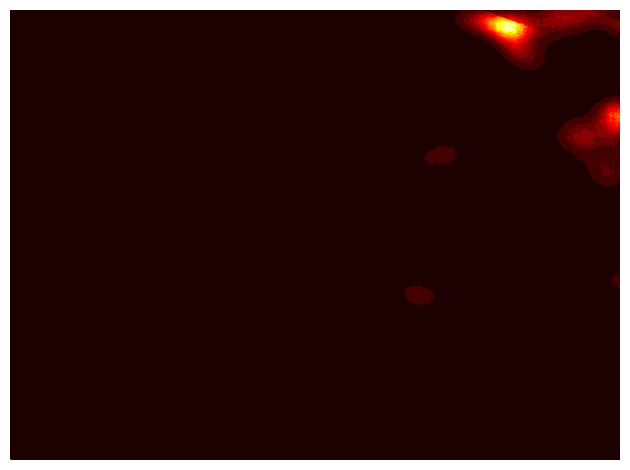

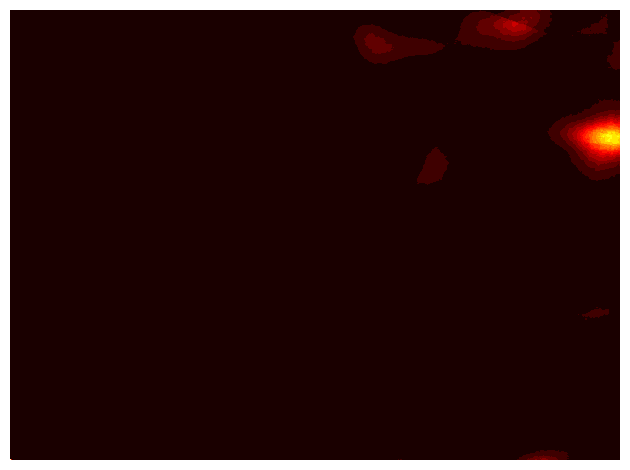

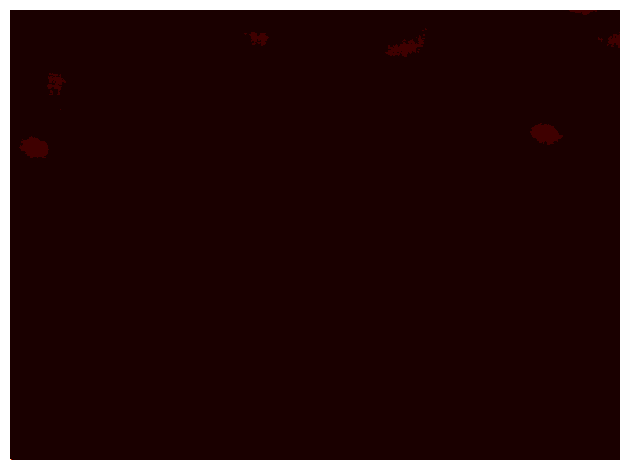

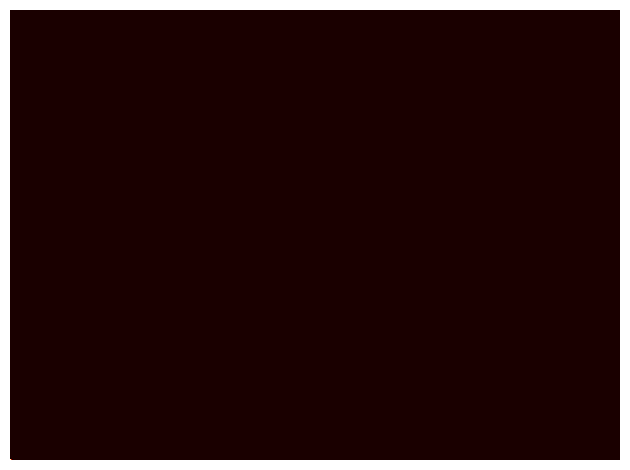

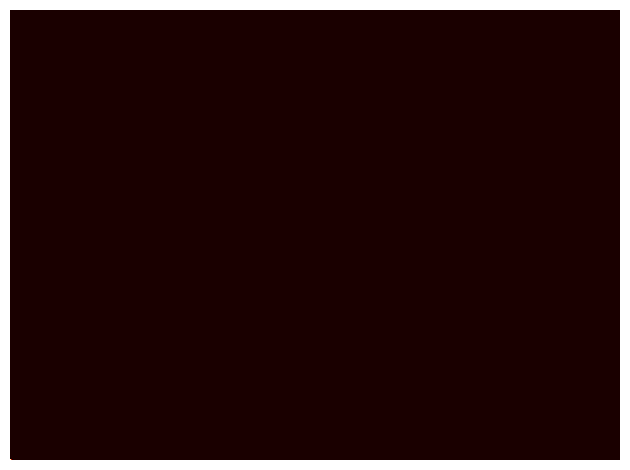

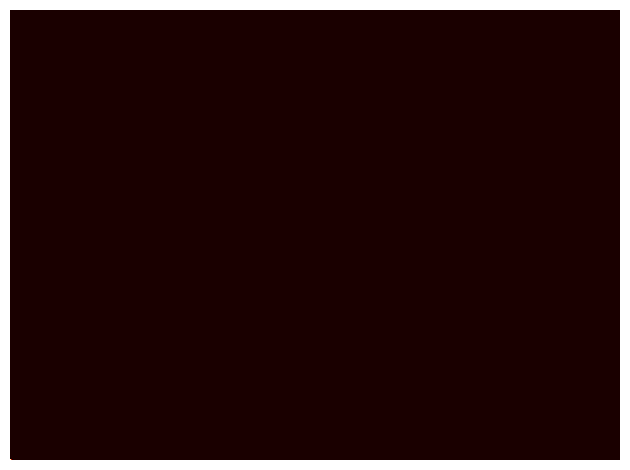

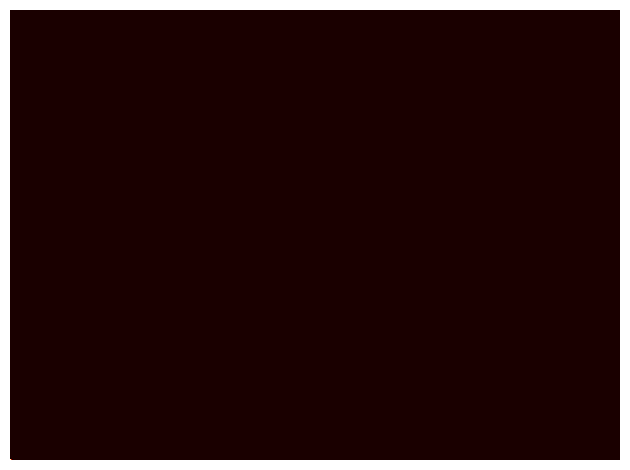

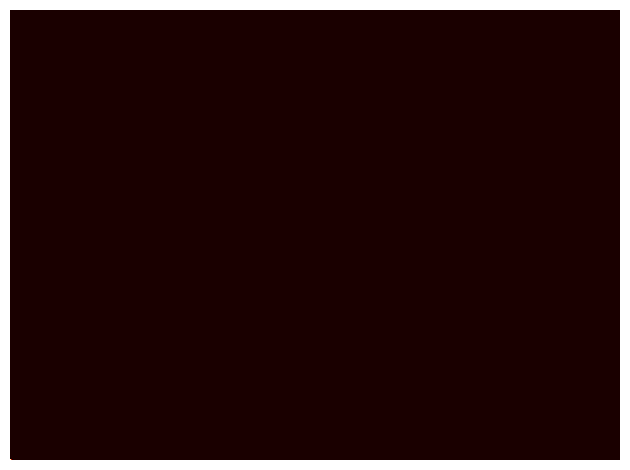

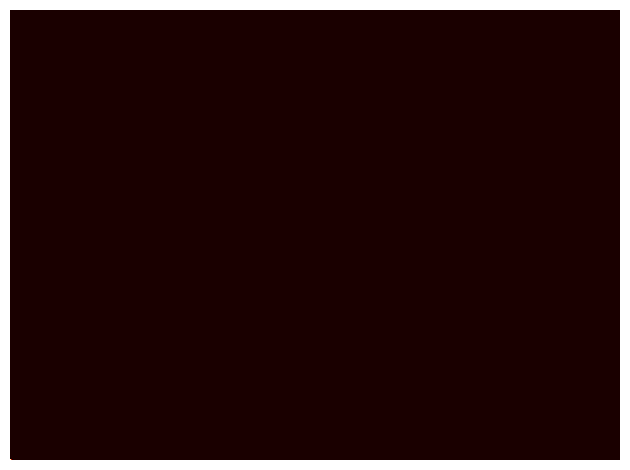

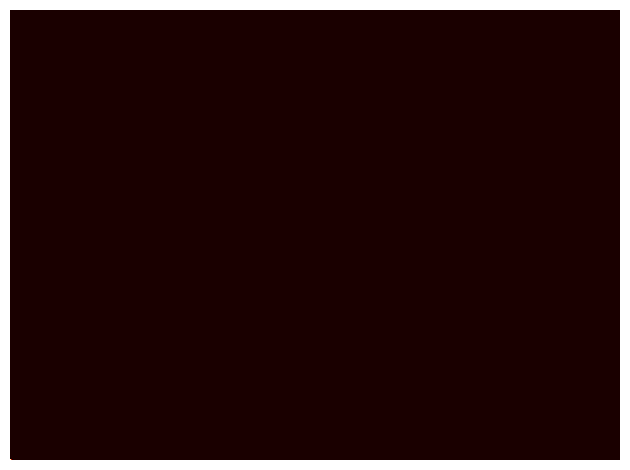

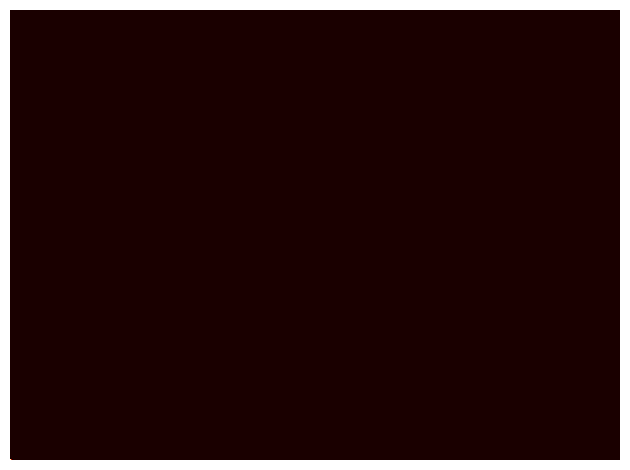

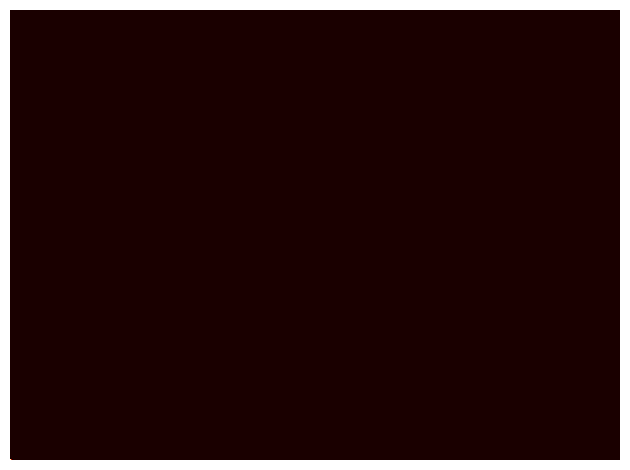

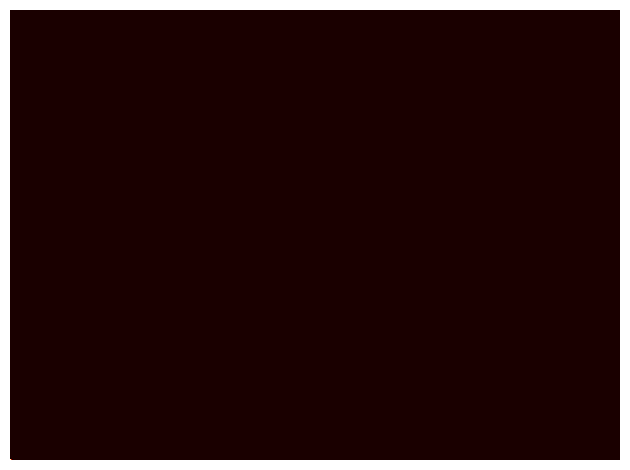

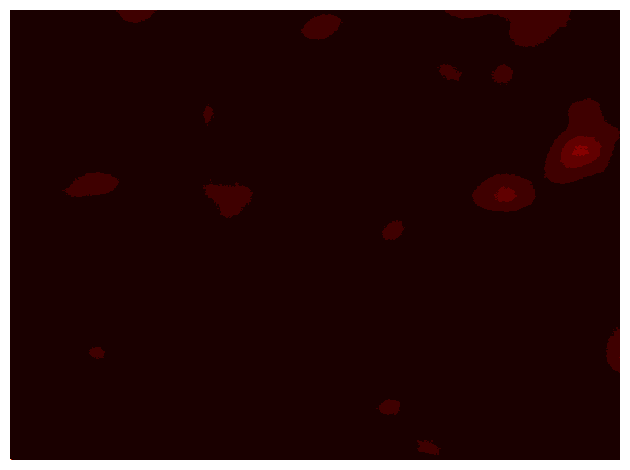

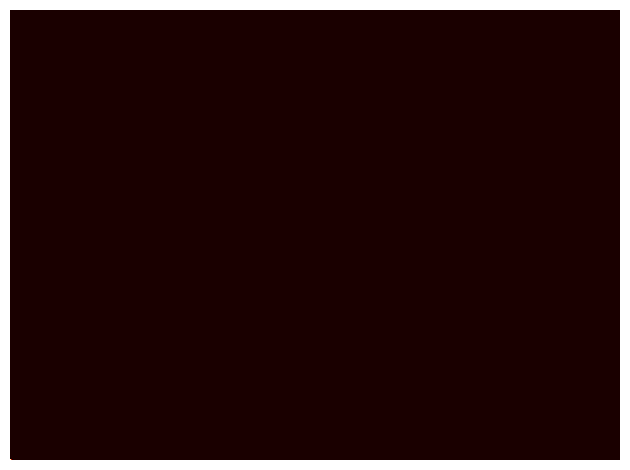

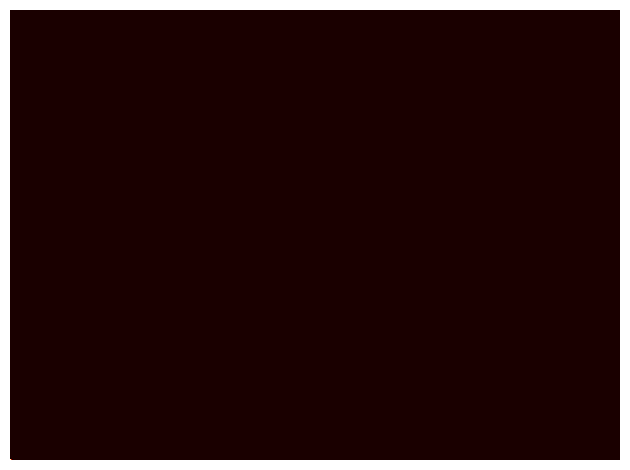

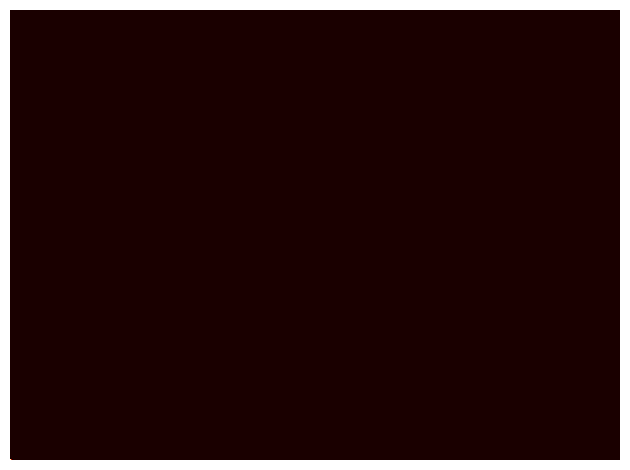

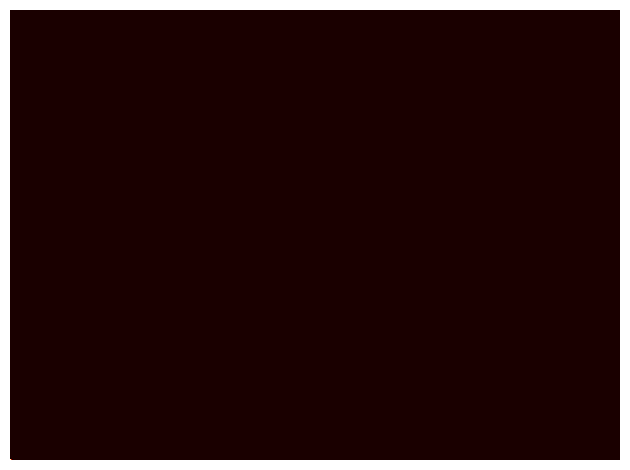

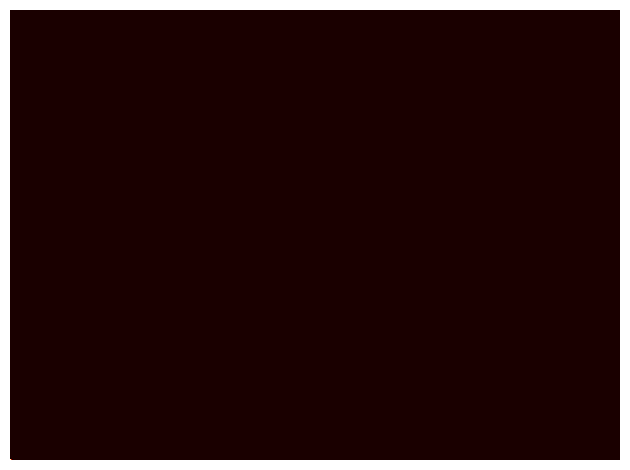

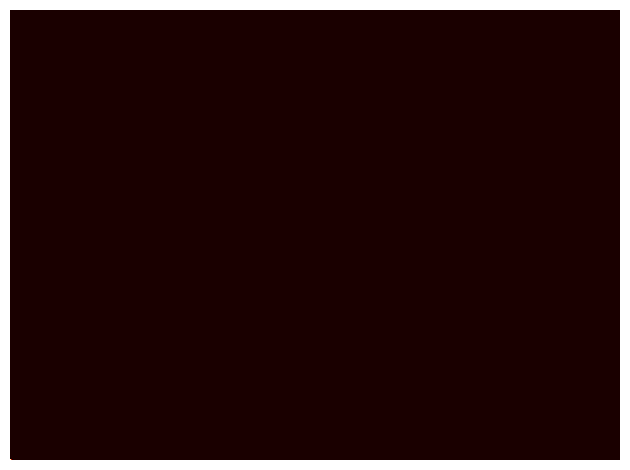

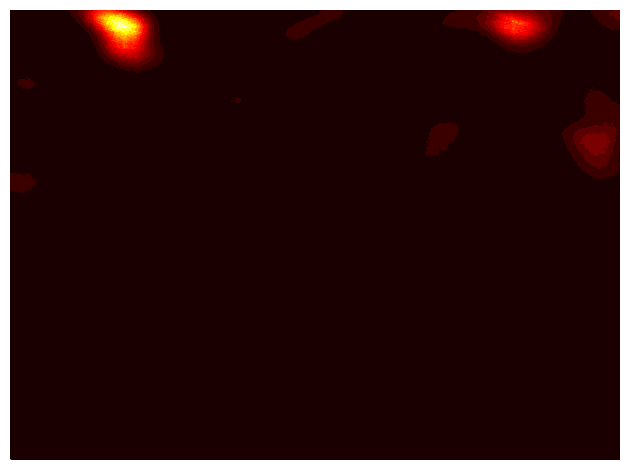

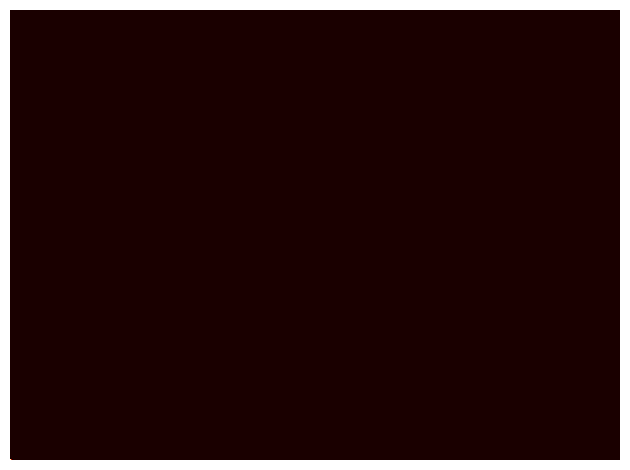

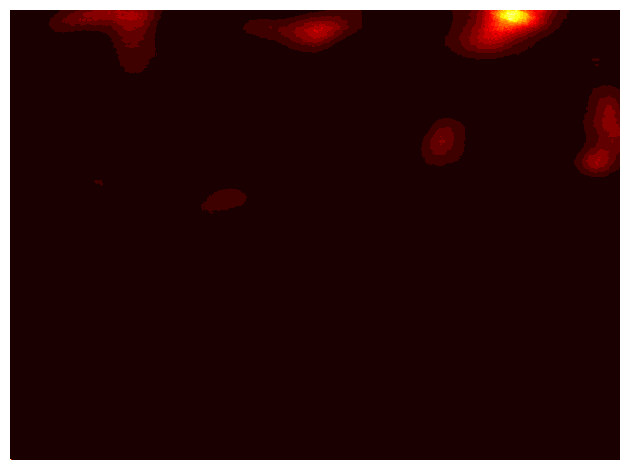

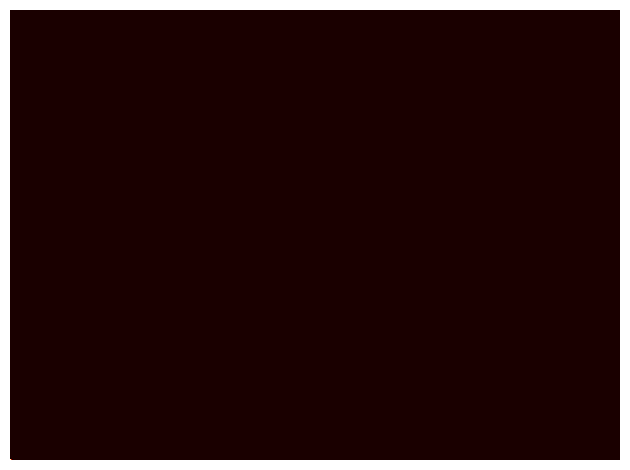

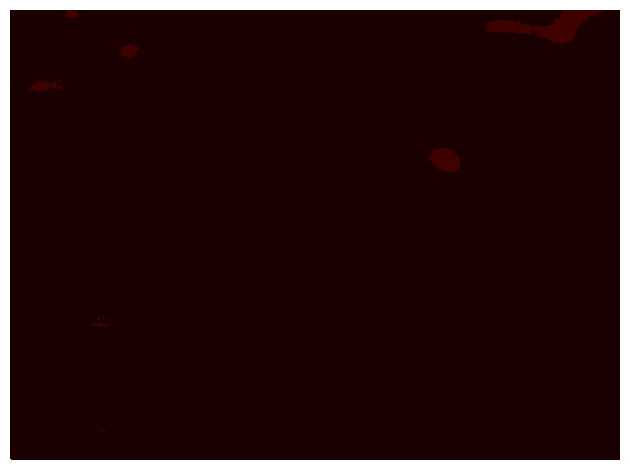

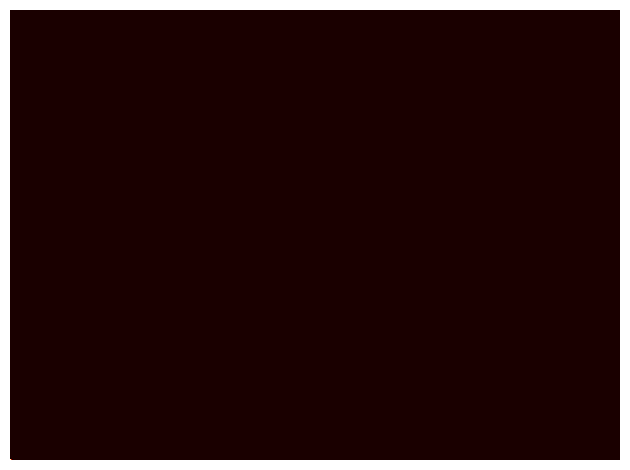

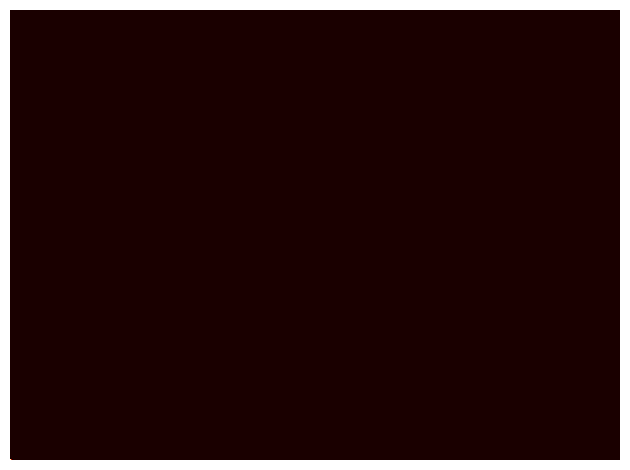

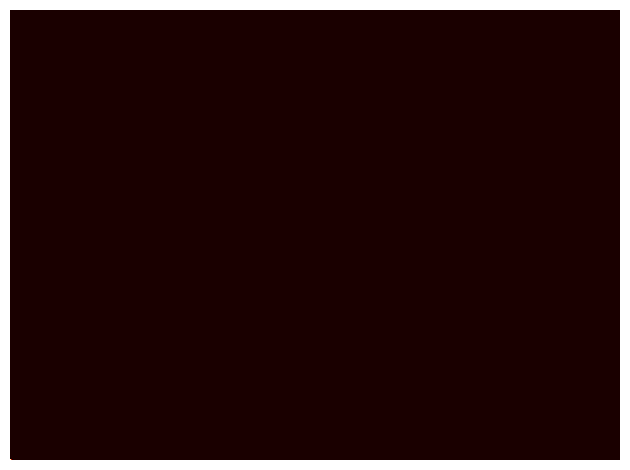

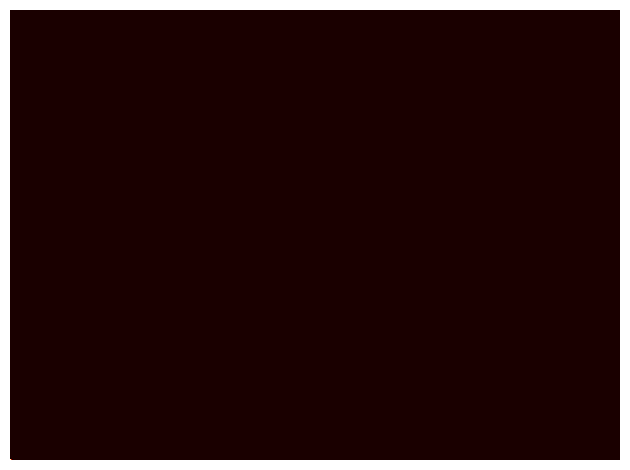

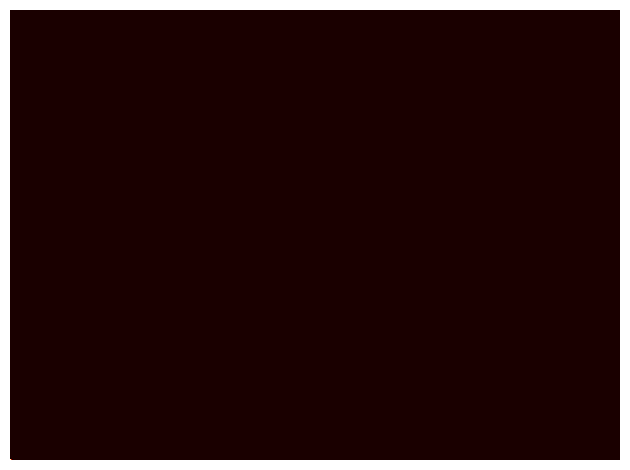

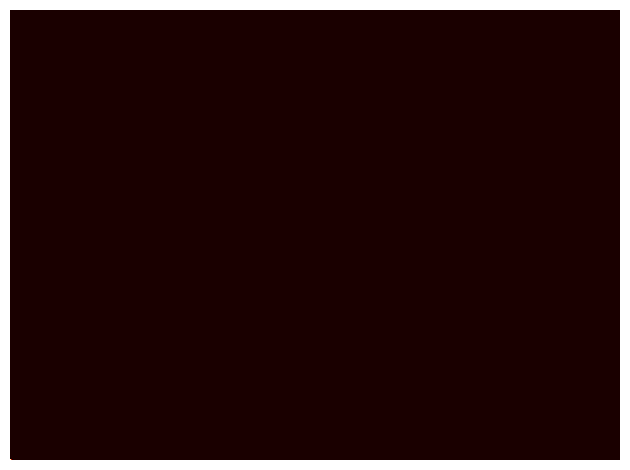

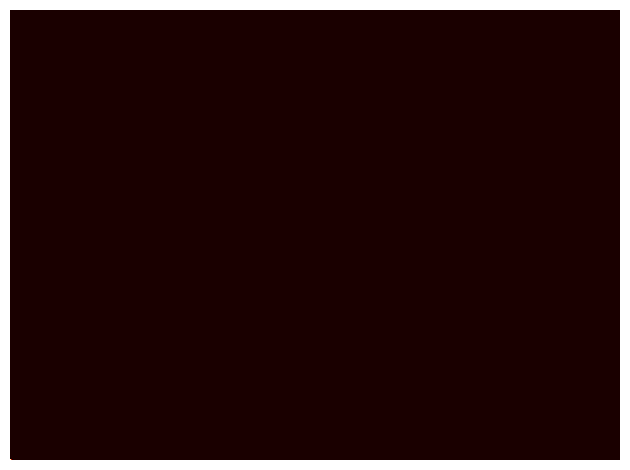

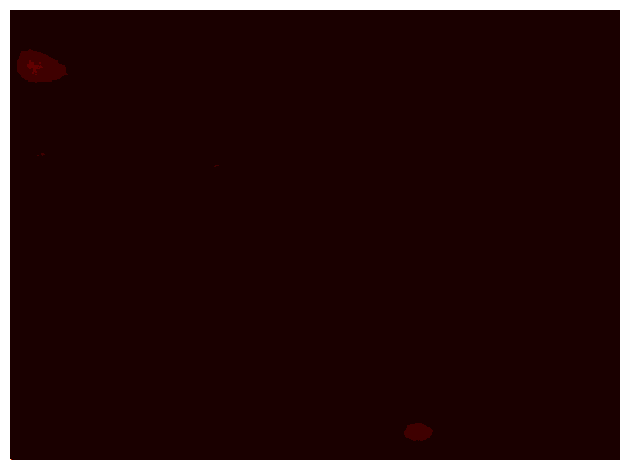

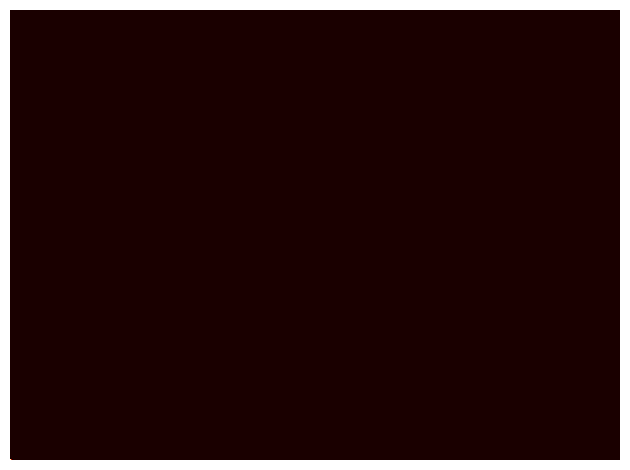

In [19]:
for img in hidden:
    plt.contourf(img, levels=20, cmap='hot')
    plt.axis('off')
    plt.tight_layout()
    plt.show()